In [1]:
library(Seurat)
library(Matrix)
library(useful)
library(harmony)
library(dplyr)
library(sva)
library(RColorBrewer)
library(Scillus)
library(ggrepel)
library(stringr)
library(ggpubr)
library(reshape2)
library(fgsea)
library(yarrr)
library(viridis)

set.seed(1234)

Attaching SeuratObject

Attaching sp

Loading required package: ggplot2

Loading required package: Rcpp


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel

Loading required package: jpeg

Loading required package: BayesFactor

Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: circlize

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=cir

### 1. UMAPs of normal kidney (non-immune) cells, dotplot of key cell type markers

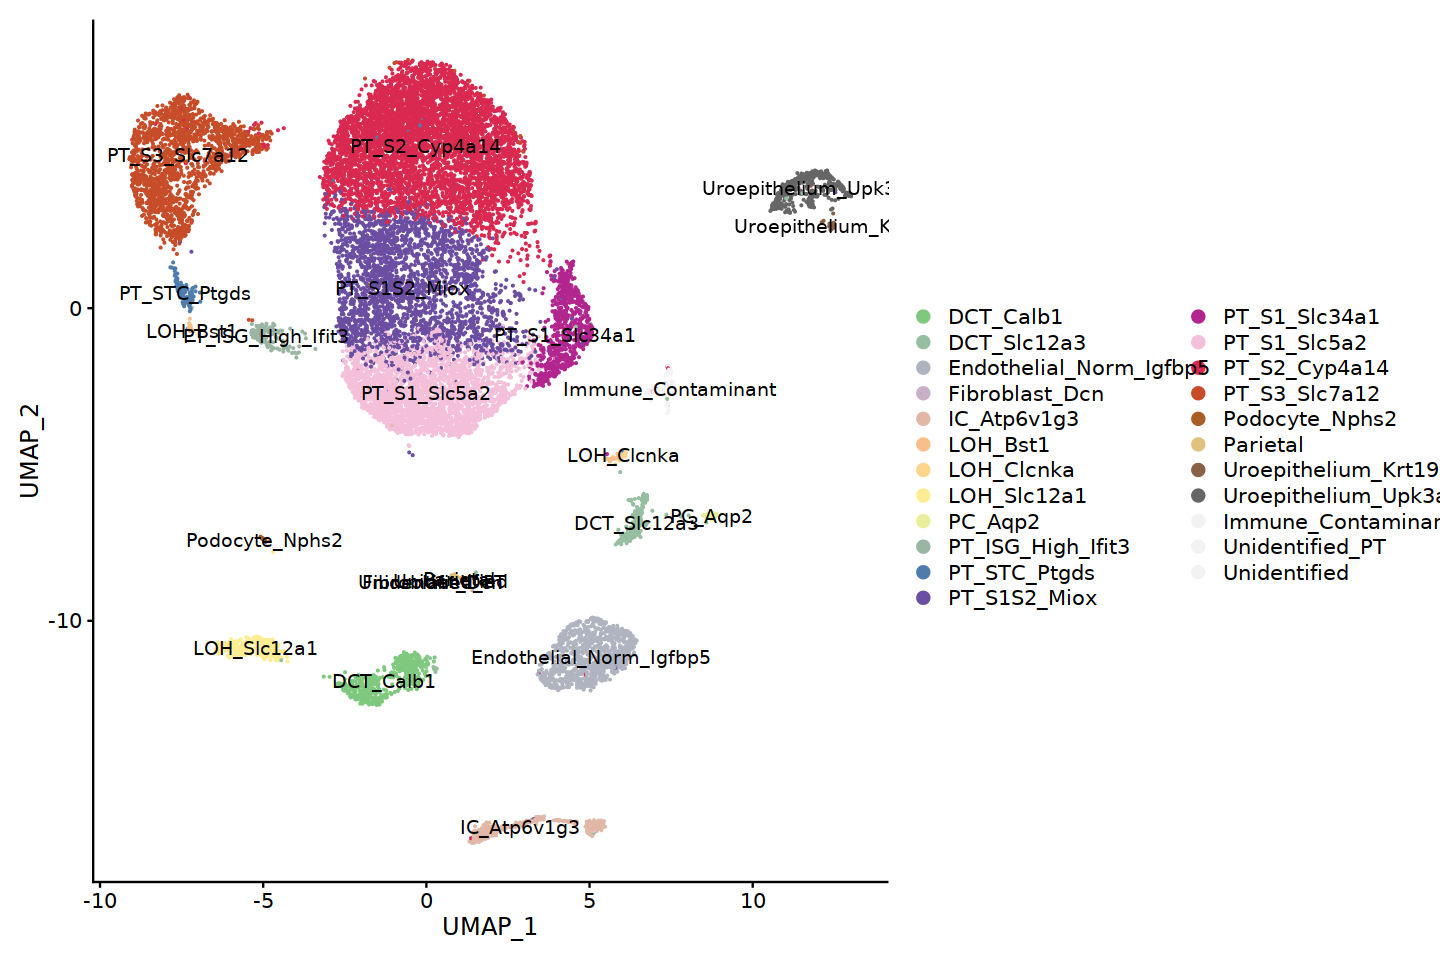

In [2]:
seur_n = readRDS(file = "Manuscript_Objects/NonImmune_NormalKidney_AmbFilt_SeuratObject_Final.RDS")
n_cols = readRDS(file = "Manuscript_Objects/NormalKidney_NonImmune_Colors_Final.RDS")

options(repr.plot.width=12, repr.plot.height=8)
DimPlot(seur_n, label = T, cols = n_cols[levels(Idents(seur_n))])

In [3]:
table(seur_n$Annot_Granular)


              DCT_Calb1             DCT_Slc12a3 Endothelial_Norm_Igfbp5 
                    519                     282                     905 
         Fibroblast_Dcn             IC_Atp6v1g3                LOH_Bst1 
                     39                     448                      51 
             LOH_Clcnka             LOH_Slc12a1                 PC_Aqp2 
                     33                     339                      55 
      PT_ISG_High_Ifit3            PT_STC_Ptgds            PT_S1S2_Miox 
                    163                     145                    2520 
          PT_S1_Slc34a1            PT_S1_Slc5a2           PT_S2_Cyp4a14 
                    744                    2574                    5479 
          PT_S3_Slc7a12          Podocyte_Nphs2                Parietal 
                   1666                      31                      18 
    Uroepithelium_Krt19     Uroepithelium_Upk3a      Immune_Contaminant 
                     39                     414   

In [4]:
samp_cols = readRDS("Manuscript_Objects/Sample_Colors.RDS")
samp_cols

11_VX5256_T    3_BB453_T 6_BB452_KL_T    9_VX516_T   10_VX516_N  12_VX5256_N 
   "#66C2A5"    "#FC8D62"    "#8DA0CB"    "#E78AC3"    "#A6D854"    "#FFD92F" 
5_BB452_KR_N    8_BB455_N 
   "#E5C494"    "#B3B3B3"

In [5]:
seur_n$Sample = factor(seur_n$Sample)
seur_n$Annot_Granular = factor(seur_n$Annot_Granular, levels = c("Podocyte_Nphs2","Parietal","PT_S1_Slc34a1","PT_S1_Slc5a2","PT_S1S2_Miox","PT_S2_Cyp4a14","PT_S3_Slc7a12","PT_STC_Ptgds","PT_ISG_High_Ifit3","LOH_Bst1","LOH_Clcnka","LOH_Slc12a1","DCT_Calb1","DCT_Slc12a3","IC_Atp6v1g3","PC_Aqp2","Endothelial_Norm_Igfbp5","Fibroblast_Dcn","Uroepithelium_Upk3a","Uroepithelium_Krt19","Immune_Contaminant","Unidentified_PT","Unidentified"))


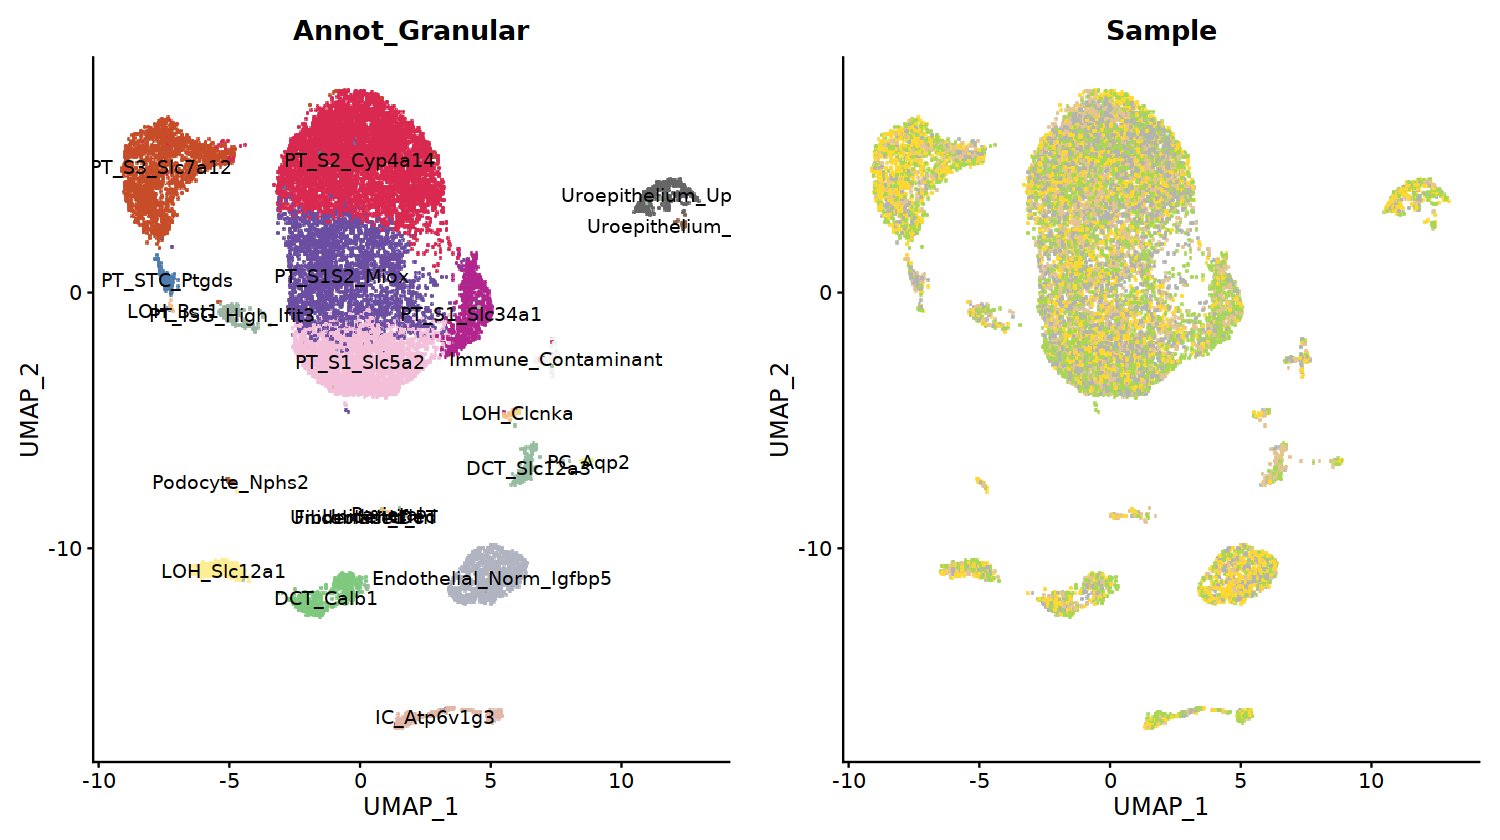

In [6]:
one = DimPlot(seur_n, label = T, group.by = "Annot_Granular",cols = n_cols[levels(seur_n$Annot_Granular)], raster = T) + NoLegend()
two = DimPlot(seur_n, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) + NoLegend()
three = DimPlot(seur_n, group.by = "Sample", cols = samp_cols[levels(seur_n$Sample)],shuffle = T,raster = T) + NoLegend()

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig8_NormalKidney_NonImmune_AmbFilt_Combined_CellType_Sample_Final_Repo.pdf", width = 12.5, height = 7)

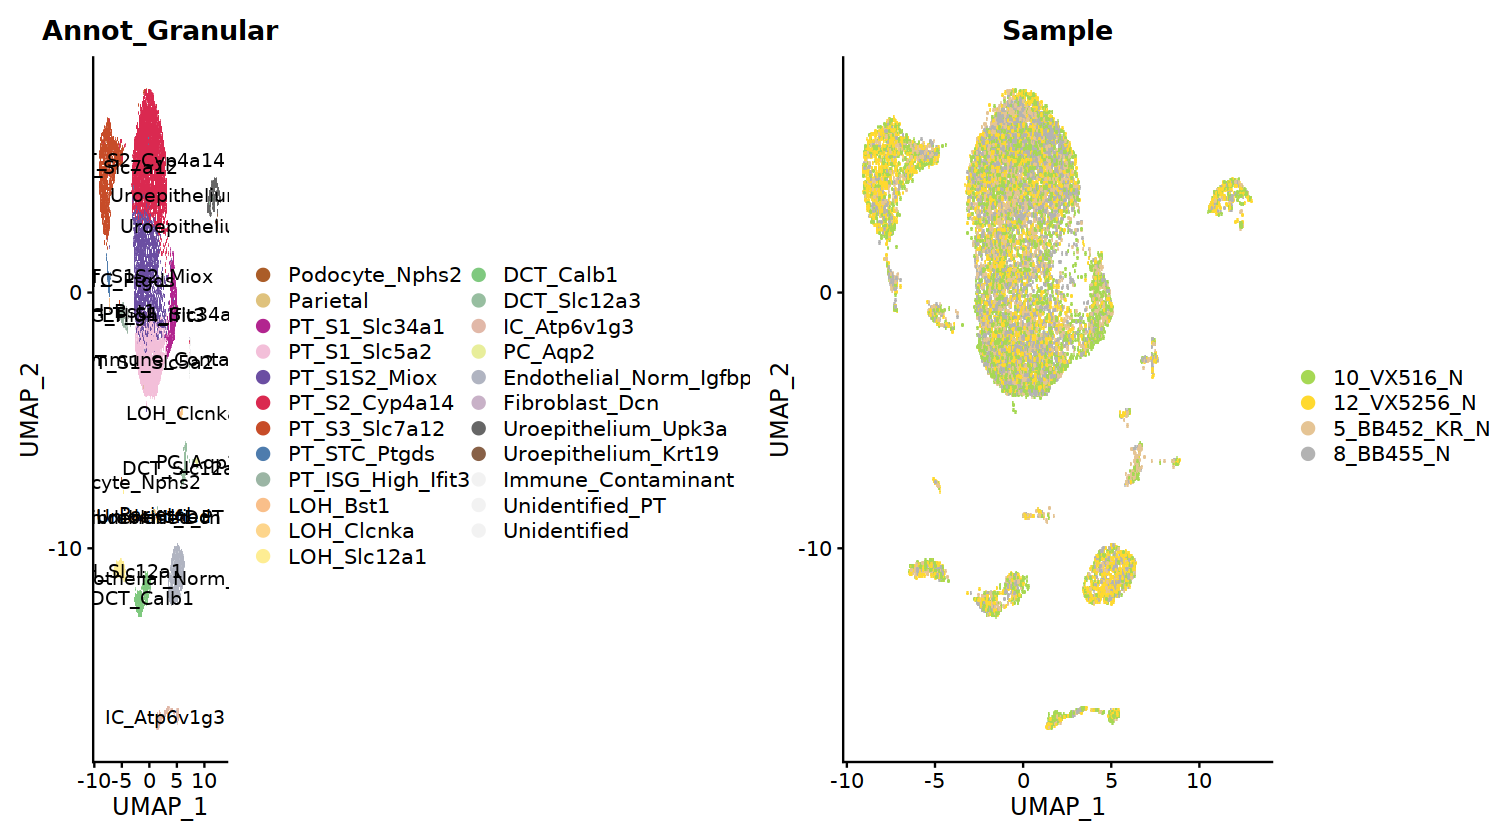

In [7]:
one = DimPlot(seur_n, label = T, group.by = "Annot_Granular",cols = n_cols[levels(seur_n$Annot_Granular)], raster = T) 
two = DimPlot(seur_n, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) 
three = DimPlot(seur_n, group.by = "Sample", cols = samp_cols[levels(seur_n$Sample)],shuffle = T,raster = T) 

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one,three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig8_NormalKidney_NonImmune_AmbFilt_Combined_CellType_Sample_WithLegend_Final_Repo.pdf", width = 12.5, height = 7)

In [8]:
Idents(seur_n) = "Annot_Granular"
seur_n_sub = subset(seur_n, idents = c("Immune_Contaminant","Unidentified_PT","Unidentified"), invert = T)
seur_n_sub$Annot_Granular = droplevels(seur_n_sub$Annot_Granular)


In [9]:
table(seur_n_sub$Annot_Granular)


         Podocyte_Nphs2                Parietal           PT_S1_Slc34a1 
                     31                      18                     744 
           PT_S1_Slc5a2            PT_S1S2_Miox           PT_S2_Cyp4a14 
                   2574                    2520                    5479 
          PT_S3_Slc7a12            PT_STC_Ptgds       PT_ISG_High_Ifit3 
                   1666                     145                     163 
               LOH_Bst1              LOH_Clcnka             LOH_Slc12a1 
                     51                      33                     339 
              DCT_Calb1             DCT_Slc12a3             IC_Atp6v1g3 
                    519                     282                     448 
                PC_Aqp2 Endothelial_Norm_Igfbp5          Fibroblast_Dcn 
                     55                     905                      39 
    Uroepithelium_Upk3a     Uroepithelium_Krt19 
                    414                      39 

In [10]:
table(seur_n_sub$Sample)


  10_VX516_N  12_VX5256_N 5_BB452_KR_N    8_BB455_N 
        4947         4270         3240         4007 

Var1           Var2       Freq        
1 Podocyte_Nphs2 10_VX516_N 0.0004042854
2 Parietal       10_VX516_N 0.0004042854
3 PT_S1_Slc34a1  10_VX516_N 0.0741863756
4 PT_S1_Slc5a2   10_VX516_N 0.1813220133
5 PT_S1S2_Miox   10_VX516_N 0.1417020416

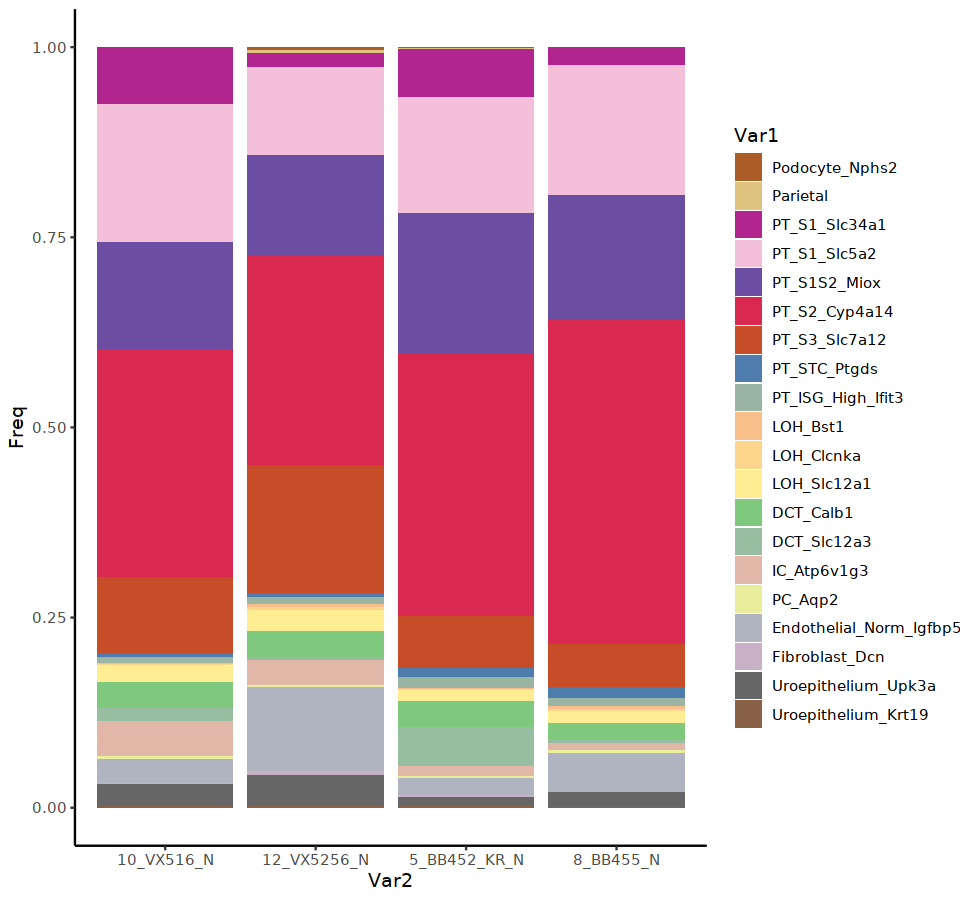

In [11]:
options(repr.plot.width=8, repr.plot.height=7.5)
props <- prop.table(table(seur_n_sub$Annot_Granular,seur_n_sub$Sample), margin = 2)
props <- data.frame(props)
corner(props)
ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") +theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = n_cols[levels(seur_n_sub$Annot_Granular)]) + theme_classic()


In [12]:
de = readRDS("Manuscript_Objects/NormalKidney_COI_FeatureSelection_Output_Final.RDS")
de$cluster = factor(de$cluster, levels = levels(seur_n_sub$Annot_Granular))
head(de)
table(de$cluster)

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster   gene   
Calb1   0     5.499423   0.671 0.014 0         DCT_Calb1 Calb1  
Klk1    0     4.625836   0.846 0.059 0         DCT_Calb1 Klk1   
Defb1   0     4.392208   0.934 0.064 0         DCT_Calb1 Defb1  
Tmem52b 0     3.855434   0.971 0.046 0         DCT_Calb1 Tmem52b
Pgam2   0     3.660409   0.933 0.020 0         DCT_Calb1 Pgam2  
Ppp1r1a 0     3.497390   0.965 0.033 0         DCT_Calb1 Ppp1r1a


         Podocyte_Nphs2                Parietal           PT_S1_Slc34a1 
                   1138                     413                    1064 
           PT_S1_Slc5a2            PT_S1S2_Miox           PT_S2_Cyp4a14 
                    586                     178                     466 
          PT_S3_Slc7a12            PT_STC_Ptgds       PT_ISG_High_Ifit3 
                    750                     852                    1050 
               LOH_Bst1              LOH_Clcnka             LOH_Slc12a1 
                    622                     650                    1037 
              DCT_Calb1             DCT_Slc12a3             IC_Atp6v1g3 
                   1216                     599                    1240 
                PC_Aqp2 Endothelial_Norm_Igfbp5          Fibroblast_Dcn 
                   1276                    1298                    1126 
    Uroepithelium_Upk3a     Uroepithelium_Krt19 
                   1549                    1316 

In [13]:
subset(de, cluster == "PT_S1_Slc34a1")

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster      
Gm269171     0.000000e+00 2.576583   0.892 0.696  0.000000e+00 PT_S1_Slc34a1
Neat12       0.000000e+00 1.971511   0.991 0.859  0.000000e+00 PT_S1_Slc34a1
Malat12      0.000000e+00 1.917772   1.000 0.947  0.000000e+00 PT_S1_Slc34a1
Xist         0.000000e+00 1.860753   0.602 0.472  0.000000e+00 PT_S1_Slc34a1
Mlxipl      1.080313e-301 1.911248   0.753 0.607 2.578816e-297 PT_S1_Slc34a1
Tns1        5.112269e-291 1.465280   0.940 0.880 1.220350e-286 PT_S1_Slc34a1
Kcnq1ot11   1.060895e-273 1.884523   0.852 0.715 2.532463e-269 PT_S1_Slc34a1
Slc34a11    5.011996e-259 1.180618   0.985 0.786 1.196414e-254 PT_S1_Slc34a1
AC149090.11 2.295988e-254 1.544218   0.844 0.749 5.480752e-250 PT_S1_Slc34a1
Ddx52       5.945286e-249 1.259681   0.957 0.948 1.419199e-244 PT_S1_Slc34a1
Snx29       4.168189e-247 1.638001   0.741 0.627 9.949883e-243 PT_S1_Slc34a1
Col27a1     7.909315e-233 1.851434   0.638 0.445 1.888033e-228 PT_S1_Slc34a1
Pnisr1      4.983518e-229 1.444750   0.840 0.766 1.189616e-224 PT_S1_Slc34a1
Abcc21      2.613891e-224 1.484327   0.843 0.706 6.239618e-220 PT_S1_Slc34a1
Snrnp701    2.213746e-200 1.397209   0.780 0.763 5.284434e-196 PT_S1_Slc34a1
Vegfa1      2.310369e-200 1.431649   0.737 0.670 5.515082e-196 PT_S1_Slc34a1
Prpf4b2     9.601623e-196 1.440699   0.810 0.791 2.292003e-191 PT_S1_Slc34a1
Snhg11      2.426763e-191 2.100628   0.698 0.435 5.792925e-187 PT_S1_Slc34a1
Ccnl22      3.332155e-188 1.413307   0.680 0.615 7.954187e-184 PT_S1_Slc34a1
Slc5a121    1.752052e-187 1.946324   0.714 0.395 4.182323e-183 PT_S1_Slc34a1
Ogt1        2.959241e-180 1.332226   0.780 0.748 7.064003e-176 PT_S1_Slc34a1
BC005561    3.556947e-171 1.382101   0.780 0.733 8.490787e-167 PT_S1_Slc34a1
Luc7l21     2.239072e-170 1.348072   0.793 0.788 5.344889e-166 PT_S1_Slc34a1
Kcnj151     7.877641e-161 1.171865   0.890 0.778 1.880472e-156 PT_S1_Slc34a1
Gm472831    3.500877e-160 1.440436   0.652 0.597 8.356943e-156 PT_S1_Slc34a1
Srsf111     6.529204e-159 1.305690   0.759 0.777 1.558586e-154 PT_S1_Slc34a1
Cspp11      1.735400e-157 1.370770   0.664 0.640 4.142573e-153 PT_S1_Slc34a1
Pabpn11     2.309952e-156 1.253352   0.758 0.773 5.514086e-152 PT_S1_Slc34a1
Mafg        6.423641e-155 1.312400   0.714 0.698 1.533387e-150 PT_S1_Slc34a1
Ddx172      4.108597e-153 1.319381   0.731 0.715 9.807632e-149 PT_S1_Slc34a1
...         ...           ...        ...   ...   ...           ...          
Bcar11      0.003145368   0.3494949  0.212 0.382 1             PT_S1_Slc34a1
Kif1b1      0.003318020   0.3539160  0.288 0.489 1             PT_S1_Slc34a1
Etnk14      0.003486330   0.3739662  0.411 0.610 1             PT_S1_Slc34a1
Mapt        0.003641835   0.2832082  0.320 0.620 1             PT_S1_Slc34a1
Xpo11       0.004268308   0.3346579  0.191 0.352 1             PT_S1_Slc34a1
Ash2l       0.004296869   0.2741086  0.142 0.267 1             PT_S1_Slc34a1
Sh3d19      0.004312329   0.3157444  0.219 0.396 1             PT_S1_Slc34a1
Ppfia1      0.004792528   0.3154504  0.188 0.358 1             PT_S1_Slc34a1
Ints2       0.004798660   0.2726285  0.171 0.308 1             PT_S1_Slc34a1
Chd1        0.004855702   0.3115339  0.180 0.343 1             PT_S1_Slc34a1
Brap        0.004996900   0.3499080  0.218 0.417 1             PT_S1_Slc34a1
Lrba5       0.005271851   0.3622764  0.223 0.395 1             PT_S1_Slc34a1
Pik3ca      0.005296721   0.4039184  0.261 0.471 1             PT_S1_Slc34a1
Rbbp82      0.006035800   0.2552458  0.161 0.277 1             PT_S1_Slc34a1
Trmt1       0.006059522   0.2795577  0.148 0.296 1             PT_S1_Slc34a1
Ube2d2a     0.006140218   0.4575217  0.358 0.619 1             PT_S1_Slc34a1
Fip1l1      0.006289056   0.3810174  0.241 0.440 1             PT_S1_Slc34a1
Pax25       0.007128353   0.2714551  0.152 0.282 1             PT_S1_Slc34a1
Gm10804     0.007276541   0.4021806  0.246 0.461 1             PT_S1_Slc34a1
P2rx41      0.007399986   0.2590394  0.148 0.269 1             PT_S1_Slc34a1
Rabep11 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



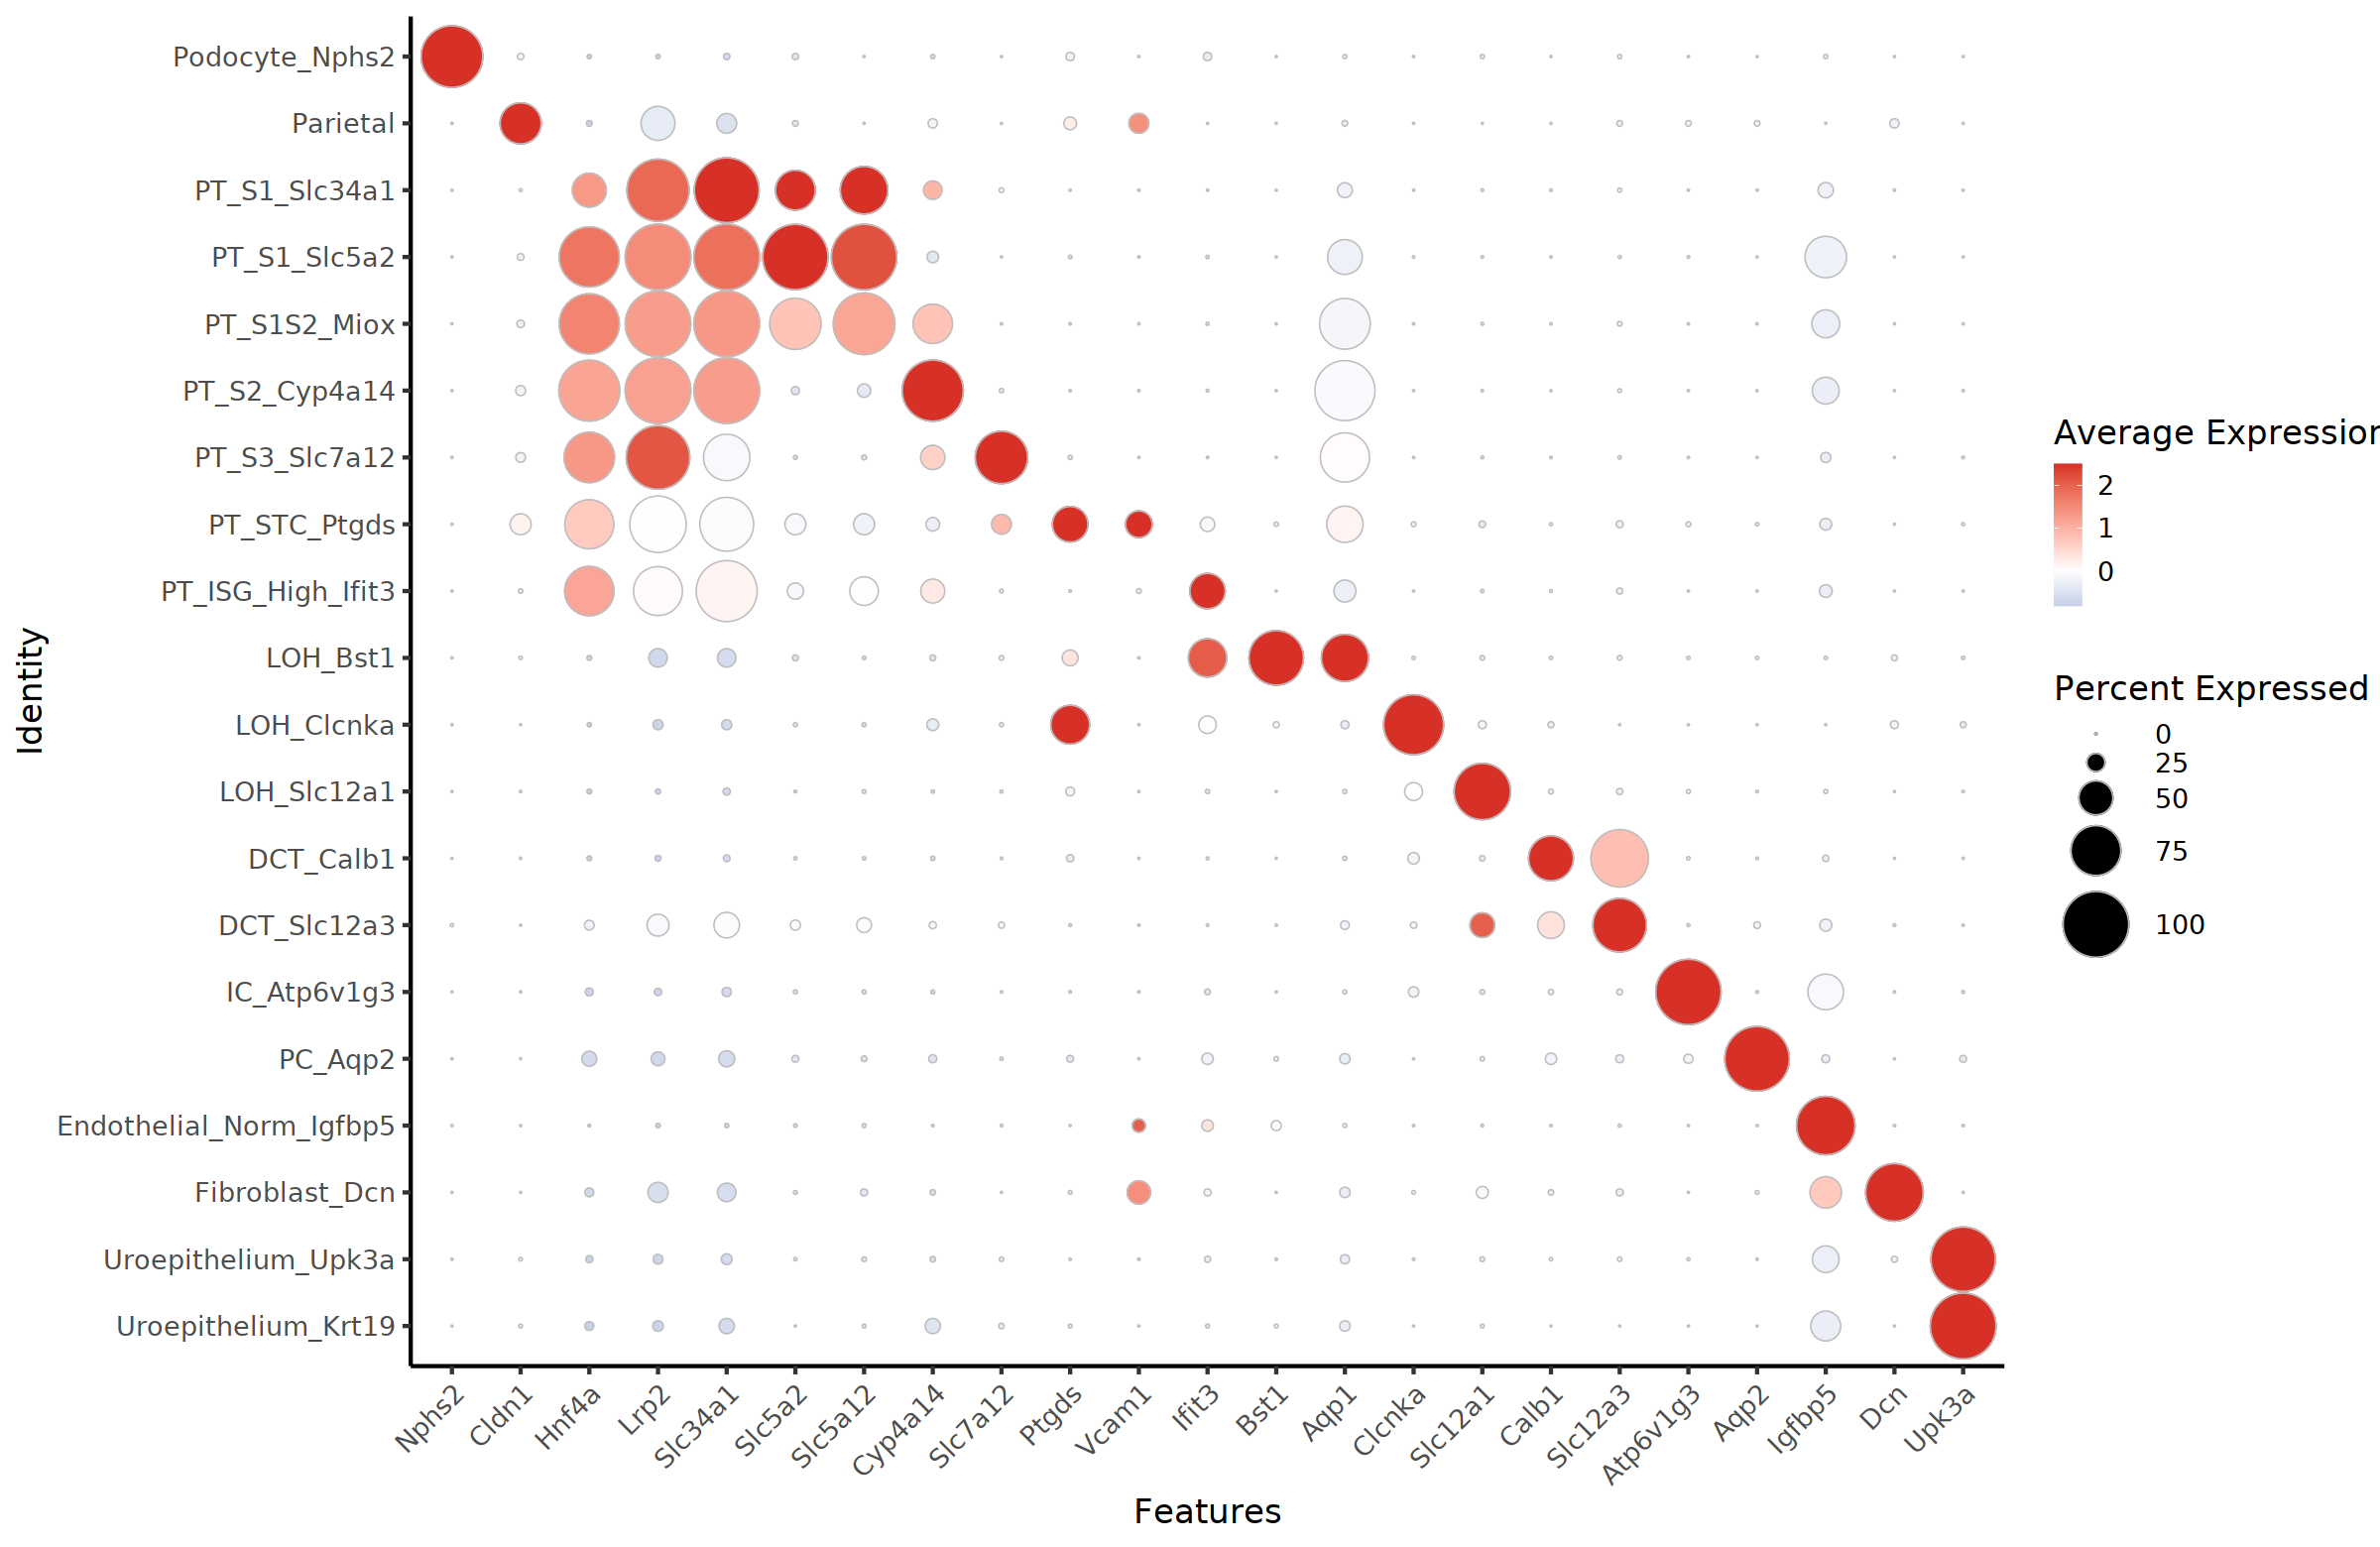

In [15]:
options(repr.plot.width=20, repr.plot.height=13)

Idents(seur_n_sub) = factor(Idents(seur_n_sub), levels = rev(levels(Idents(seur_n_sub))))

DotPlot(seur_n_sub, features = c("Nphs2","Cldn1","Hnf4a","Lrp2","Slc34a1","Slc5a2","Slc5a12","Cyp4a14","Slc7a12","Ptgds","Vcam1","Ifit3","Bst1","Aqp1","Clcnka","Slc12a1","Calb1","Slc12a3","Atp6v1g3","Aqp2","Igfbp5","Dcn","Upk3a"),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_n_sub) = factor(Idents(seur_n_sub), levels = rev(levels(Idents(seur_n_sub))))

ggsave("Manuscript_Figures/SuppFig8_NormalKidney_DotPlot_Final_Repo.pdf", width = 20, height = 13)

### 2. UMAPs of tumor (non-immune) cells, dotplot of key cluster markers

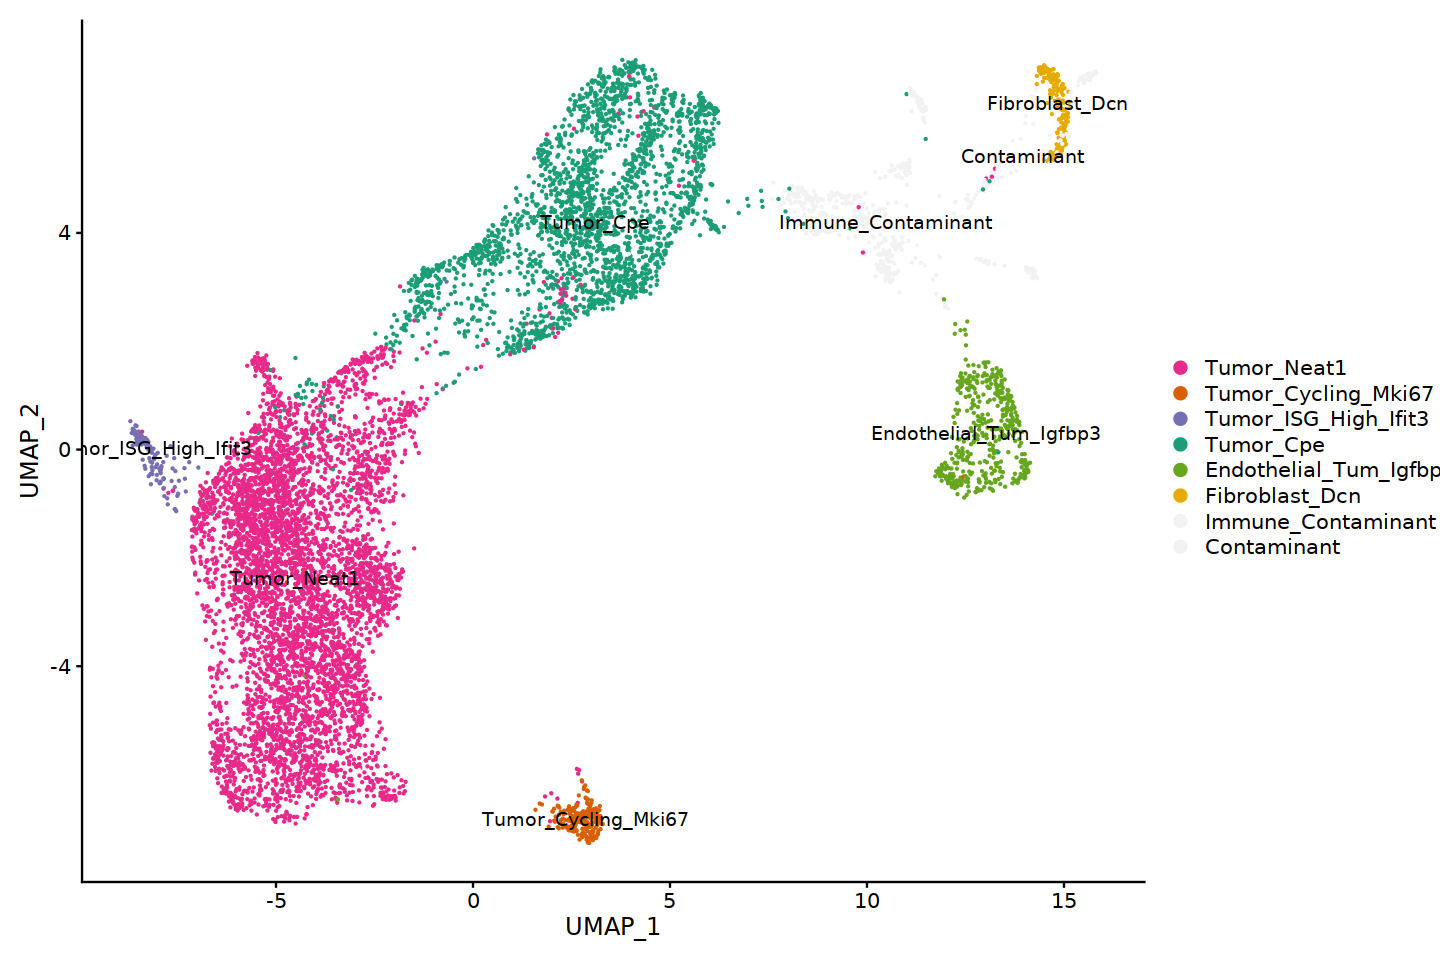

In [16]:
seur_t = readRDS(file = "Manuscript_Objects/NonImmune_Tumor_AmbFilt_SeuratObject.RDS")
t_cols = readRDS(file = "Manuscript_Objects/Tumor_NonImmune_Colors.RDS")

t_cols = replace(t_cols, t_cols == "lightgrey","gray95")

options(repr.plot.width=12, repr.plot.height=8)
DimPlot(seur_t, label = T, cols = t_cols)

In [17]:
seur_t$Sample = factor(seur_t$Sample)

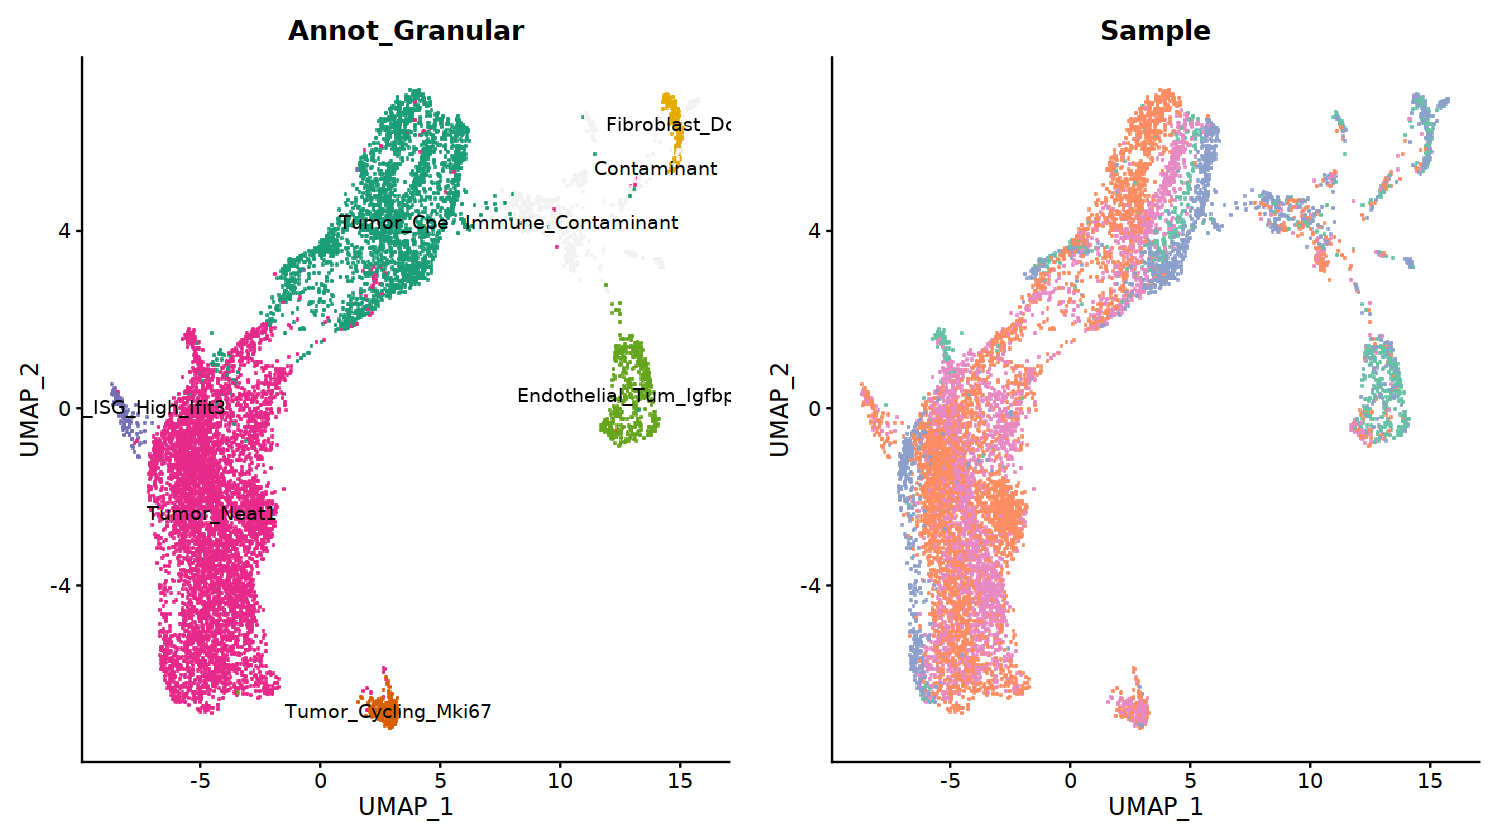

In [18]:
seur_t$Sample = factor(seur_t$Sample)
one = DimPlot(seur_t, label = T, group.by = "Annot_Granular",cols = t_cols[levels(seur_t$Annot_Granular)], raster = T) + NoLegend()
two = DimPlot(seur_t, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) + NoLegend()
three = DimPlot(seur_t, group.by = "Sample", cols = samp_cols[levels(seur_t$Sample)],shuffle = T,raster = T) + NoLegend()

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig8_Tumor_NonImmune_AmbFilt_Combined_CellType_Sample_Repo.pdf", width = 12.5, height = 7)

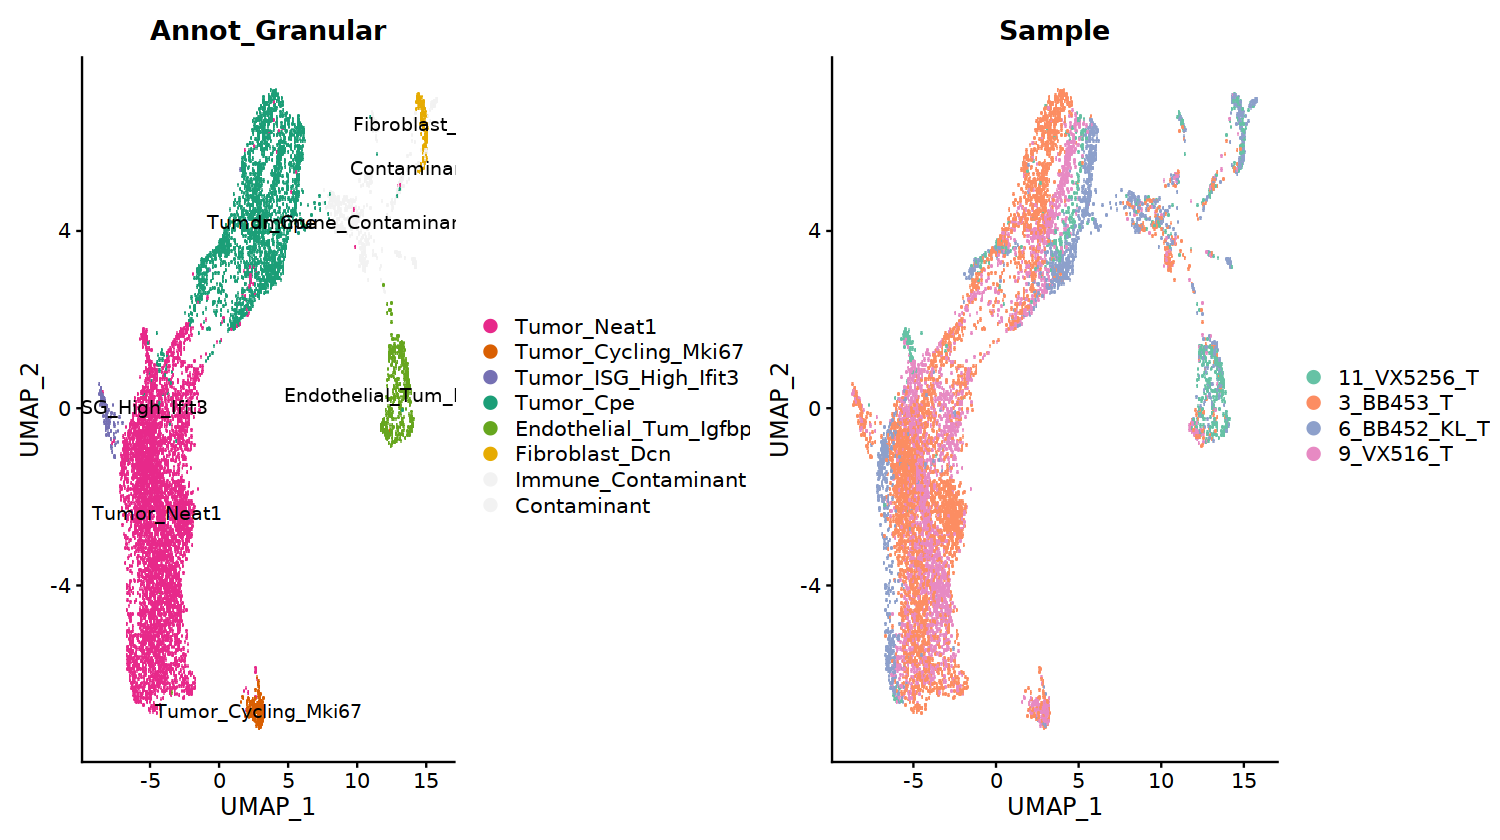

In [19]:
one = DimPlot(seur_t, label = T, group.by = "Annot_Granular",cols = t_cols[levels(seur_t$Annot_Granular)], raster = T) 
two = DimPlot(seur_t, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T)
three = DimPlot(seur_t, group.by = "Sample", cols = samp_cols[levels(seur_t$Sample)],shuffle = T,raster = T)

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig8_Tumor_NonImmune_AmbFilt_Combined_CellType_Sample_WithLegend_Repo.pdf", width = 12.5, height = 7)

In [20]:
Idents(seur_t) = "Annot_Granular"
seur_t_sub = subset(seur_t, idents = c("Immune_Contaminant","Contaminant"), invert = T)
seur_t_sub$Annot_Granular = droplevels(seur_t_sub$Annot_Granular)

In [21]:
table(seur_t_sub$Annot_Granular)


           Tumor_Neat1    Tumor_Cycling_Mki67   Tumor_ISG_High_Ifit3 
                  5208                    219                    119 
             Tumor_Cpe Endothelial_Tum_Igfbp3         Fibroblast_Dcn 
                  2398                    468                    189 

In [22]:
table(seur_t_sub$Sample)


 11_VX5256_T    3_BB453_T 6_BB452_KL_T    9_VX516_T 
         614         3966         1224         2797 

Var1                   Var2        Freq       
1 Tumor_Neat1            11_VX5256_T 0.122149837
2 Tumor_Cycling_Mki67    11_VX5256_T 0.000000000
3 Tumor_ISG_High_Ifit3   11_VX5256_T 0.001628664
4 Tumor_Cpe              11_VX5256_T 0.335504886
5 Endothelial_Tum_Igfbp3 11_VX5256_T 0.421824104

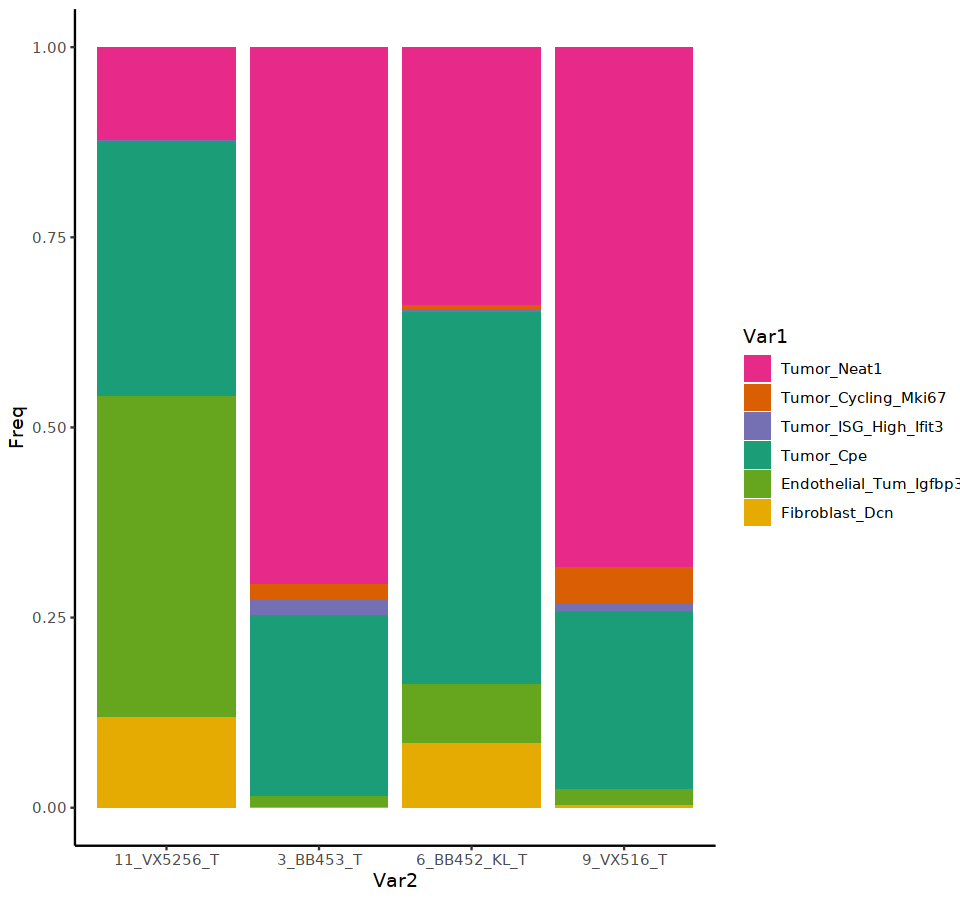

In [23]:
options(repr.plot.width=8, repr.plot.height=7.5)
props <- prop.table(table(seur_t_sub$Annot_Granular,seur_t_sub$Sample), margin = 2)
props <- data.frame(props)
corner(props)
ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") +theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = t_cols[levels(seur_t_sub$Annot_Granular)]) + theme_classic()


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



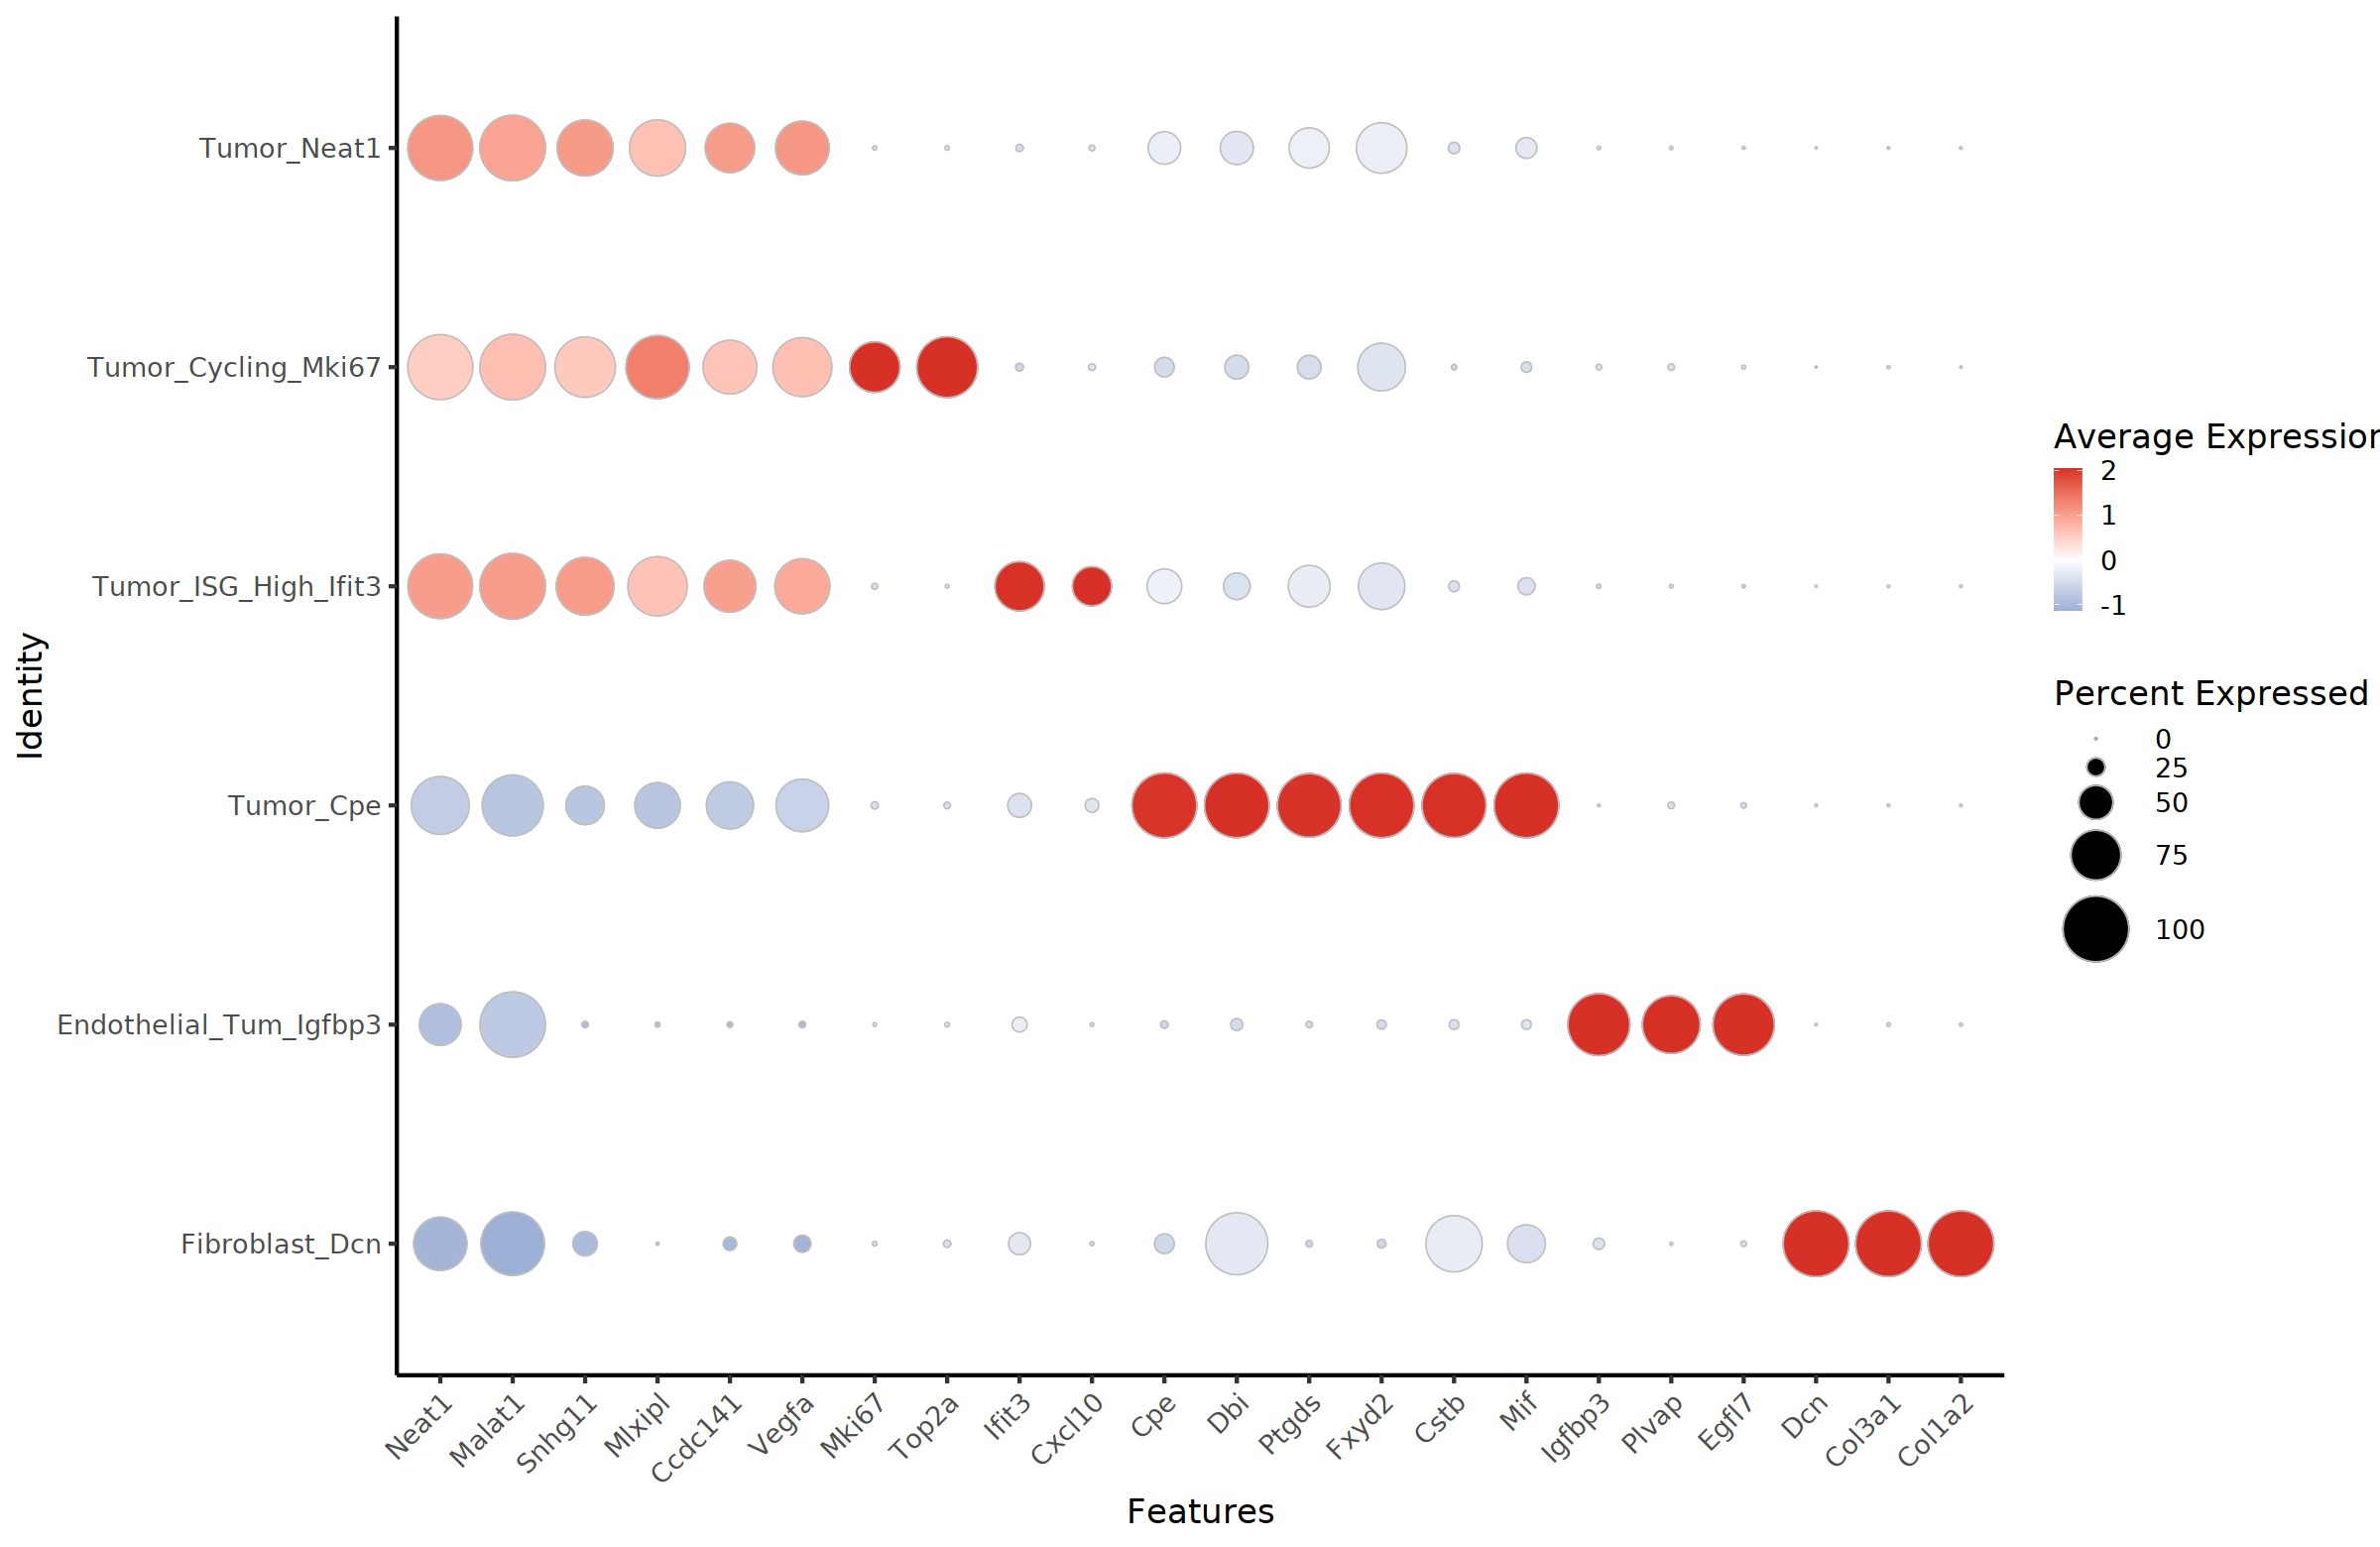

In [24]:
options(repr.plot.width=20, repr.plot.height=13)

Idents(seur_t_sub) = factor(Idents(seur_t_sub), levels = rev(levels(Idents(seur_t_sub))))

DotPlot(seur_t_sub, features = c("Neat1","Malat1","Snhg11","Mlxipl","Ccdc141","Vegfa","Mki67","Top2a","Ifit3","Cxcl10","Cpe","Dbi","Ptgds","Fxyd2","Cstb","Mif","Igfbp3","Plvap","Egfl7","Dcn","Col3a1","Col1a2"),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_t_sub) = factor(Idents(seur_t_sub), levels = rev(levels(Idents(seur_t_sub))))

ggsave("Manuscript_Figures/SuppFig8_Tumor_DotPlot_Repo.pdf", width = 20, height = 13)

### 3. Heatmap of genes differentially expressed between Tumor_Cpe (Tumor Clust2) and Tumor_Neat1 (Tumor Clust1)

In [26]:
cpe_vs_neat1 = readRDS(file = "Manuscript_Objects/Tumor_Cpe_vs_Tumor_Neat1_DE_LR_Sex_MainFigObject.RDS")
cpe_vs_neat1$gene = row.names(cpe_vs_neat1)
head(cpe_vs_neat1)

p_val avg_log2FC pct.1 pct.2 p_val_adj gene  
Snhg6  0     0.6384220  0.716 0.118 0         Snhg6 
Rpl7   0     2.5893893  0.919 0.074 0         Rpl7  
Eloc   0     0.8414005  0.821 0.177 0         Eloc  
Smap1  0     0.7532624  0.831 0.296 0         Smap1 
Cox5b  0     2.7653969  0.939 0.073 0         Cox5b 
Mrpl30 0     1.0801761  0.790 0.058 0         Mrpl30

In [27]:
hif2 = c("Epas1")
hif_targets = c("Egln3","Ldha","Car9","Ndrg1","Vegfa","Hk2")
nrf2_targets = c("Nqo1","Gstm1","Gstp1")
EMT = c("Vim","Fn1","Cdh2","Col1a1","Col1a2")
kidney_injury = c("Vcam1","C3","Ptgds","Havcr1","Nupr1","Akap12","Sox9")
metallothionein = c("Mt1","Mt2")

In [28]:
goi_cpe = intersect(c(hif2,hif_targets,nrf2_targets,kidney_injury,EMT,metallothionein), cpe_vs_neat1$gene)
goi_cpe_sig = cpe_vs_neat1[goi_cpe,] %>%
subset(avg_log2FC > 0 & p_val_adj < 0.001)

goi_cpe_sig$gene

[1] "Egln3"  "Ldha"   "Car9"   "Ndrg1"  "Nqo1"   "Gstm1"  "Gstp1"  "Vcam1" 
 [9] "C3"     "Ptgds"  "Havcr1" "Nupr1"  "Akap12" "Sox9"   "Vim"    "Fn1"   
[17] "Mt1"    "Mt2"

In [29]:
goi_neat1 = c("Neat1","Malat1","Snhg11","Kcnq1ot1","Ogt","Vegfa","Hk2","Hif1a","Zeb2")

In [30]:
subset(cpe_vs_neat1, gene %in% goi_neat1)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     gene    
Snhg11    0.000000e+00 -2.7049505 0.571 0.847  0.000000e+00 Snhg11  
Kcnq1ot1  0.000000e+00 -1.8893897 0.592 0.763  0.000000e+00 Kcnq1ot1
Vegfa     0.000000e+00 -1.6601724 0.794 0.810  0.000000e+00 Vegfa   
Malat1    0.000000e+00 -2.4316619 0.925 1.000  0.000000e+00 Malat1  
Neat1     0.000000e+00 -2.4409687 0.877 0.988  0.000000e+00 Neat1   
Ogt       0.000000e+00 -1.7741628 0.763 0.831  0.000000e+00 Ogt     
Zeb2     2.936776e-173 -1.1248661 0.782 0.701 7.010379e-169 Zeb2    
Hk2       1.165897e-48 -0.9302556 0.828 0.646  2.783112e-44 Hk2     
Hif1a     3.955615e-10 -0.4269085 0.640 0.424  9.442449e-06 Hif1a

In [31]:
table(Idents(seur_t_sub))
table(seur_t_sub$Annot_Granular)
levels(seur_t_sub$Annot_Granular)


           Tumor_Neat1    Tumor_Cycling_Mki67   Tumor_ISG_High_Ifit3 
                  5208                    219                    119 
             Tumor_Cpe Endothelial_Tum_Igfbp3         Fibroblast_Dcn 
                  2398                    468                    189 


           Tumor_Neat1    Tumor_Cycling_Mki67   Tumor_ISG_High_Ifit3 
                  5208                    219                    119 
             Tumor_Cpe Endothelial_Tum_Igfbp3         Fibroblast_Dcn 
                  2398                    468                    189 

[1] "Tumor_Neat1"            "Tumor_Cycling_Mki67"    "Tumor_ISG_High_Ifit3"  
[4] "Tumor_Cpe"              "Endothelial_Tum_Igfbp3" "Fibroblast_Dcn"

In [32]:
seur_t_sub2 = subset(seur_t_sub,idents = c("Tumor_Neat1","Tumor_Cpe"))
seur_t_sub2$Annot_Granular = droplevels(seur_t_sub2$Annot_Granular)

In [33]:
levels(seur_t_sub2$Sample)

[1] "11_VX5256_T"  "3_BB453_T"    "6_BB452_KL_T" "9_VX516_T"

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



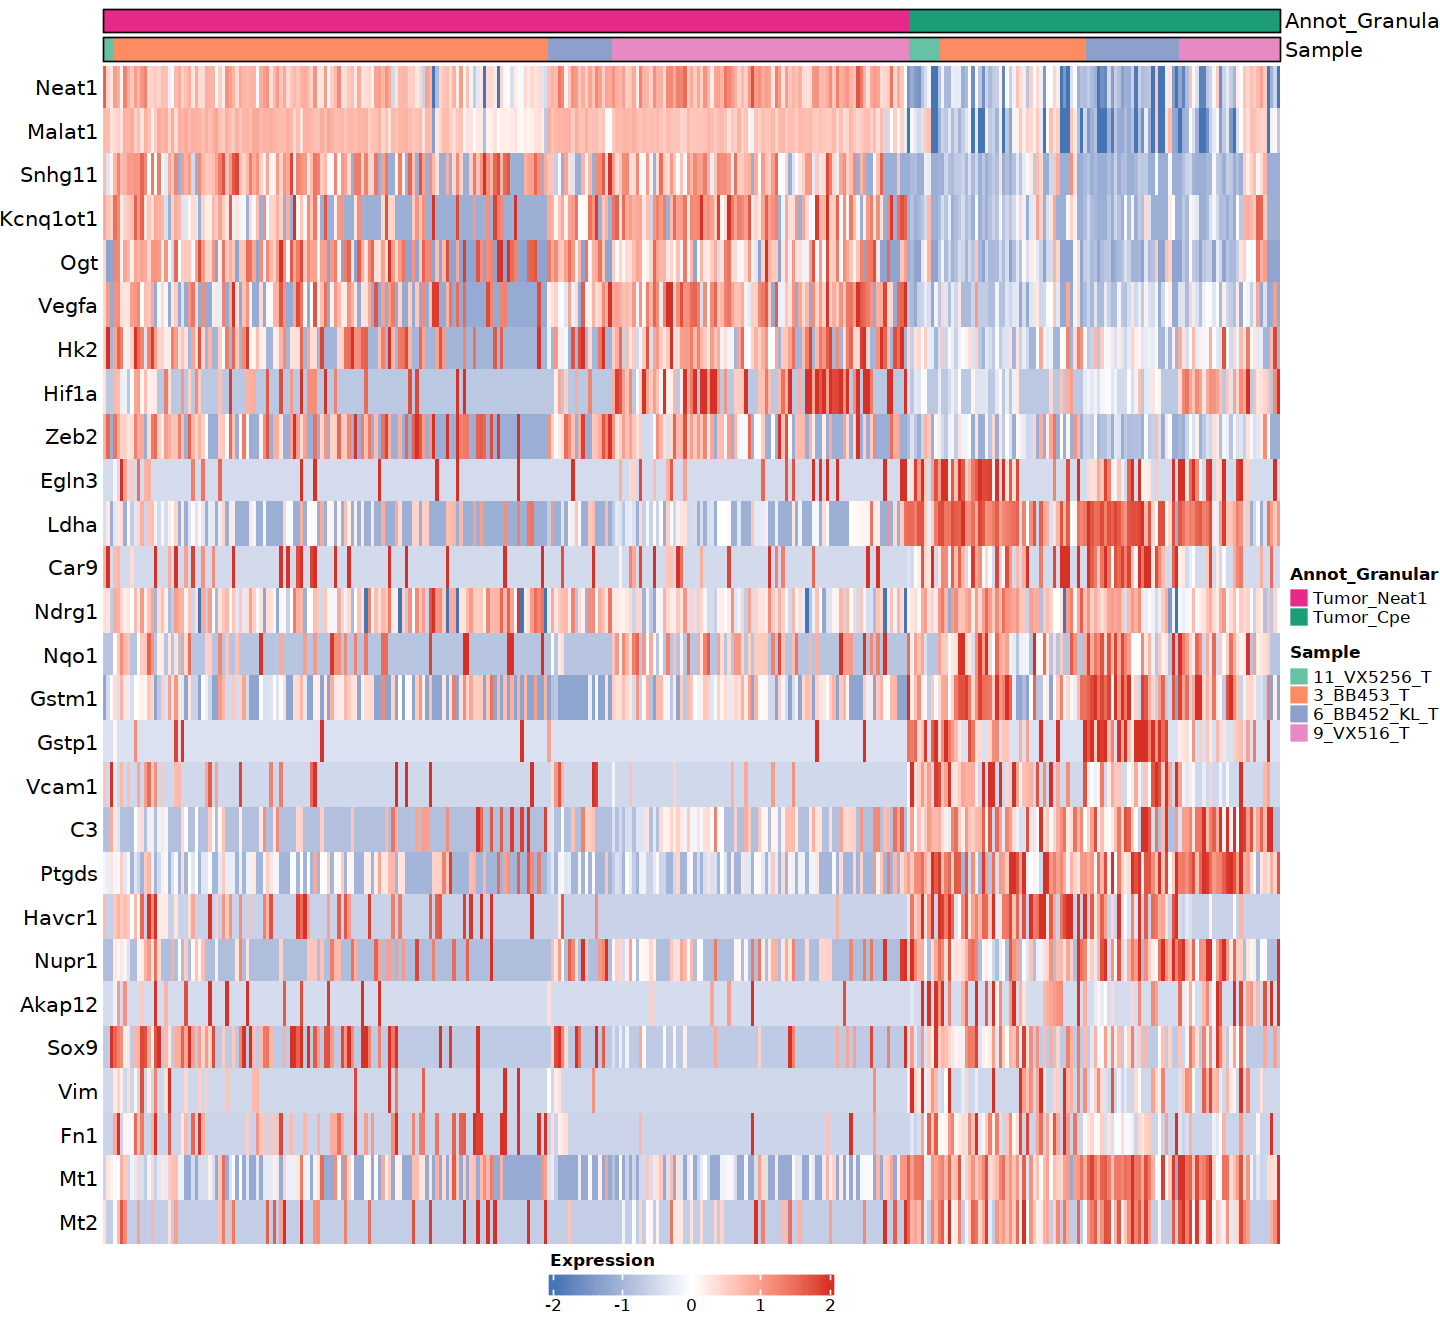

In [34]:
options(repr.plot.width=12, repr.plot.height=11)

colors <- list(t_cols[levels(seur_t_sub2$Annot_Granular)],samp_cols[levels(seur_t_sub2$Sample)])

plot_heatmap(dataset = seur_t_sub2, 
              markers = c(goi_neat1,goi_cpe_sig$gene),
              sort_var = c("Annot_Granular","Sample"),
              anno_var = c("Annot_Granular","Sample"),
              anno_colors = colors)


In [35]:
pdf("Manuscript_Figures/SuppFig8_Tumor_DE_ScillusHeat_Repo.pdf", width = 12, height = 11, useDingbats = F)

options(repr.plot.width=12, repr.plot.height=11)

colors <- list(t_cols[levels(seur_t_sub2$Annot_Granular)],samp_cols[levels(seur_t_sub2$Sample)])

plot_heatmap(dataset = seur_t_sub2, 
              markers = c(goi_neat1,goi_cpe_sig$gene),
              sort_var = c("Annot_Granular","Sample"),
              anno_var = c("Annot_Granular","Sample"),
              anno_colors = colors)

dev.off()

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



pdf 
  2

### 4. Dotplot of STC markers in normal PT clusters

In [36]:
table(Idents(seur_n_sub))


         Podocyte_Nphs2                Parietal           PT_S1_Slc34a1 
                     31                      18                     744 
           PT_S1_Slc5a2            PT_S1S2_Miox           PT_S2_Cyp4a14 
                   2574                    2520                    5479 
          PT_S3_Slc7a12            PT_STC_Ptgds       PT_ISG_High_Ifit3 
                   1666                     145                     163 
               LOH_Bst1              LOH_Clcnka             LOH_Slc12a1 
                     51                      33                     339 
              DCT_Calb1             DCT_Slc12a3             IC_Atp6v1g3 
                    519                     282                     448 
                PC_Aqp2 Endothelial_Norm_Igfbp5          Fibroblast_Dcn 
                     55                     905                      39 
    Uroepithelium_Upk3a     Uroepithelium_Krt19 
                    414                      39 

In [37]:
seur_stc = subset(seur_n_sub, idents = c("PT_S1_Slc34a1","PT_S1_Slc5a2","PT_S1S2_Miox","PT_S2_Cyp4a14","PT_S3_Slc7a12","PT_ISG_High_Ifit3","PT_STC_Ptgds"))
Idents(seur_stc) = factor(Idents(seur_stc), levels = c("PT_S1_Slc34a1","PT_S1_Slc5a2","PT_S1S2_Miox","PT_S2_Cyp4a14","PT_S3_Slc7a12","PT_ISG_High_Ifit3","PT_STC_Ptgds"))


### Read in DE results for PT STC vs other PT clusters

In [38]:
pt_de = readRDS("pt_de.RDS")
pt_de[c("Hnf4a","Lrp2","Slc5a2","Cyp4a14","Slc7a12","Ptgds","Vcam1","Havcr1",'Vim',"Krt8","Krt18","Akap12","Sox9","S100a6","S100a10","Anxa3"),]

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Hnf4a    1.565891e-07 -0.3956556 0.738 0.873  3.737940e-03
Lrp2     2.542479e-56 -1.3489717 0.855 0.988  6.069151e-52
Slc5a2   5.104715e-07 -0.8698210 0.297 0.420  1.218546e-02
Cyp4a14  4.884728e-25 -1.3996720 0.179 0.590  1.166033e-20
Slc7a12  2.177931e-09  0.7456779 0.276 0.119  5.198940e-05
Ptgds   1.622880e-106  2.1915464 0.524 0.010 3.873976e-102
Vcam1    2.870221e-85  1.4242742 0.386 0.002  6.851504e-81
Havcr1   1.910295e-30  0.8838416 0.166 0.004  4.560065e-26
Vim      4.448065e-14  0.3313202 0.083 0.002  1.061798e-09
Krt8     5.089079e-32  0.9928639 0.703 0.477  1.214814e-27
Krt18    1.334200e-27  0.2808246 0.145 0.004  3.184869e-23
Akap12   1.438731e-29  0.6198756 0.138 0.001  3.434394e-25
Sox9     1.121749e-45  0.5386987 0.248 0.003  2.677728e-41
S100a6   3.129764e-15  0.6326663 0.097 0.006  7.471059e-11
S100a10  3.802381e-97  1.8709009 0.959 0.693  9.076663e-93
Anxa3    7.564044e-47  0.6757253 0.221 0.002  1.805613e-42

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



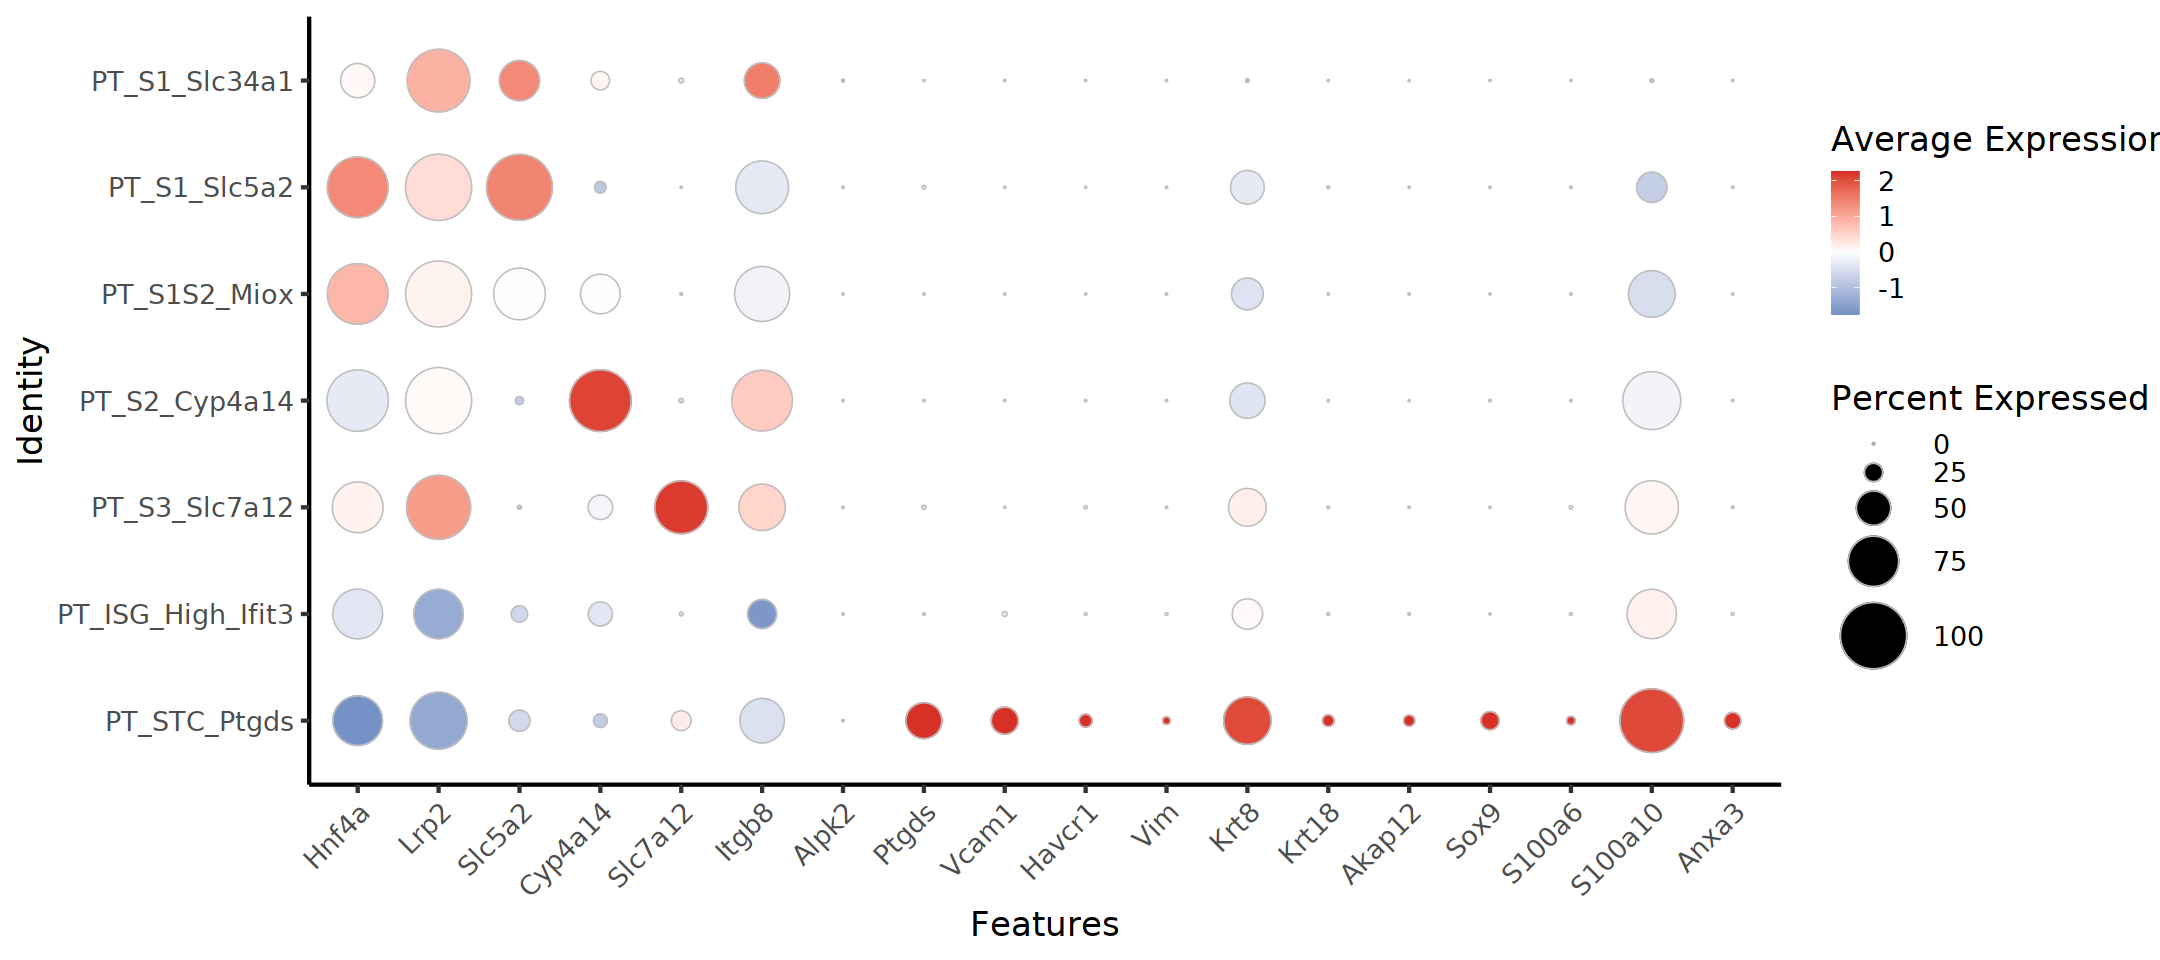

In [39]:
options(repr.plot.width=18, repr.plot.height=8)

Idents(seur_stc) = factor(Idents(seur_stc), levels = rev(levels(Idents(seur_stc))))

DotPlot(seur_stc, features = c("Hnf4a","Lrp2","Slc5a2","Cyp4a14","Slc7a12","Itgb8","Alpk2","Ptgds","Vcam1","Havcr1",'Vim',"Krt8","Krt18","Akap12","Sox9","S100a6","S100a10","Anxa3"),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_stc) = factor(Idents(seur_stc), levels = rev(levels(Idents(seur_stc))))

ggsave("Manuscript_Figures/SuppFig8_STC_DotPlot_wZhangMarkers_Repo.pdf", width = 18, height = 8)

### 5. UMAPs of CD8+ T cells, dotplots of key phenotypic markers, exhaustion markers/inhibitory receptors, and cytoxic effector molecules, and cytokines

In [40]:
seur = readRDS("Manuscript_Objects/NormalKidney_CrelessTumor_SeuratObject.RDS")
seur_i = readRDS(file = "Manuscript_Objects/Immune_SeuratObject.RDS")
Idents(seur_i) = factor(Idents(seur_i), levels = c("CD8_T_cell","NKT","NK","gd_T_cell","T_Helper","T_reg","Plasma_cell","Macrophage","MDSC","Monocyte","cDC","pDC","Neutrophil","LowQual"))
seur_i = subset(seur_i, idents = "LowQual", invert = T)

In [41]:
Idents(seur_i) = "Annot_Imm_1_Cycling_ISG_Resolved_Granular"

Centering and scaling data matrix

PC_ 1 
Positive:  Pclaf, Nusap1, Birc5, Spc24, Top2a, Mki67, Stmn1, Knl1, Hist1h3c, Rrm2 
	   Esco2, Ccna2, Tpx2, Cdca3, Cenpf, Kif11, Hist1h1b, Cdca8, Cdk1, Hmmr 
	   Cks1b, Kif15, Mxd3, Hist1h2ae, Ube2c, Hist1h2ap, Hist1h2ab, Ccnb2, Prc1, Aurkb 
Negative:  Rps18, Rpl13, Rpl23, Rplp1, Rpl32, Rps28, Rps7, Rps8, Rps12, Rpl36a 
	   Gm42418, Ccl5, Rpl15, Rpl23a, Eef1b2, Rpl10, Rps19, Rplp0, Rpsa, Il7r 
	   Cd8b1, Rps26, Rpl41, Rps2, Rps20, Ccr7, Pik3ip1, Ccnd2, Sell, Lef1 
PC_ 2 
Positive:  Klf2, Sell, Ccr7, S1pr1, Lef1, Il7r, Slamf6, Klf3, Dapl1, Cmah 
	   Tcf7, mt-Atp6, Nsg2, Il6ra, Emb, Satb1, mt-Co2, mt-Co3, Atp1b3, Sh3bp5 
	   Actn1, Arl5c, Rplp0, Tdrp, Tsc22d3, Pde2a, Igfbp4, Tmem108, Ripor2, Rasgrp2 
Negative:  Xcl1, Cxcr6, Itga1, Cd3g, Fcer1g, Cd7, Rgs1, Ctsw, AW112010, Itgae 
	   Cd244a, Fgl2, Tyrobp, Gzmb, Cish, Cd160, S100a6, Klrb1a, Isg20, Tcrg-C2 
	   Tnfsf10, AU020206, Car2, Trgv2, Chn2, Bcl2, Jaml, Lat2, Id2, Cited4 
PC_ 3 
Positive:  Ccl5

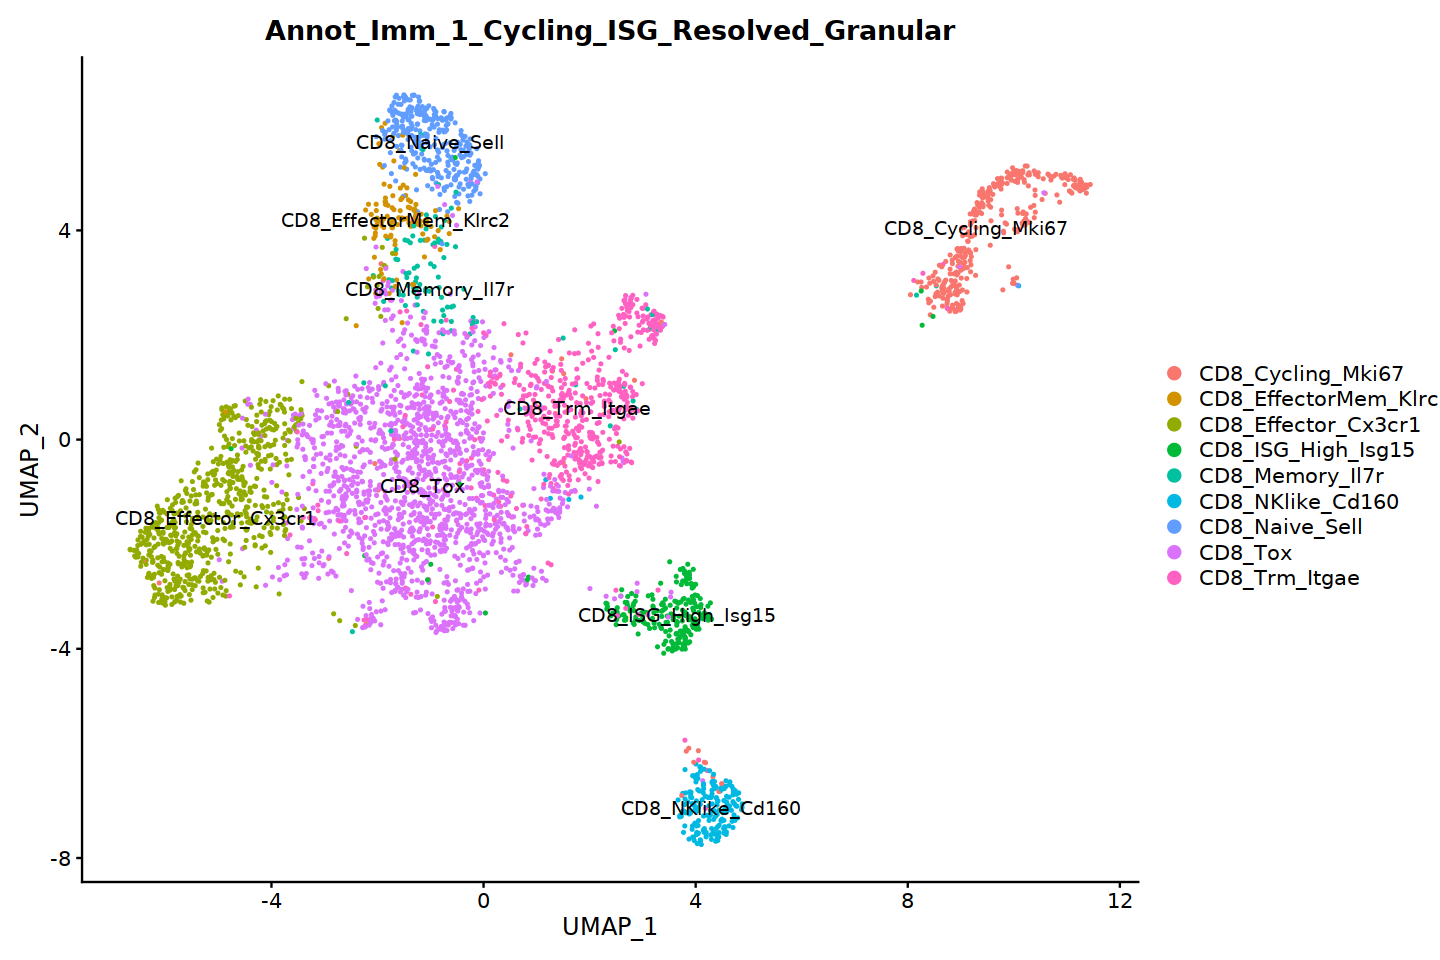

In [42]:
options(repr.plot.width=12, repr.plot.height=8)

seur_cd8_plot = subset(seur_i, idents = c("CD8_Cycling_Mki67","CD8_EffectorMem_Klrc2","CD8_Effector_Cx3cr1","CD8_ISG_High_Isg15","CD8_NKlike_Cd160","CD8_Naive_Sell","CD8_Memory_Il7r","CD8_Tox","CD8_Trm_Itgae"))
seur_cd8_plot <- NormalizeData(seur_cd8_plot)
seur_cd8_plot <- FindVariableFeatures(seur_cd8_plot, selection.method = "vst",nfeatures = 3000)
seur_cd8_plot <- ScaleData(seur_cd8_plot, features = row.names(seur_cd8_plot))
seur_cd8_plot <- RunPCA(seur_cd8_plot, npcs = 30,verbose = T)
seur_cd8_plot <- RunHarmony(seur_cd8_plot, group.by.vars = "Sample")
seur_cd8_plot <- RunUMAP(seur_cd8_plot, reduction = "harmony", dims = 1:30)
#seur_cd8_plot <- FindNeighbors(seur_cd8_plot, reduction = "harmony", dims = 1:30)
#seur_cd8_plot <- FindClusters(seur_cd8_plot, resolution = 0.5)
DimPlot(seur_cd8_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular")

In [43]:
Idents(seur_cd8_plot) = factor(Idents(seur_cd8_plot), levels = c("CD8_Effector_Cx3cr1","CD8_Tox","CD8_ISG_High_Isg15","CD8_Trm_Itgae","CD8_NKlike_Cd160","CD8_Cycling_Mki67","CD8_Memory_Il7r","CD8_EffectorMem_Klrc2","CD8_Naive_Sell"))
seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular = factor(seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular, levels = c("CD8_Effector_Cx3cr1","CD8_Tox","CD8_ISG_High_Isg15","CD8_Trm_Itgae","CD8_NKlike_Cd160","CD8_Cycling_Mki67","CD8_Memory_Il7r","CD8_EffectorMem_Klrc2","CD8_Naive_Sell"))


In [44]:
samp_cols = readRDS("Manuscript_Objects/Sample_Colors.RDS")
samp_cols

11_VX5256_T    3_BB453_T 6_BB452_KL_T    9_VX516_T   10_VX516_N  12_VX5256_N 
   "#66C2A5"    "#FC8D62"    "#8DA0CB"    "#E78AC3"    "#A6D854"    "#FFD92F" 
5_BB452_KR_N    8_BB455_N 
   "#E5C494"    "#B3B3B3"

CD8_Effector_Cx3cr1               CD8_Tox    CD8_ISG_High_Isg15 
            "#CBEAB3"             "#58BEC0"             "#EF771C" 
        CD8_Trm_Itgae      CD8_NKlike_Cd160     CD8_Cycling_Mki67 
          "#E7695DFF"             "#BB4660"             "#BF91A8" 
      CD8_Memory_Il7r CD8_EffectorMem_Klrc2        CD8_Naive_Sell 
            "#1E7DB7"             "#7DAD32"             "#081D58"

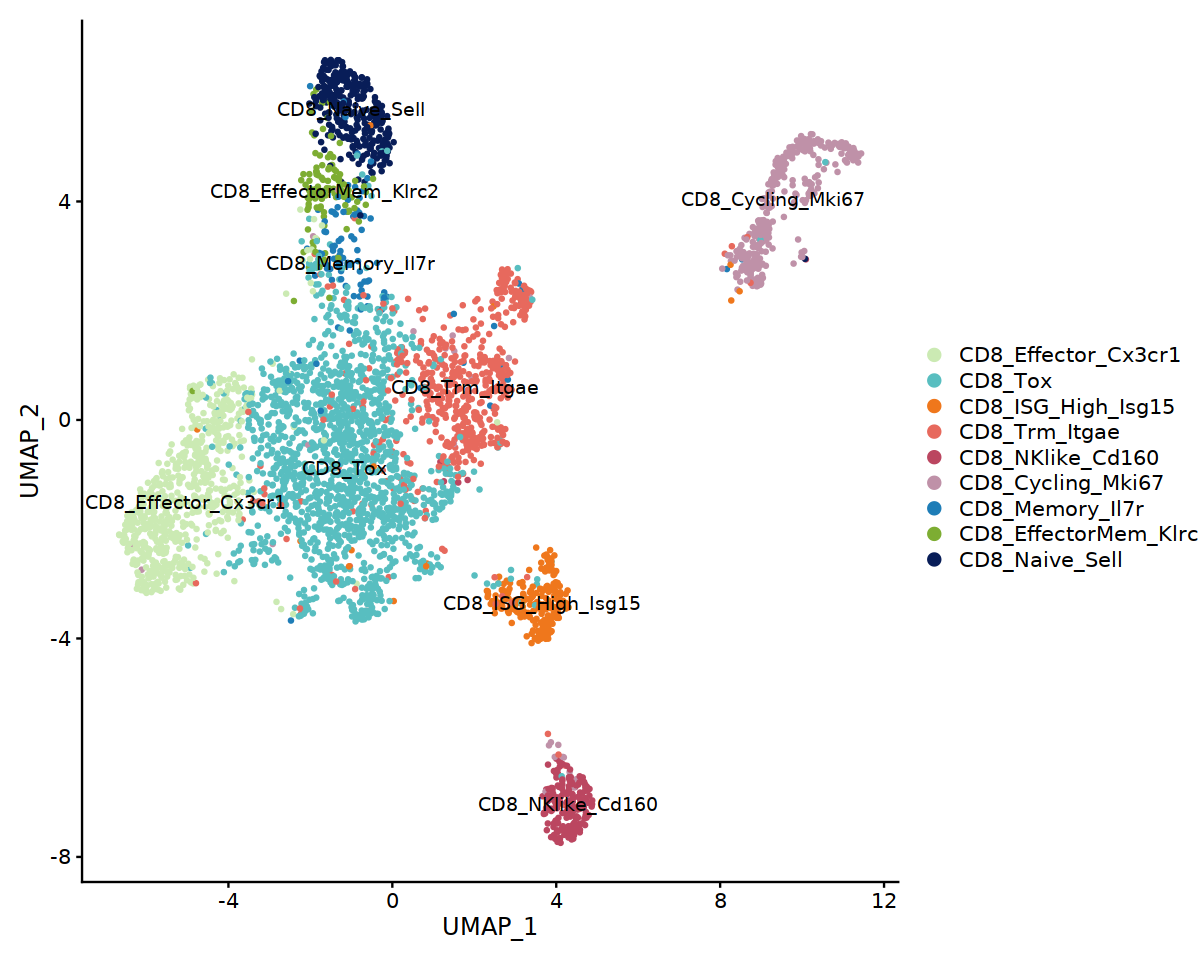

In [45]:
mycols = c(colorRampPalette(brewer.pal(9,"YlGnBu")[2:9])(9))
names(mycols) = as.character(levels(Idents(seur_cd8_plot)))

mycols["CD8_Effector_Cx3cr1"] = "#CBEAB3"
mycols["CD8_Tox"] = "#58BEC0"
mycols["CD8_Trm_Itgae"] = "#E7695DFF"
mycols["CD8_ISG_High_Isg15"] = "#EF771C"
mycols["CD8_NKlike_Cd160"] = "#BB4660"
mycols["CD8_Cycling_Mki67"] = "#BF91A8"
mycols["CD8_EffectorMem_Klrc2"] = "#7DAD32"
mycols["CD8_Memory_Il7r"] = "#1E7DB7"

mycols

options(repr.plot.width=10, repr.plot.height=8)
DimPlot(seur_cd8_plot, label = T, cols = mycols,pt.size = 0.8)

In [46]:
table(seur_cd8_plot$Sample)


  10_VX516_N  11_VX5256_T  12_VX5256_N    3_BB453_T 5_BB452_KR_N 6_BB452_KL_T 
         123         2503          300          144           64          620 
   8_BB455_N    9_VX516_T 
         123          123 

In [47]:
seur_cd8_plot$Sample = factor(seur_cd8_plot$Sample, levels = c("11_VX5256_T","3_BB453_T","6_BB452_KL_T","9_VX516_T","10_VX516_N","12_VX5256_N","5_BB452_KR_N","8_BB455_N"))


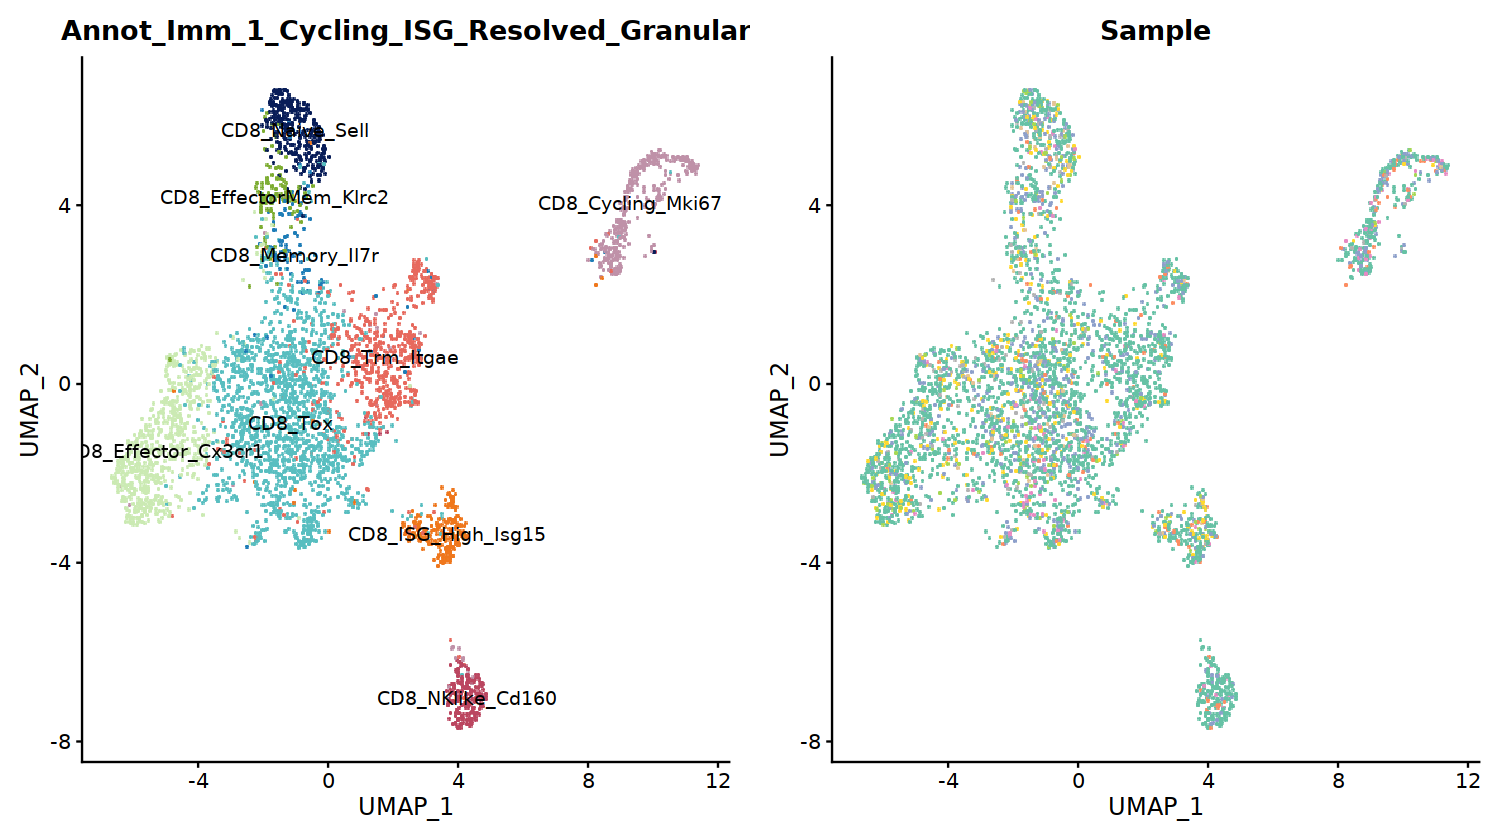

In [48]:
seur_cd8_plot$Sample = factor(seur_cd8_plot$Sample, levels = c("11_VX5256_T","3_BB453_T","6_BB452_KL_T","9_VX516_T","10_VX516_N","12_VX5256_N","5_BB452_KR_N","8_BB455_N"))

one = DimPlot(seur_cd8_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular",cols = mycols[levels(seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular)], raster = T) + NoLegend()
two = DimPlot(seur_cd8_plot, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) + NoLegend()
three = DimPlot(seur_cd8_plot, group.by = "Sample", cols = samp_cols[levels(seur_cd8_plot$Sample)],shuffle = T,raster = T) + NoLegend()

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig9_CD8_CellType_Sample_Repo.pdf", width = 12.5, height = 7)

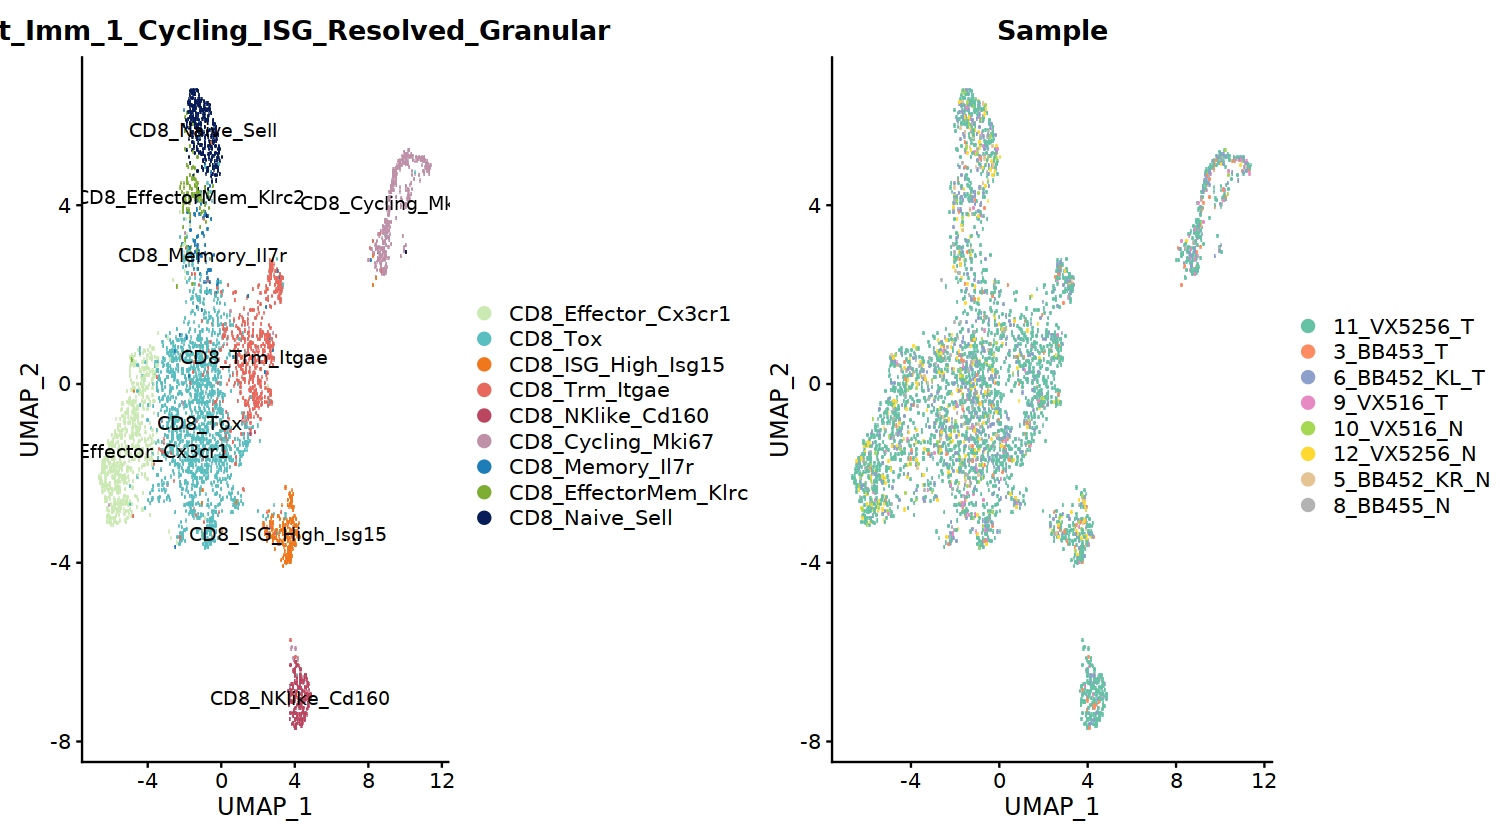

In [49]:
seur_cd8_plot$Sample = factor(seur_cd8_plot$Sample)
one = DimPlot(seur_cd8_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular",cols = mycols[levels(seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular)], raster = T) 
two = DimPlot(seur_cd8_plot, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) 
three = DimPlot(seur_cd8_plot, group.by = "Sample", cols = samp_cols[levels(seur_cd8_plot$Sample)],shuffle = T,raster = T) 

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig9_CD8_CellType_Sample_WithLegend_Repo.pdf", width = 12.5, height = 7)

In [50]:
table(seur_cd8_plot$Sample)


 11_VX5256_T    3_BB453_T 6_BB452_KL_T    9_VX516_T   10_VX516_N  12_VX5256_N 
        2503          144          620          123          123          300 
5_BB452_KR_N    8_BB455_N 
          64          123 

In [51]:
Idents(seur_cd8_plot) = factor(Idents(seur_cd8_plot), levels = c("CD8_Effector_Cx3cr1","CD8_Tox","CD8_ISG_High_Isg15","CD8_Trm_Itgae","CD8_NKlike_Cd160","CD8_Cycling_Mki67","CD8_Naive_Sell","CD8_EffectorMem_Klrc2","CD8_Memory_Il7r"))


In [52]:
seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular = Idents(seur_cd8_plot)

Var1                Var2        Freq      
1 CD8_Effector_Cx3cr1 11_VX5256_T 0.17538953
2 CD8_Tox             11_VX5256_T 0.35637235
3 CD8_ISG_High_Isg15  11_VX5256_T 0.05553336
4 CD8_Trm_Itgae       11_VX5256_T 0.16300439
5 CD8_NKlike_Cd160    11_VX5256_T 0.06272473

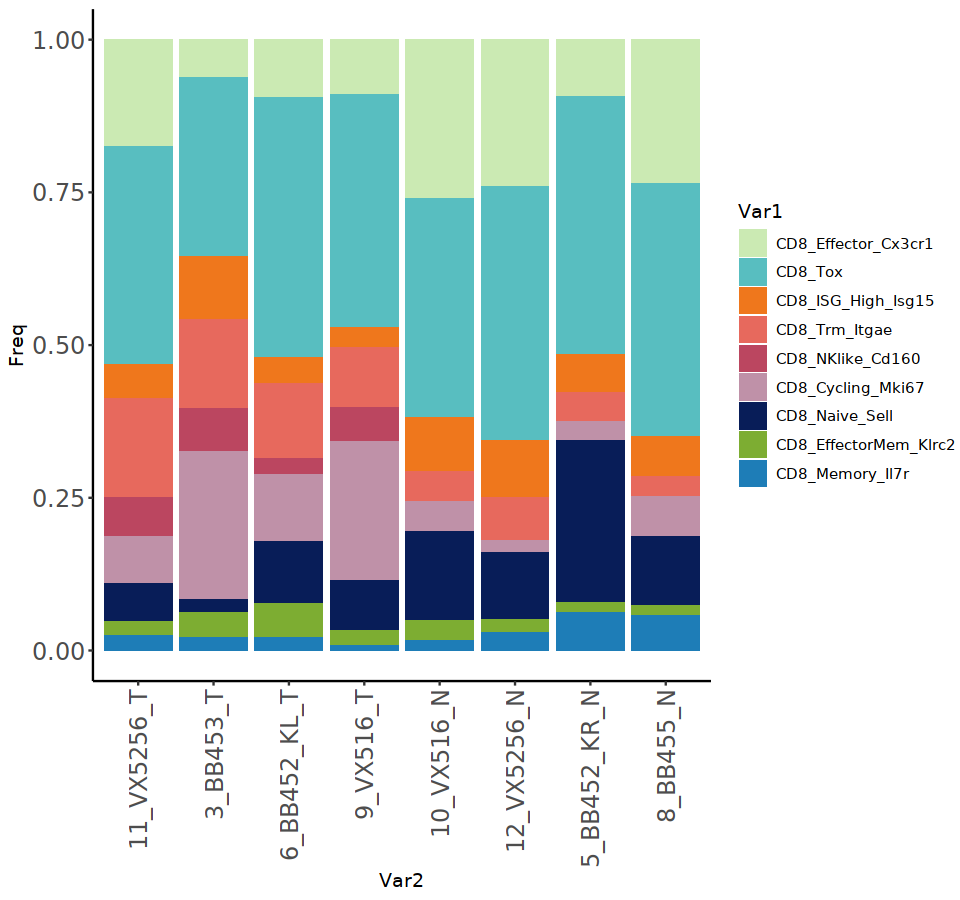

In [53]:
options(repr.plot.width=8, repr.plot.height=7.5)
props <- prop.table(table(seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular,seur_cd8_plot$Sample), margin = 2)
props <- data.frame(props)
corner(props)
ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") + theme_classic() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = mycols[levels(seur_cd8_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular)]) 


In [54]:
markers_cd8 <- FindAllMarkers(seur_cd8_plot, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, assay = "RNA",test.use = "LR",latent.vars = "Sample")
markers_cd8 %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster CD8_Effector_Cx3cr1

Calculating cluster CD8_Tox

Calculating cluster CD8_ISG_High_Isg15

Calculating cluster CD8_Trm_Itgae

Calculating cluster CD8_NKlike_Cd160

Calculating cluster CD8_Cycling_Mki67

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Calculating cluster CD8_Naive_Sell

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities n

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster              
1  7.854725e-316 2.3675558  0.954 0.333 1.875001e-311 CD8_Effector_Cx3cr1  
2  9.966171e-268 2.1000378  0.594 0.038 2.379025e-263 CD8_Effector_Cx3cr1  
3  9.652348e-225 2.1813505  0.607 0.102 2.304112e-220 CD8_Effector_Cx3cr1  
4  6.386252e-205 1.7025047  0.956 0.697 1.524462e-200 CD8_Effector_Cx3cr1  
5   4.867853e-99 2.6316411  0.438 0.112  1.162005e-94 CD8_Effector_Cx3cr1  
6  1.719040e-125 0.9300840  0.752 0.415 4.103521e-121 CD8_Tox              
7   7.278170e-79 0.7177483  0.794 0.584  1.737372e-74 CD8_Tox              
8   2.166535e-52 0.6153684  0.805 0.627  5.171735e-48 CD8_Tox              
9   1.070402e-34 0.6572723  0.397 0.251  2.555157e-30 CD8_Tox              
10  1.195673e-33 0.7422182  0.521 0.339  2.854192e-29 CD8_Tox              
11 7.070297e-231 3.6893846  0.902 0.151 1.687751e-226 CD8_ISG_High_Isg15   
12 7.555019e-213 3.0723423  0.838 0.079 1.803459e-208 CD8_ISG_High_Isg15   
13 1.409781e-181 2.8408960  0.932 0.431 3.365288e-177 CD8_ISG_High_Isg15   
14 2.093794e-181 2.9215749  0.757 0.066 4.998096e-177 CD8_ISG_High_Isg15   
15  2.625845e-61 2.8742879  0.302 0.017  6.268154e-57 CD8_ISG_High_Isg15   
16  6.391431e-60 0.9156341  0.866 0.453  1.525698e-55 CD8_Trm_Itgae        
17  2.389761e-51 0.8226448  0.739 0.360  5.704598e-47 CD8_Trm_Itgae        
18  2.009148e-50 0.7814680  0.762 0.436  4.796037e-46 CD8_Trm_Itgae        
19  4.443893e-48 0.7530885  0.808 0.500  1.060802e-43 CD8_Trm_Itgae        
20  2.245213e-41 0.8386814  0.534 0.216  5.359548e-37 CD8_Trm_Itgae        
21 3.762460e-262 4.4405953  0.974 0.084 8.981369e-258 CD8_NKlike_Cd160     
22 7.410819e-198 3.7781502  0.874 0.076 1.769037e-193 CD8_NKlike_Cd160     
23 2.618966e-176 2.8693010  0.974 0.470 6.251733e-172 CD8_NKlike_Cd160     
24  2.822430e-85 2.1605880  0.426 0.012  6.737422e-81 CD8_NKlike_Cd160     
25  5.320123e-41 2.0988181  0.758 0.380  1.269967e-36 CD8_NKlike_Cd160     
26 1.945346e-295 3.6541950  0.878 0.097 4.643734e-291 CD8_Cycling_Mki67    
27 1.123820e-255 2.7915820  0.687 0.007 2.682670e-251 CD8_Cycling_Mki67    
28 5.420024e-211 2.8607797  0.716 0.056 1.293814e-206 CD8_Cycling_Mki67    
29 6.382392e-205 3.1581983  0.742 0.083 1.523541e-200 CD8_Cycling_Mki67    
30 3.930017e-150 3.4386100  0.559 0.057 9.381345e-146 CD8_Cycling_Mki67    
31 1.037426e-240 1.9673067  0.790 0.031 2.476439e-236 CD8_Naive_Sell       
32 9.182834e-221 2.1120728  0.917 0.187 2.192034e-216 CD8_Naive_Sell       
33 1.053524e-214 1.9664414  0.869 0.057 2.514868e-210 CD8_Naive_Sell       
34 1.000751e-154 2.2497773  0.608 0.024 2.388894e-150 CD8_Naive_Sell       
35 4.686151e-154 1.7261078  0.796 0.127 1.118631e-149 CD8_Naive_Sell       
36  9.501244e-56 1.9259356  0.930 0.381  2.268042e-51 CD8_EffectorMem_Klrc2
37  2.123207e-40 1.4215710  0.704 0.164  5.068308e-36 CD8_EffectorMem_Klrc2
38  9.743936e-40 1.4675065  0.687 0.104  2.325975e-35 CD8_EffectorMem_Klrc2
39  6.062864e-37 1.2188422  0.843 0.339  1.447266e-32 CD8_EffectorMem_Klrc2
40  1.245978e-31 1.3033358  0.861 0.298  2.974275e-27 CD8_EffectorMem_Klrc2
41  3.152182e-22 1.4377900  0.762 0.302  7.524573e-18 CD8_Memory_Il7r      
42  6.807596e-12 0.6409430  0.762 0.442  1.625041e-07 CD8_Memory_Il7r      
43  4.204145e-09 0.5429709  0.842 0.571  1.003571e-04 CD8_Memory_Il7r      
44  4.240170e-07 0.5280139  0.396 0.147  1.012171e-02 CD8_Memory_Il7r      
45  4.576057e-07 0.5973155  0.703 0.389  1.092351e-02 CD8_Memory_Il7r      
   gene    
1  Klf2    
2  Cx3cr1  
3  Zeb2    
4  Lgals1  
5  Gzma    
6  Gzmk    
7  Cxcr6   
8  Ctla2a  
9  Tcrg-C2 
10 Ccl4    
11 Isg15   
12 Ifit3   
13 Bst2    
14 Ifit1   
15 Cxcl10  
16 Xcl1    
17 Itga1   
18 Cd226   
19 Inpp4b  
20 Itgae   
21 Fcer1g  
22 Tyrobp  
23 Cd7     
24 Klra1   
25 Gzmb    
26 Stmn1   
27 Pclaf   
28 Mki67   
29 Top2a   
30 Hist1h1b
31 Ccr7    
32 Lef1    
33 Sell    
34 Dapl1   
35 Satb1   
36 Il7r    
37 Satb1   
38 Sell    
39 Tcf7    
40 Ly6c2   
41 Ly6c2   
42 

In [55]:
subset(markers_cd8, cluster == "CD8_Tox" & p_val_adj < 0.001)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
Gzmk          1.719040e-125 0.9300840  0.752 0.415 4.103521e-121 CD8_Tox
Nkg71          5.394780e-86 0.4625551  0.994 0.958  1.287788e-81 CD8_Tox
AW112010       6.951297e-82 0.4421057  0.997 0.972  1.659344e-77 CD8_Tox
Cxcr6          7.278170e-79 0.7177483  0.794 0.584  1.737372e-74 CD8_Tox
Rpl13a         1.565605e-77 0.2680941  1.000 0.997  3.737256e-73 CD8_Tox
Cd3g           9.605234e-67 0.3828362  0.992 0.976  2.292865e-62 CD8_Tox
Rps15a         8.553898e-65 0.2638179  1.000 0.998  2.041901e-60 CD8_Tox
Btg1           2.988344e-54 0.4150116  0.984 0.974  7.133475e-50 CD8_Tox
Ctla2a         2.166535e-52 0.6153684  0.805 0.627  5.171735e-48 CD8_Tox
Id2            2.638869e-49 0.4680295  0.912 0.815  6.299243e-45 CD8_Tox
S100a6         2.049102e-47 0.5117681  0.930 0.823  4.891410e-43 CD8_Tox
Gimap7         3.302180e-46 0.4741468  0.860 0.757  7.882635e-42 CD8_Tox
Rgs1           1.682495e-45 0.5601636  0.739 0.565  4.016283e-41 CD8_Tox
Ccr5           2.258502e-42 0.6053648  0.483 0.327  5.391270e-38 CD8_Tox
Pdcd1          5.118496e-42 0.6057665  0.289 0.145  1.221836e-37 CD8_Tox
Tox            2.368562e-40 0.6115639  0.496 0.343  5.653996e-36 CD8_Tox
Hcst1          1.834023e-39 0.3661066  0.964 0.929  4.377997e-35 CD8_Tox
Bcl2           2.406203e-39 0.4821719  0.848 0.776  5.743848e-35 CD8_Tox
Tcrg-C2        1.070402e-34 0.6572723  0.397 0.251  2.555157e-30 CD8_Tox
Pfdn5          1.239219e-34 0.3555857  0.961 0.947  2.958140e-30 CD8_Tox
Ccl41          1.195673e-33 0.7422182  0.521 0.339  2.854192e-29 CD8_Tox
Cd3e           1.234361e-31 0.3402232  0.952 0.934  2.946543e-27 CD8_Tox
Serpina3g      4.875482e-31 0.4960162  0.521 0.378  1.163826e-26 CD8_Tox
Cd8a           3.169595e-30 0.3718719  0.839 0.746  7.566140e-26 CD8_Tox
Cxcr3          6.756263e-30 0.4467050  0.600 0.483  1.612788e-25 CD8_Tox
Trac           7.595640e-30 0.3425405  0.915 0.870  1.813155e-25 CD8_Tox
Dusp2          1.608434e-29 0.4741692  0.702 0.611  3.839492e-25 CD8_Tox
Trgv2          8.963599e-29 0.5692210  0.369 0.234  2.139701e-24 CD8_Tox
Sh2d1a1        1.444012e-26 0.4684441  0.558 0.449  3.447001e-22 CD8_Tox
Shisa5         3.594553e-26 0.2717491  0.949 0.925  8.580557e-22 CD8_Tox
...           ...           ...        ...   ...   ...           ...    
Eomes1        1.323167e-24  0.4313328  0.378 0.248 3.158532e-20  CD8_Tox
2410006H16Rik 5.451837e-24  0.4604947  0.674 0.629 1.301408e-19  CD8_Tox
Mbnl1         5.907095e-24  0.2891778  0.972 0.971 1.410083e-19  CD8_Tox
S100a11       1.199459e-23  0.3363110  0.901 0.841 2.863229e-19  CD8_Tox
Mxd4          4.366889e-23  0.3895075  0.590 0.494 1.042420e-18  CD8_Tox
Camk2n1       5.436929e-21  0.3848508  0.387 0.298 1.297849e-16  CD8_Tox
Adam19        1.185182e-20  0.3705718  0.436 0.350 2.829147e-16  CD8_Tox
Fasl          1.877704e-19  0.3446276  0.479 0.395 4.482267e-15  CD8_Tox
Gng2          2.157334e-19  0.3746842  0.618 0.553 5.149772e-15  CD8_Tox
Cish          1.139650e-18  0.3421339  0.502 0.411 2.720458e-14  CD8_Tox
Ucp2          5.730832e-17  0.3450273  0.791 0.764 1.368007e-12  CD8_Tox
Pmepa1        8.682941e-17  0.3767281  0.440 0.380 2.072705e-12  CD8_Tox
Ptpn22        1.052693e-16  0.3030622  0.764 0.729 2.512883e-12  CD8_Tox
Trbc1         1.461714e-16  0.5109351  0.661 0.607 3.489257e-12  CD8_Tox
Lax1          8.086941e-16  0.3314638  0.378 0.321 1.930434e-11  CD8_Tox
Sh2d2a        1.652961e-15  0.3510736  0.536 0.486 3.945783e-11  CD8_Tox
Zfp36l2       2.117611e-13  0.3050743  0.810 0.789 5.054949e-09  CD8_Tox
Ypel3         6.443469e-13  0.2840617  0.610 0.571 1.538121e-08  CD8_Tox
Ndfip1        1.411237e-12  0.2686251  0.801 0.789 3.368765e-08  CD8_Tox
Casp1         4.788812e-12  0.2685359  0.353 0.278 1.143137e-07  CD8_Tox
Ikzf3         5.873096e-12  0.3112315  0.525 0.497 1.401967e-07  CD8_Tox
Pstpip1       2.751642e-11  0.2726026  0.444 0.410 6.568446e-07  CD8_Tox
Fth1          2.046189e-10  0.2700699  0.903 0.889 4.884458e-06  CD8_Tox

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



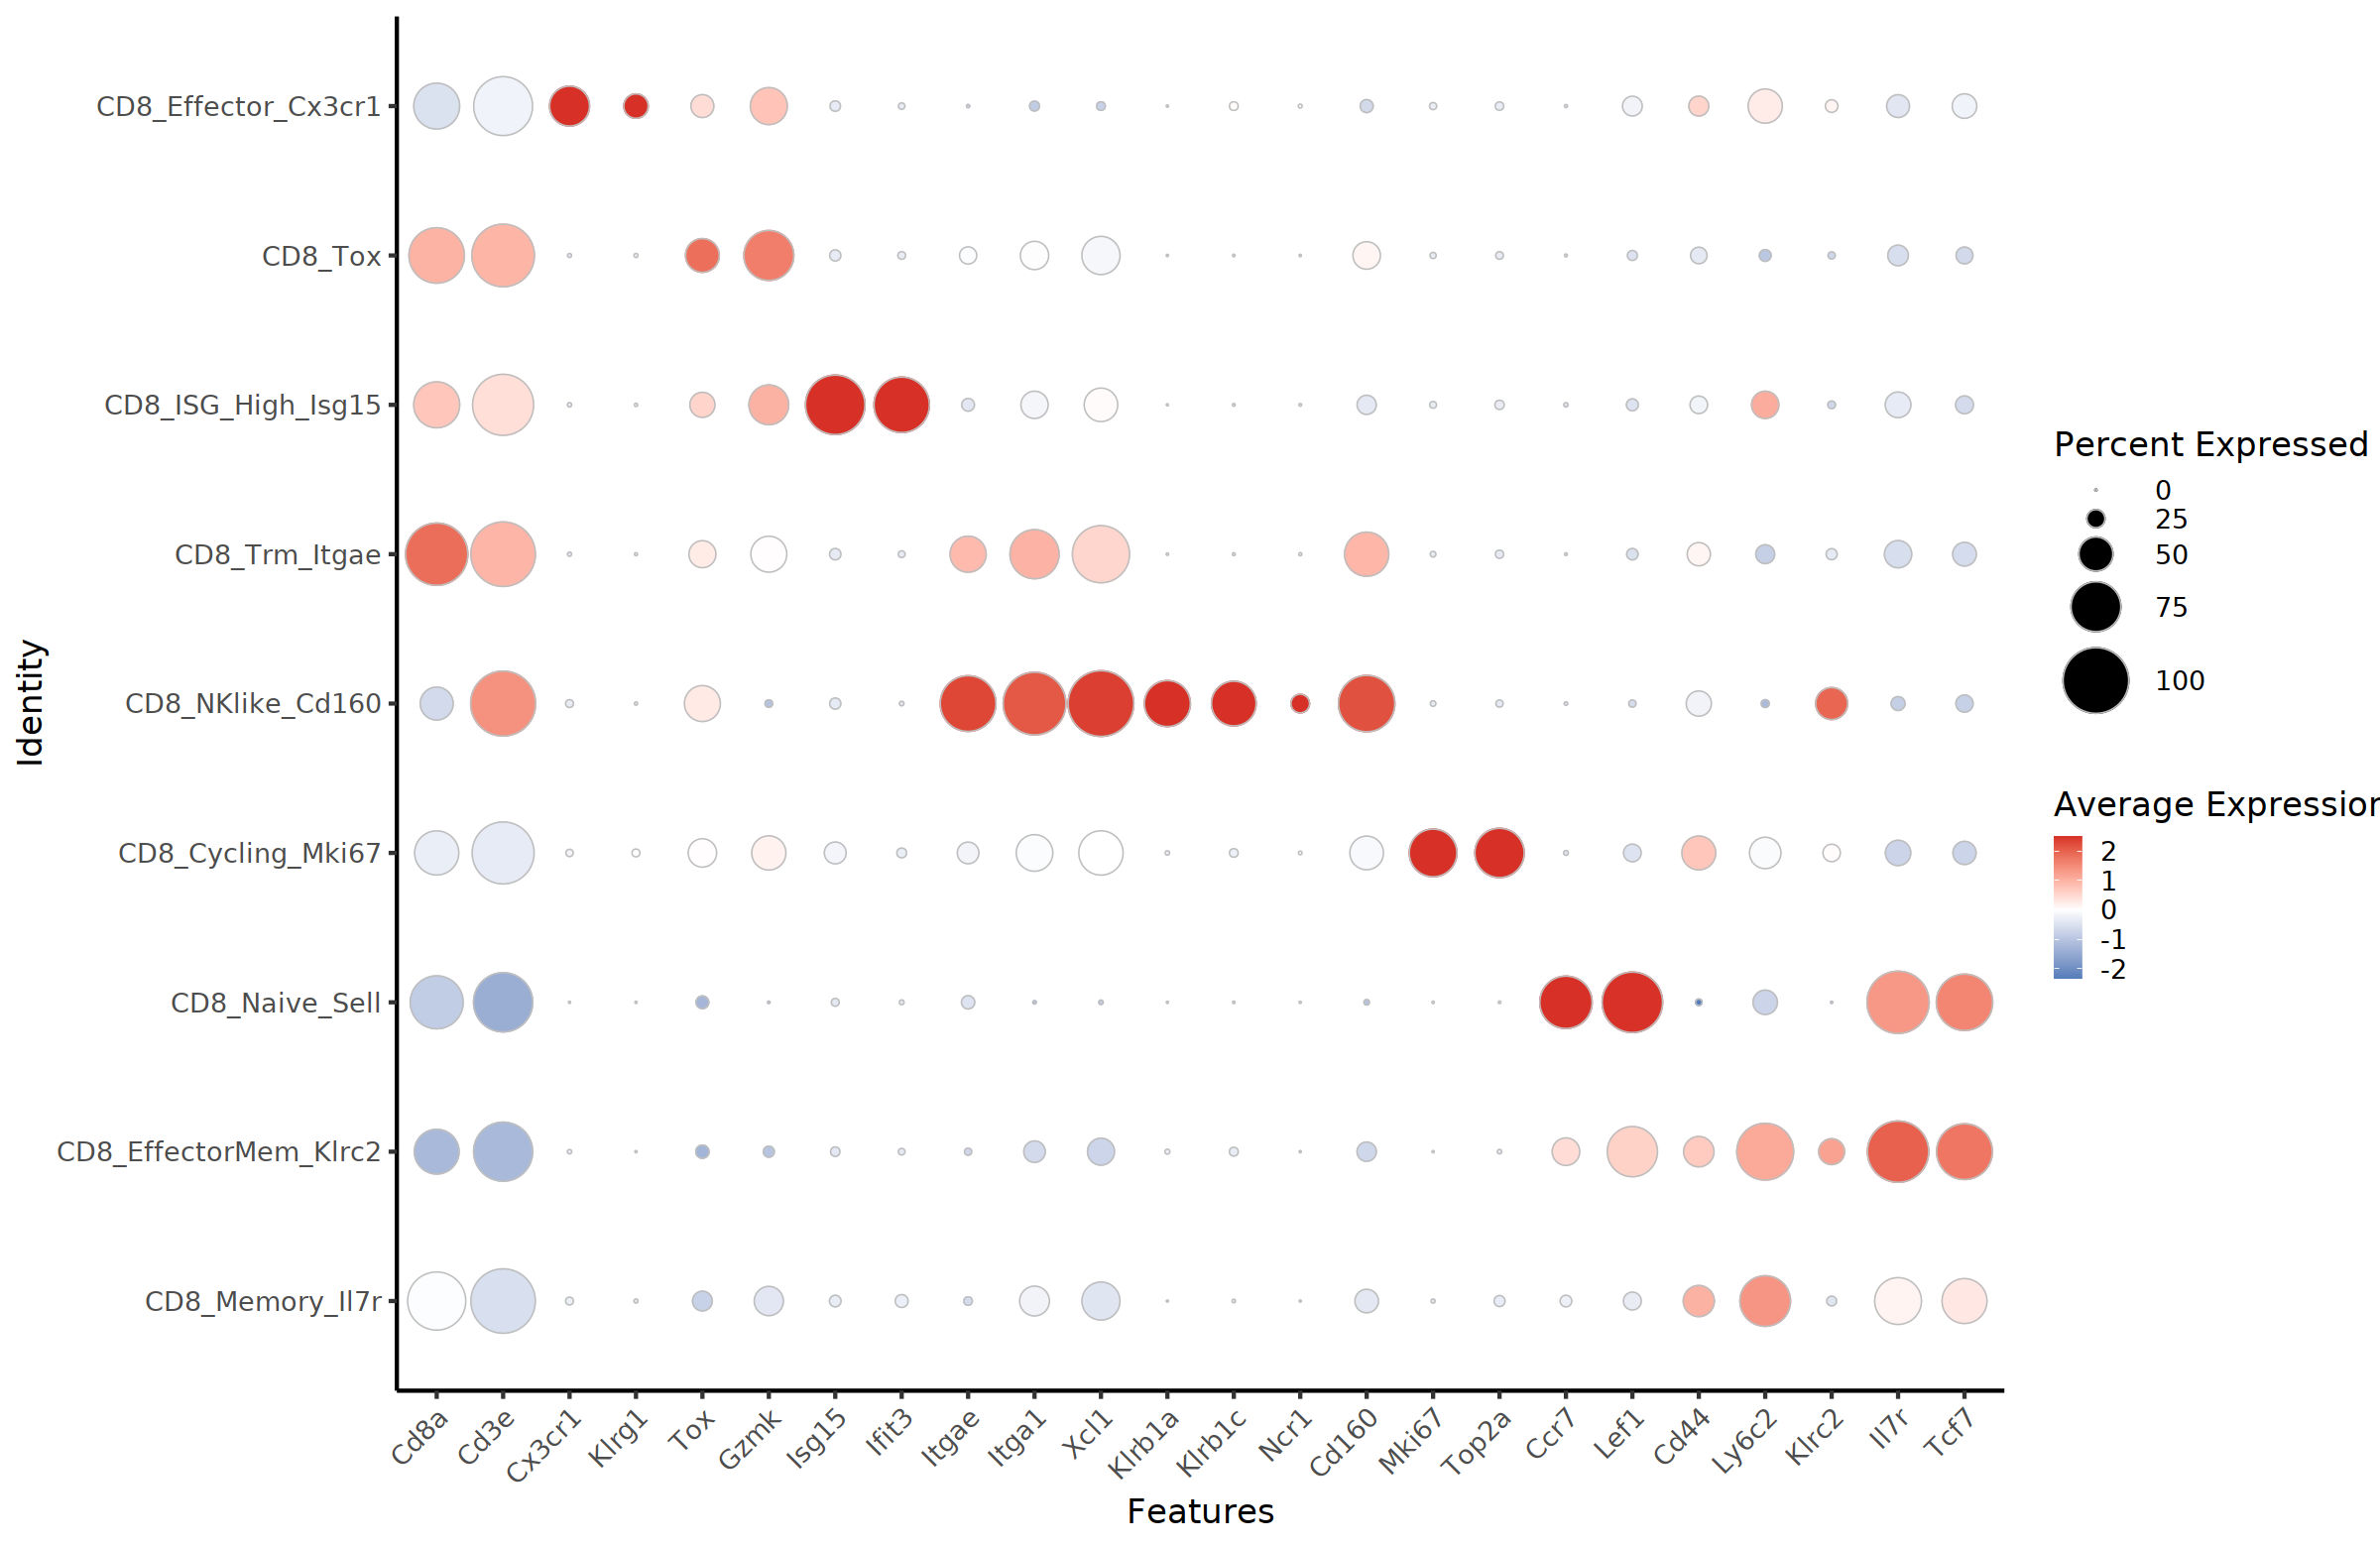

In [56]:
options(repr.plot.width=20, repr.plot.height=13)

Idents(seur_cd8_plot) = factor(Idents(seur_cd8_plot), levels = rev(levels(Idents(seur_cd8_plot))))

DotPlot(seur_cd8_plot, features = c("Cd8a","Cd3e","Cx3cr1","Klrg1","Tox","Gzmk","Isg15","Ifit3","Itgae","Itga1","Xcl1","Klrb1a","Klrb1c","Ncr1","Cd160","Mki67","Top2a","Ccr7","Lef1","Cd44","Ly6c2","Klrc2","Il7r","Tcf7"),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_cd8_plot) = factor(Idents(seur_cd8_plot), levels = rev(levels(Idents(seur_cd8_plot))))

ggsave("Manuscript_Figures/SuppFig9_CD8_DotPlot_Repo.pdf", width = 20, height = 13)

In [57]:
exh = c("Tox","Pdcd1","Havcr2","Lag3","Tigit","Ctla4","Entpd1","Cd160","Btla")
kill = c("Gzma","Gzmb","Gzmh","Gzmk","Prf1","Nkg7","Fasl","Tnf")
cyto = c("Ifng","Il2","Ccl3","Ccl4","Ccl5")

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
"The following requested variables were not found: Gzmh"
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



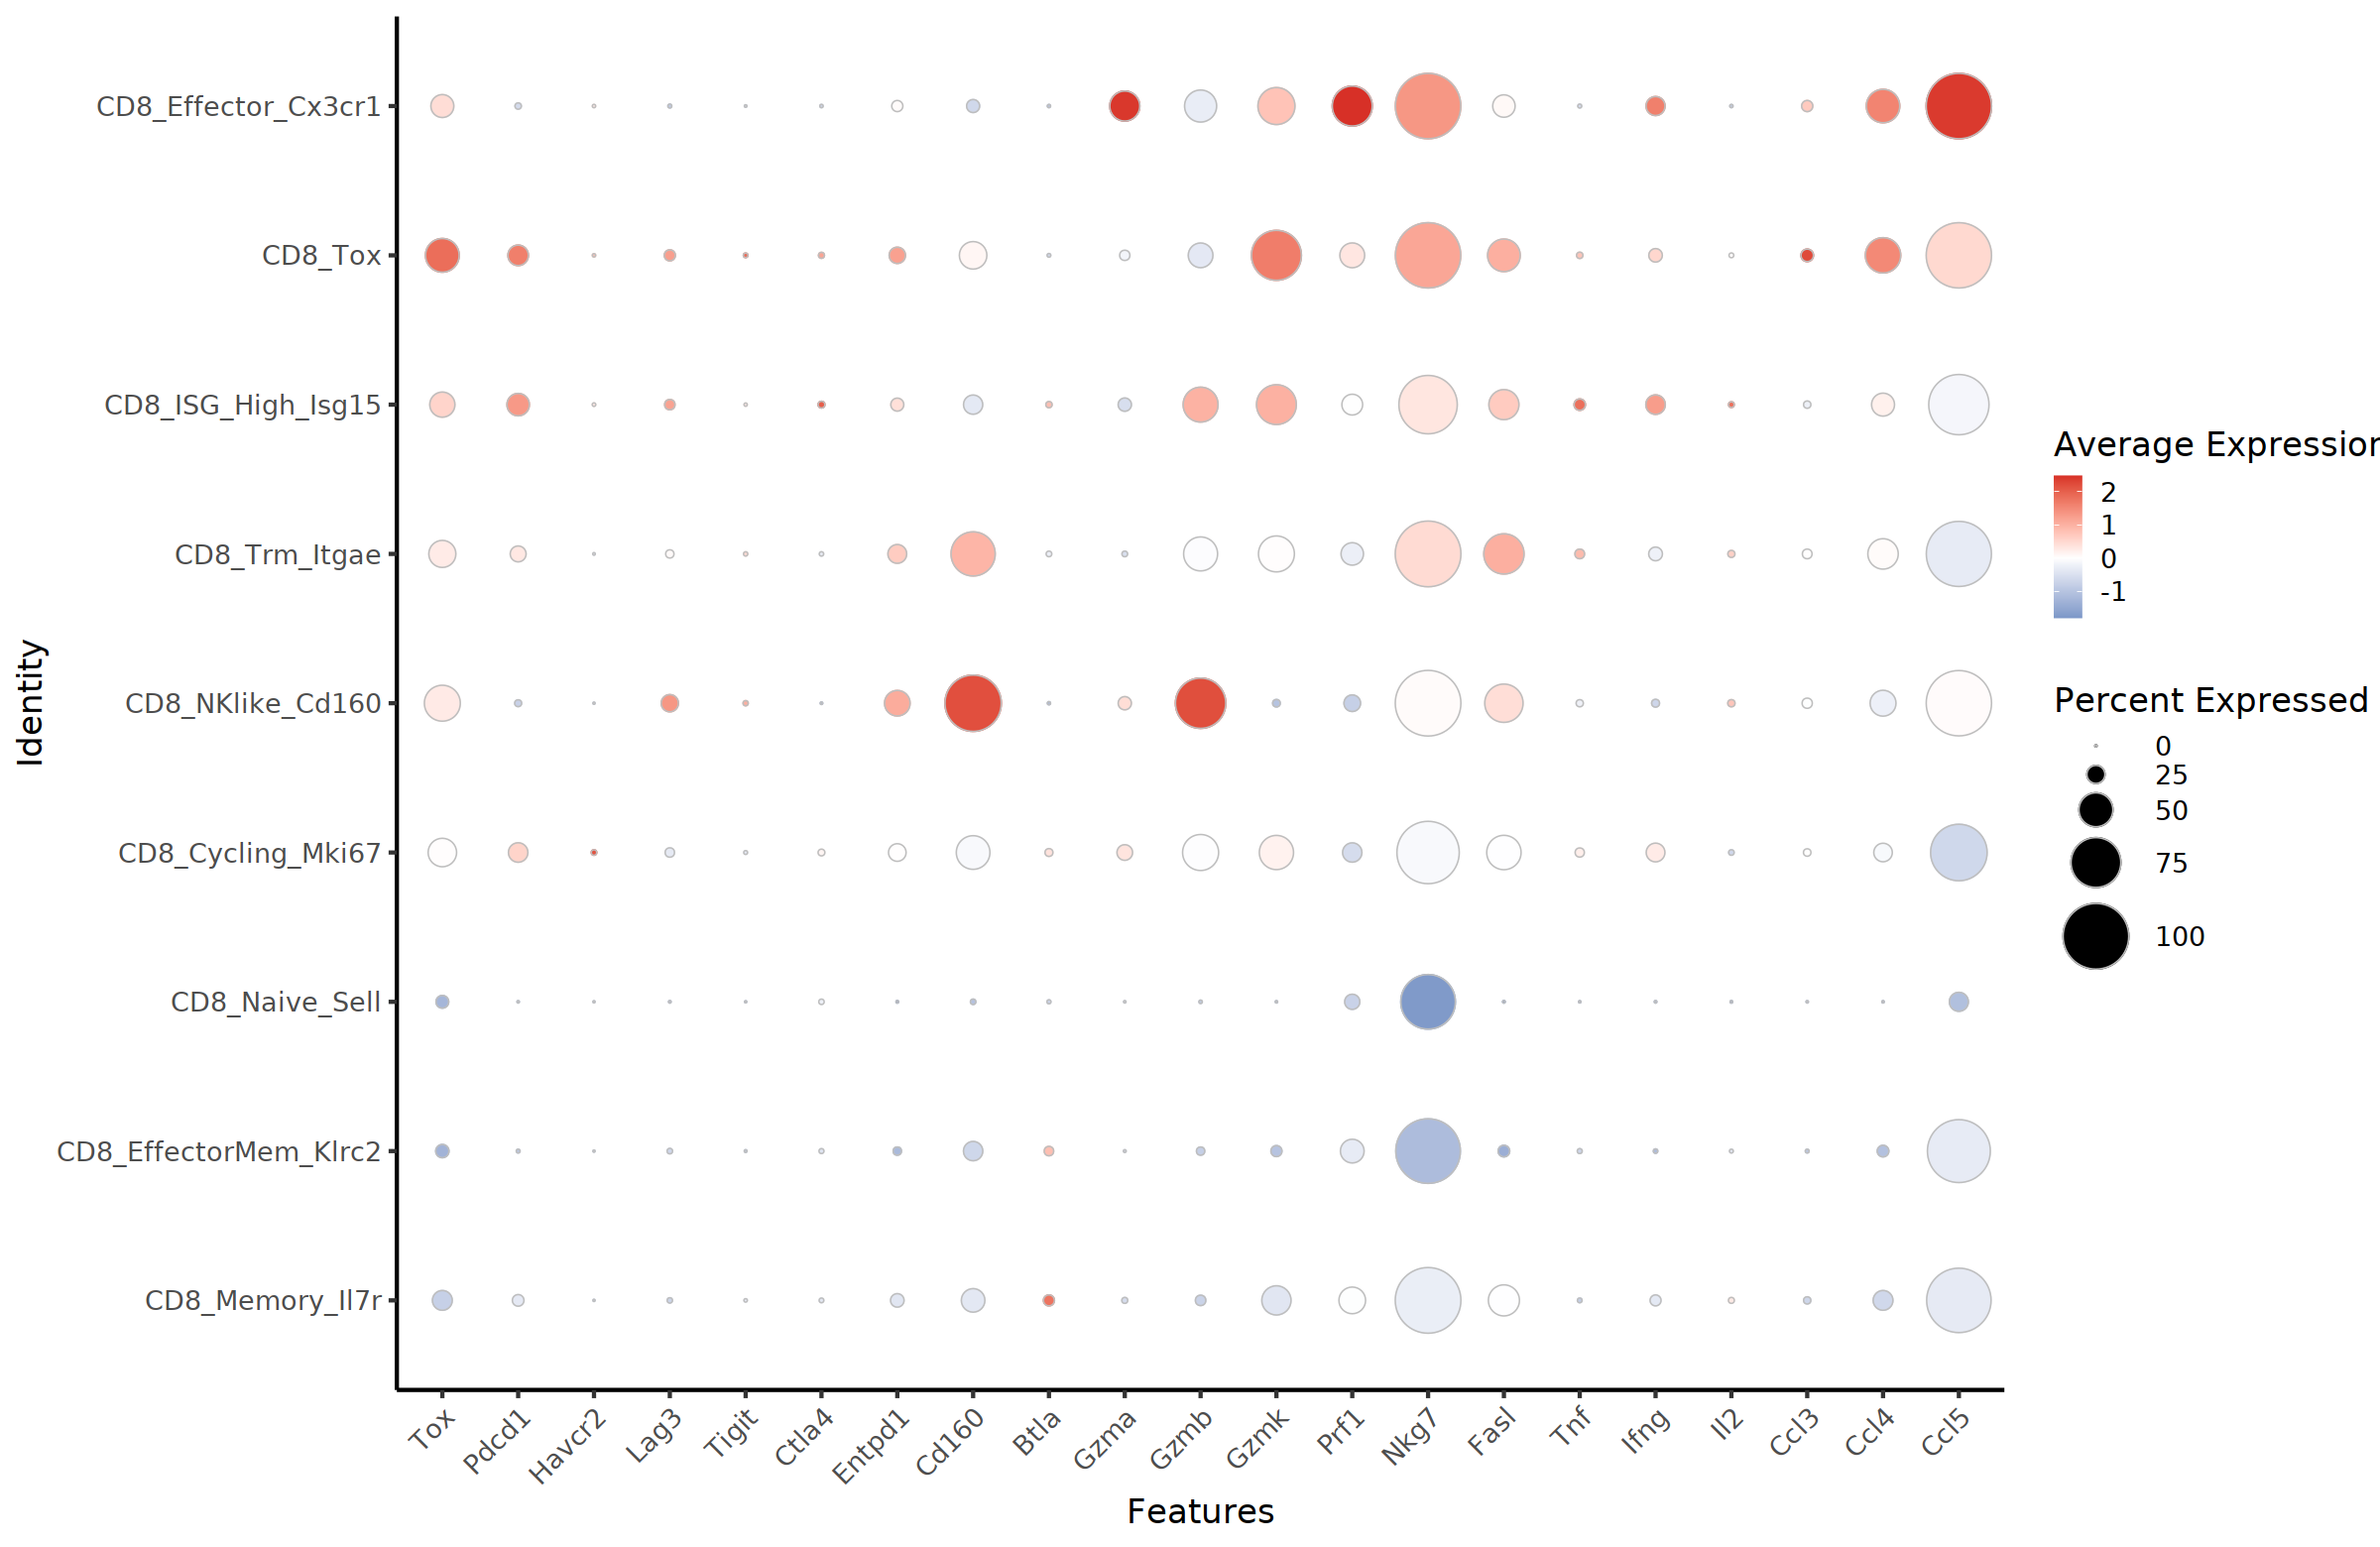

In [58]:
options(repr.plot.width=20, repr.plot.height=13)

Idents(seur_cd8_plot) = factor(Idents(seur_cd8_plot), levels = rev(levels(Idents(seur_cd8_plot))))

DotPlot(seur_cd8_plot, features = c(exh,kill,cyto),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_cd8_plot) = factor(Idents(seur_cd8_plot), levels = rev(levels(Idents(seur_cd8_plot))))

ggsave("Manuscript_Figures/SuppFig9_CD8_DotPlot_ExhCyto_Repo.pdf", width = 20, height = 13)

### 6. UMAPs of myeloid cells, dotplot of key phenotypic markers

In [59]:
seur = readRDS("Manuscript_Objects/NormalKidney_CrelessTumor_SeuratObject.RDS")
seur_i = readRDS(file = "Manuscript_Objects/Immune_SeuratObject.RDS")
Idents(seur_i) = factor(Idents(seur_i), levels = c("CD8_T_cell","NKT","NK","gd_T_cell","T_Helper","T_reg","Plasma_cell","Macrophage","MDSC","Monocyte","cDC","pDC","Neutrophil","LowQual"))
seur_i = subset(seur_i, idents = "LowQual", invert = T)

In [60]:
Idents(seur_i) = "Annot_Imm_1_Cycling_ISG_Resolved_Granular"

Centering and scaling data matrix

PC_ 1 
Positive:  Gsr, S100a11, Pglyrp1, Hp, S100a6, Cytip, Plac8, Il1b, Napsa, S100a8 
	   S100a9, Ifitm6, Cxcr2, Neat1, Gpr141, Itgal, Rara, Pim1, Slpi, Dusp1 
	   Csf3r, Itga4, Nr4a1, Ltb, Sell, Mcemp1, Mmp9, Lyst, Gda, Ace 
Negative:  C1qc, C1qb, C1qa, Pmepa1, Trem2, Cd81, Hexb, Lgmn, Grn, Ms4a7 
	   Apoe, Tuba1b, Stmn1, Atpif1, Fcrls, Stab1, Olfml3, Cd63, Itgb5, Timp2 
	   Ctss, Lgals1, Prdx1, Ctsz, Mki67, Top2a, Hmgn1, Tubb5, Cxcl16, C3ar1 
PC_ 2 
Positive:  Top2a, Pclaf, Nusap1, Mki67, Hist1h1b, Kif11, Birc5, Prc1, Knl1, Spc24 
	   Ccna2, Esco2, Cdca3, Kif15, Cenpf, Cdca8, Tpx2, Pbk, Hmgb2, Cdk1 
	   Hist1h3c, Cenpe, Stmn1, Ckap2l, Hist1h2ae, Hmmr, Aurkb, Spc25, Ube2c, Bub1b 
Negative:  Apoe, Cd63, Ctsd, Ms4a7, Trem2, C1qc, C1qa, C1qb, C3ar1, Timp2 
	   Fth1, Lgmn, Ctsb, Ftl1, Mafb, Igf1, Abca1, Stab1, Hexb, Trf 
	   Anxa3, Cd81, Selenop, Ctsz, Itgb5, Ctss, Tmem37, Bhlhe41, Grn, Pmepa1 
PC_ 3 
Positive:  Clec4d, Ninj1, Adam8, Txn1, S100a8, Grin

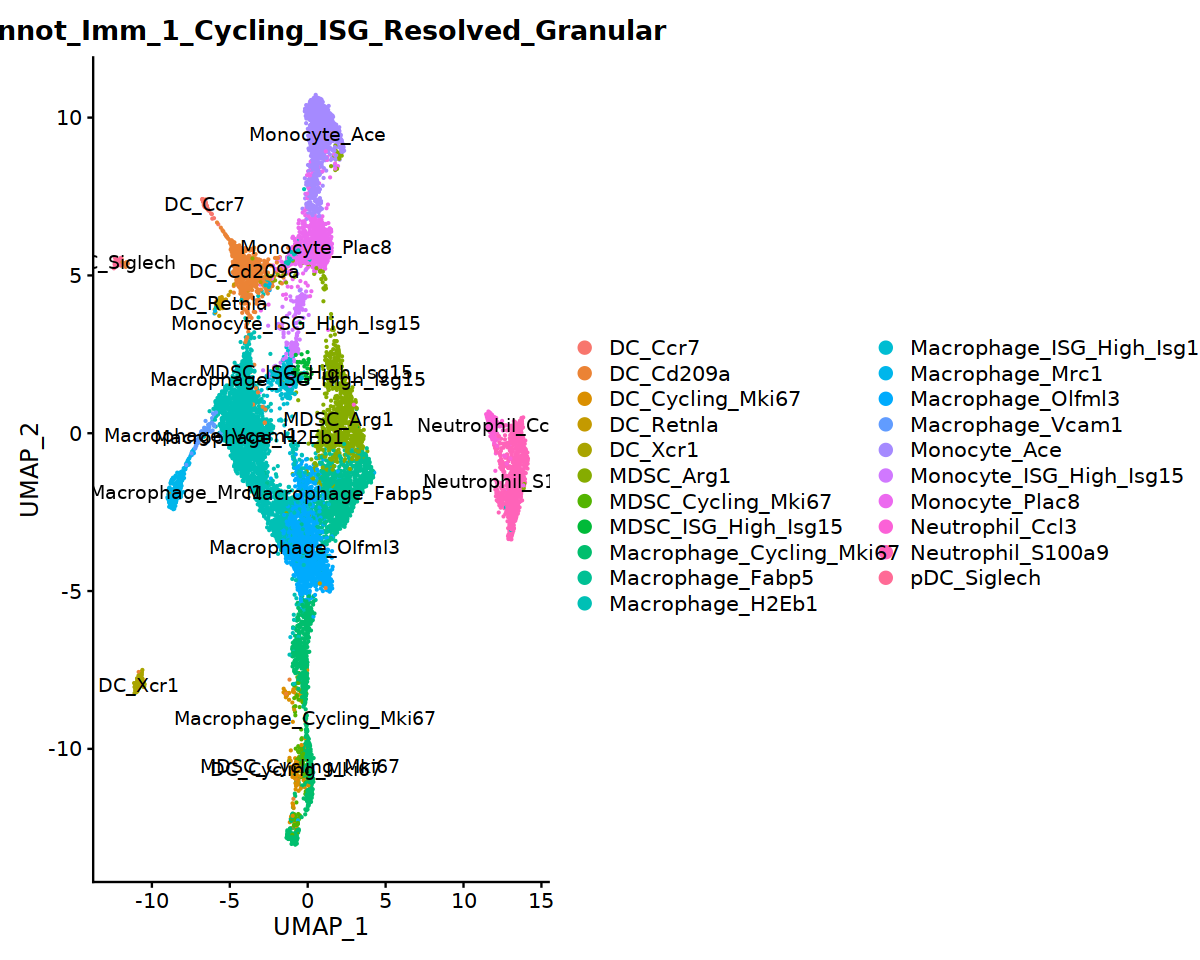

In [61]:
options(repr.plot.width=10, repr.plot.height=8)

seur_myl_plot = subset(seur_i, idents = c("DC_Ccr7","DC_Cd209a","DC_Cycling_Mki67","DC_Retnla","DC_Xcr1","MDSC_Arg1","MDSC_Cycling_Mki67","MDSC_ISG_High_Isg15","Macrophage_Cycling_Mki67","Macrophage_Fabp5","Macrophage_H2Eb1","Macrophage_ISG_High_Isg15","Macrophage_Mrc1","Macrophage_Olfml3","Macrophage_Vcam1","Monocyte_Ace","Monocyte_ISG_High_Isg15","Monocyte_Plac8","Neutrophil_Ccl3","Neutrophil_S100a9","pDC_Siglech"))
seur_myl_plot <- NormalizeData(seur_myl_plot)
seur_myl_plot <- FindVariableFeatures(seur_myl_plot, selection.method = "vst",nfeatures = 3000)
seur_myl_plot <- ScaleData(seur_myl_plot, features = row.names(seur_myl_plot))
seur_myl_plot <- RunPCA(seur_myl_plot, npcs = 30,verbose = T)
seur_myl_plot <- RunHarmony(seur_myl_plot, group.by.vars = "Sample")
seur_myl_plot <- RunUMAP(seur_myl_plot, reduction = "harmony", dims = 1:30)
#seur_myl_plot <- FindNeighbors(seur_myl_plot, reduction = "harmony", dims = 1:30)
#seur_myl_plot <- FindClusters(seur_myl_plot, resolution = 0.5)
DimPlot(seur_myl_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular")

In [62]:
Idents(seur_myl_plot) = factor(Idents(seur_myl_plot), levels = c("Macrophage_H2Eb1","Macrophage_Olfml3","Macrophage_Fabp5","Macrophage_Mrc1","Macrophage_Vcam1","Macrophage_Cycling_Mki67","Macrophage_ISG_High_Isg15","MDSC_Arg1","MDSC_Cycling_Mki67","MDSC_ISG_High_Isg15","Monocyte_Plac8","Monocyte_Ace","Monocyte_ISG_High_Isg15","DC_Cd209a","DC_Xcr1","DC_Ccr7","DC_Retnla","DC_Cycling_Mki67","pDC_Siglech","Neutrophil_S100a9","Neutrophil_Ccl3"))


Macrophage_H2Eb1         Macrophage_Olfml3          Macrophage_Fabp5 
                "#08306B"                 "#2171B5"                 "#4292C6" 
          Macrophage_Mrc1          Macrophage_Vcam1  Macrophage_Cycling_Mki67 
                "#6BAED6"                 "#9ECAE1"                 "#C6DBEF" 
Macrophage_ISG_High_Isg15                 MDSC_Arg1        MDSC_Cycling_Mki67 
                "#DEEBF7"                 "#D4B9DA"                 "#CE1256" 
      MDSC_ISG_High_Isg15            Monocyte_Plac8              Monocyte_Ace 
                "#DF65B0"                 "#FC9272"                 "#EF3B2C" 
  Monocyte_ISG_High_Isg15                 DC_Cd209a                   DC_Xcr1 
                "#FEE0D2"                 "#238B45"                 "#41AB5D" 
                  DC_Ccr7                 DC_Retnla          DC_Cycling_Mki67 
                "#74C476"                 "#A1D99B"                 "#C7E9C0" 
              pDC_Siglech         Neutrophil_S100a9           Neutrophil_Ccl3 
                "#E5F5E0"                 "#9C7D75"                   "black"

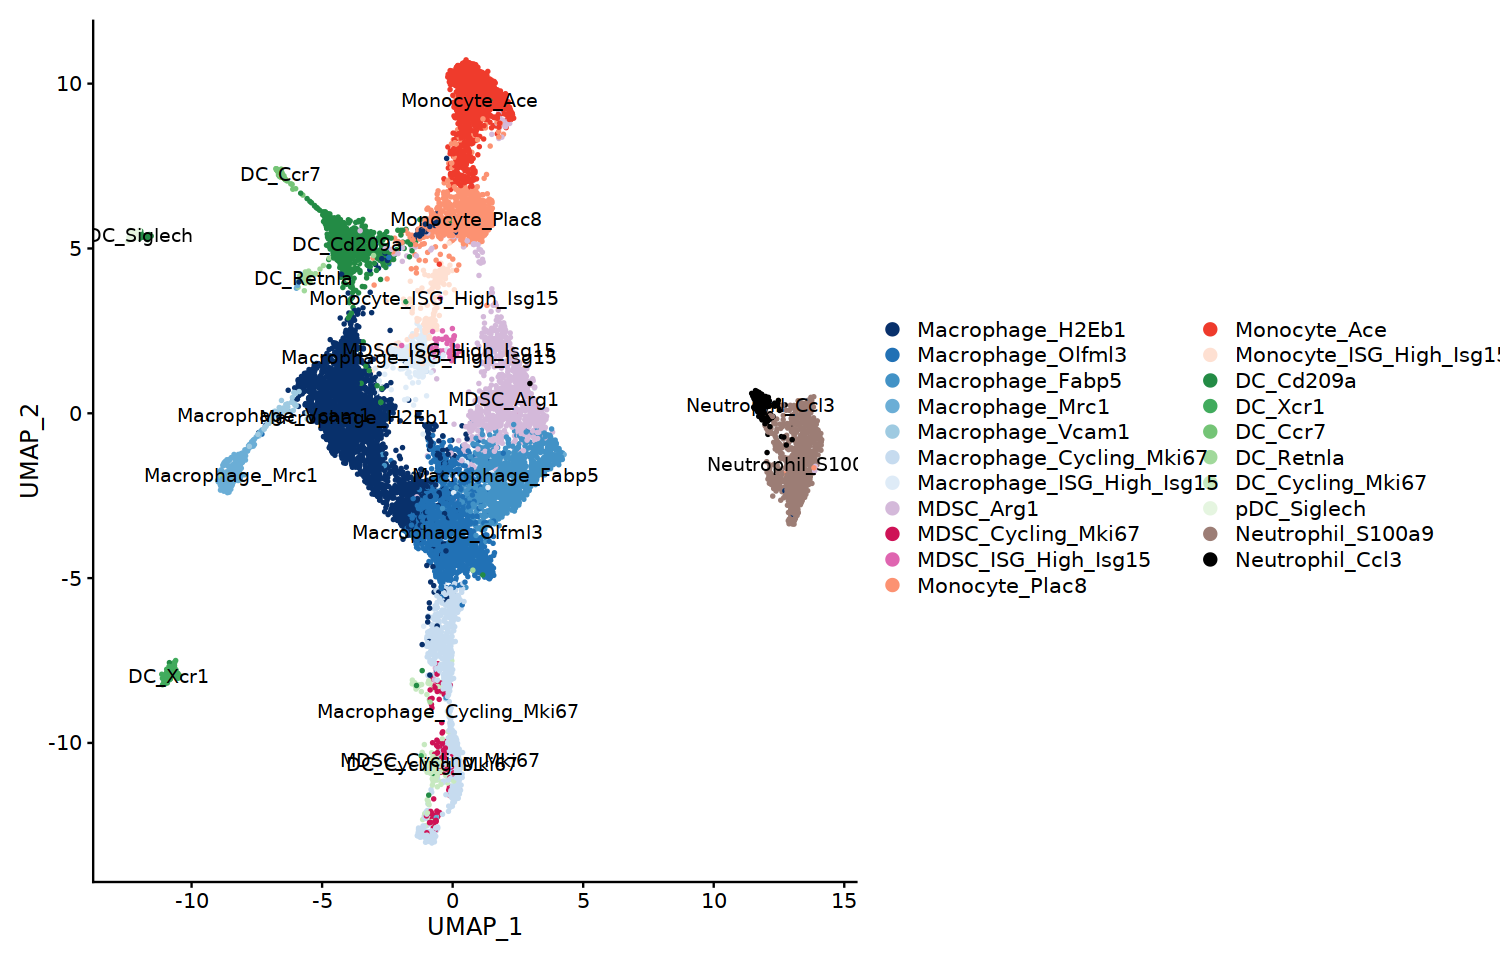

In [63]:
mac_cols = rev(brewer.pal(name = "Blues",9)[c(2,3,4,5,6,7,9)])
mono_cols = brewer.pal(name = "Reds",9)[c(4,6,2)]

mdsc_cols = brewer.pal(name = "PuRd",9)[c(3,7,5)]

dc_cols = rev(brewer.pal(name = "Greens",9)[c(2,3,4,5,6,7)])
neut_cols = c("#9C7D75","black")

mycols = c(mac_cols, mdsc_cols, mono_cols, dc_cols, neut_cols)
names(mycols) = as.character(levels(Idents(seur_myl_plot)))
mycols

options(repr.plot.width=12.5, repr.plot.height=8)
DimPlot(seur_myl_plot, label = T, cols = mycols,pt.size = 0.5)

In [64]:
seur_myl_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular = Idents(seur_myl_plot)

In [65]:
table(seur_myl_plot$Sample)


  10_VX516_N  11_VX5256_T  12_VX5256_N    3_BB453_T 5_BB452_KR_N 6_BB452_KL_T 
         211         1994          451         3114          187         4603 
   8_BB455_N    9_VX516_T 
         207         1429 

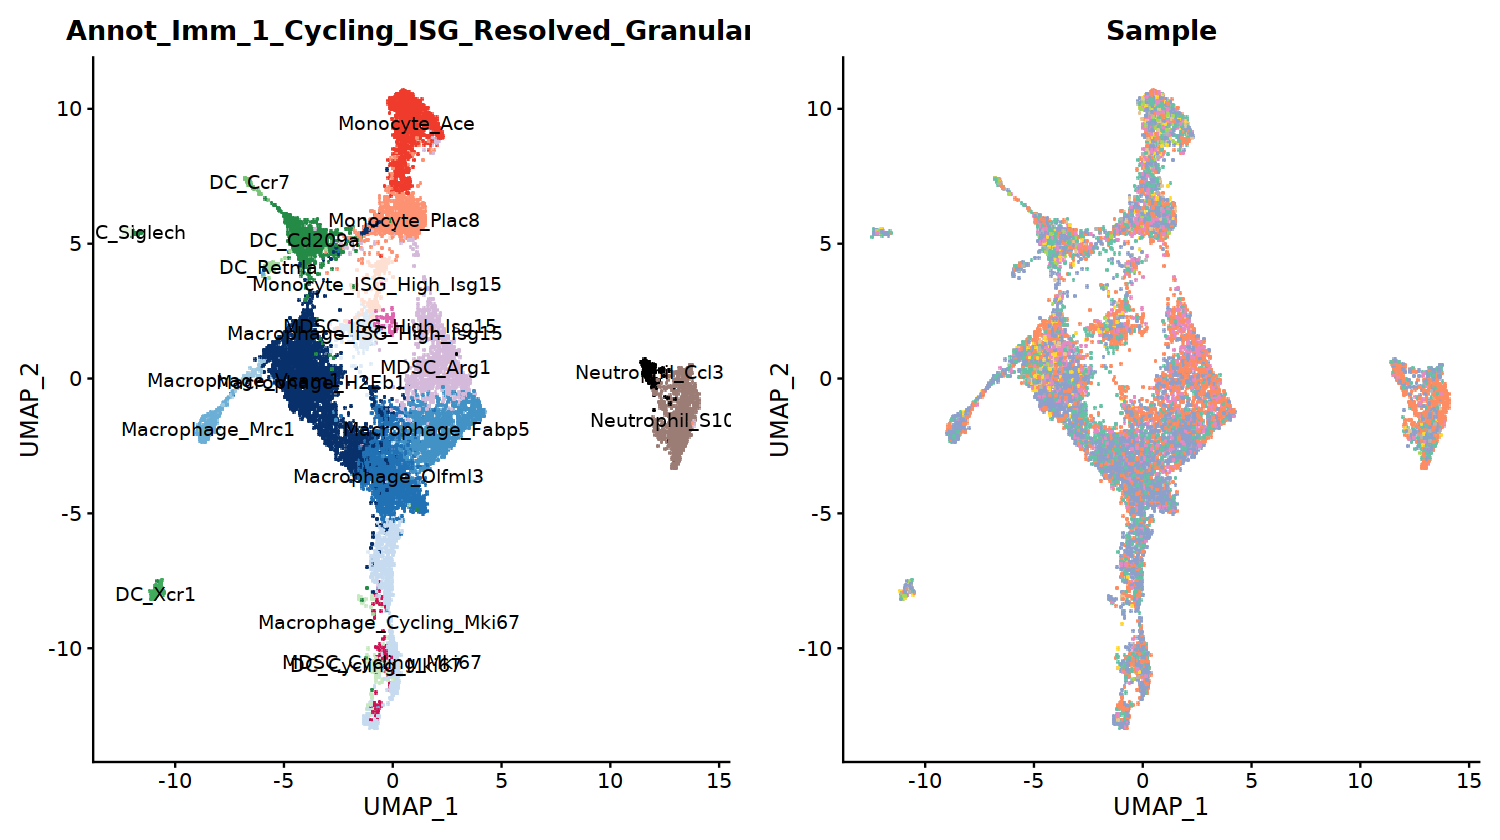

In [66]:
seur_myl_plot$Sample = factor(seur_myl_plot$Sample, levels = c("11_VX5256_T","3_BB453_T","6_BB452_KL_T","9_VX516_T","10_VX516_N","12_VX5256_N","5_BB452_KR_N","8_BB455_N"))

one = DimPlot(seur_myl_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular",cols = mycols, raster = T) + NoLegend()
two = DimPlot(seur_myl_plot, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) + NoLegend()
three = DimPlot(seur_myl_plot, group.by = "Sample", cols = samp_cols[levels(seur_myl_plot$Sample)],shuffle = T,raster = T) + NoLegend()

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig10_Myl_CellType_Sample_Repo.pdf", width = 12.5, height = 7)

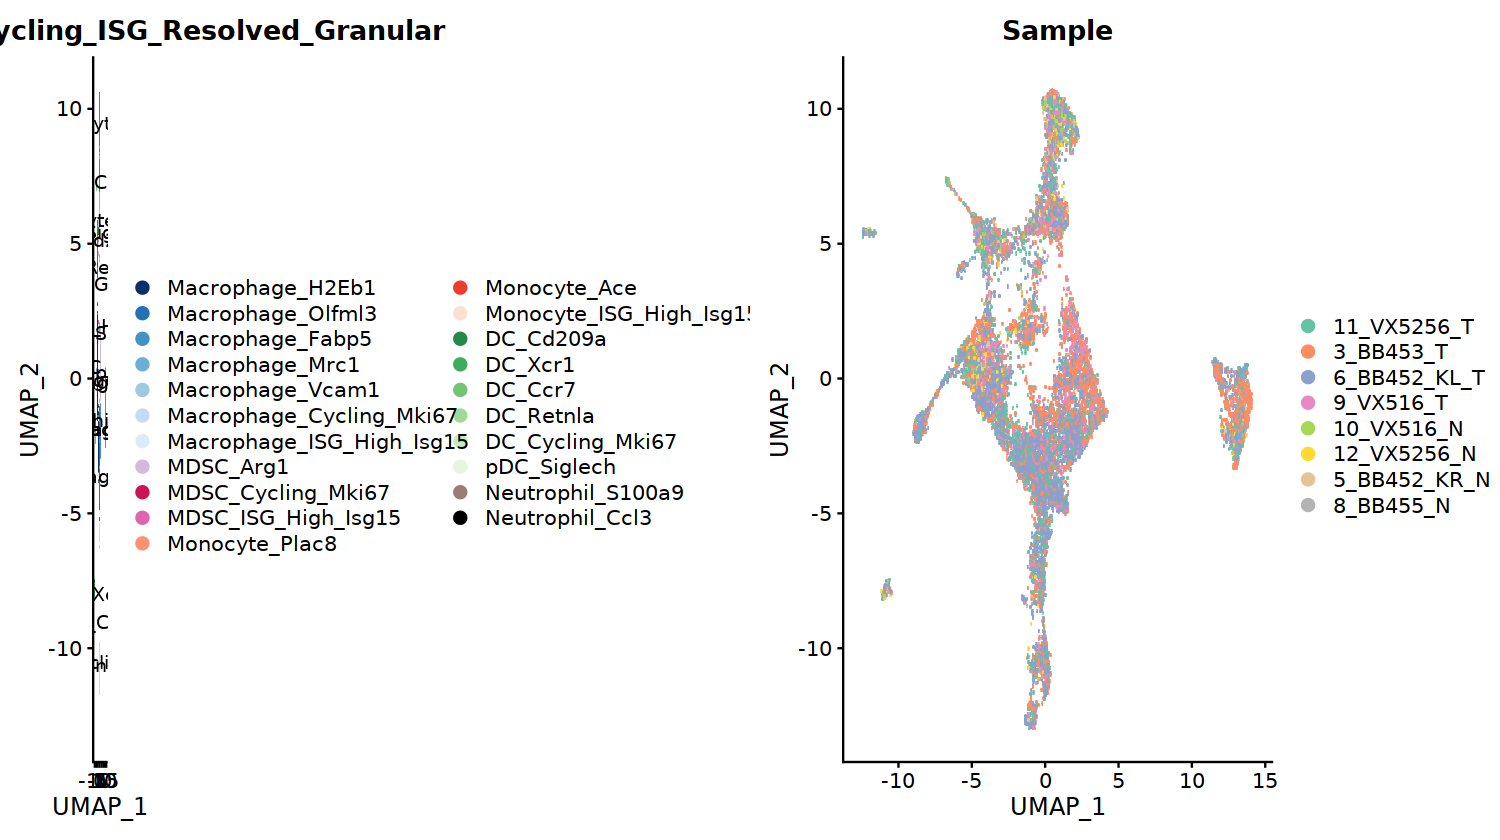

In [67]:
seur_myl_plot$Sample = factor(seur_myl_plot$Sample, levels = c("11_VX5256_T","3_BB453_T","6_BB452_KL_T","9_VX516_T","10_VX516_N","12_VX5256_N","5_BB452_KR_N","8_BB455_N"))

one = DimPlot(seur_myl_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular",cols = mycols, raster = T) 
two = DimPlot(seur_myl_plot, group.by = "Sex", cols = c("#4daf4a","#984ea3"),shuffle = T,raster = T) + NoLegend()
three = DimPlot(seur_myl_plot, group.by = "Sample", cols = samp_cols[levels(seur_myl_plot$Sample)],shuffle = T,raster = T)

library(ggpubr)
options(repr.plot.width=12.5, repr.plot.height=7)
ggarrange(one, three, nrow = 1)

ggsave("Manuscript_Figures/SuppFig10_Myl_CellType_Sample_WithLegend_Repo.pdf", width = 12.5, height = 7)

In [70]:
table(seur_myl_plot$Sample)


 11_VX5256_T    3_BB453_T 6_BB452_KL_T    9_VX516_T   10_VX516_N  12_VX5256_N 
        1994         3114         4603         1429          211          451 
5_BB452_KR_N    8_BB455_N 
         187          207 

Var1              Var2        Freq       
1 Macrophage_H2Eb1  11_VX5256_T 0.208625878
2 Macrophage_Olfml3 11_VX5256_T 0.129388164
3 Macrophage_Fabp5  11_VX5256_T 0.090772317
4 Macrophage_Mrc1   11_VX5256_T 0.025576730
5 Macrophage_Vcam1  11_VX5256_T 0.007021063

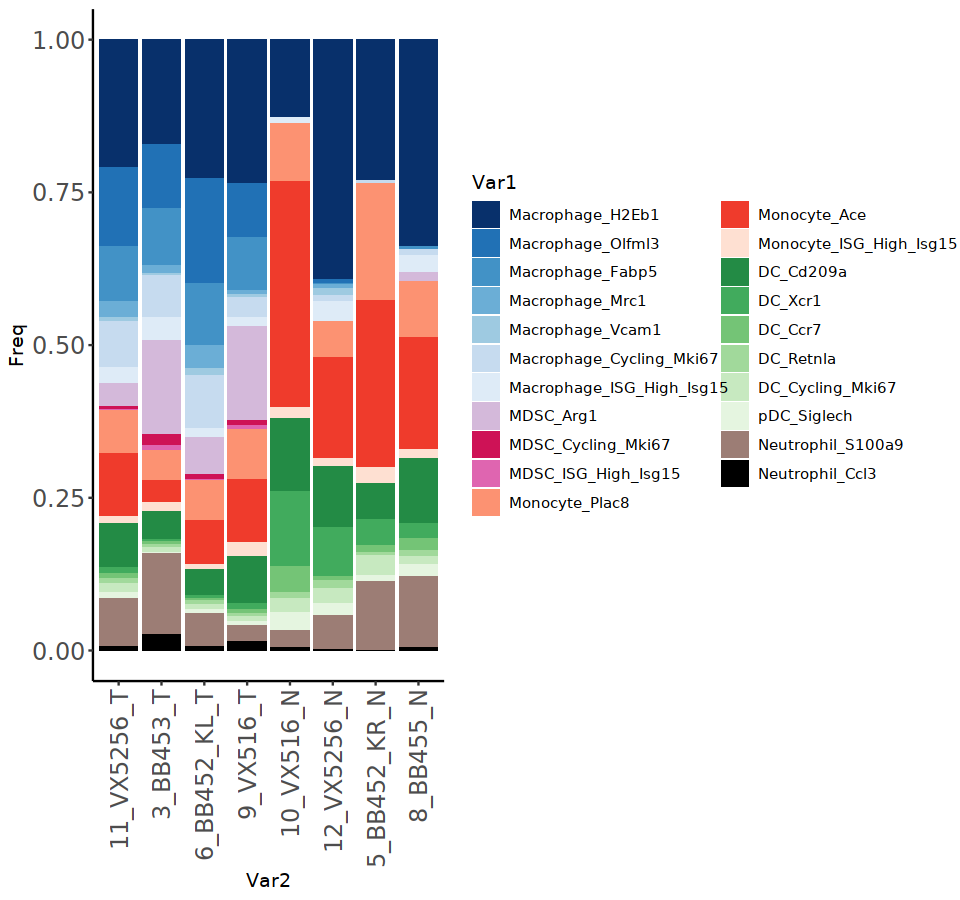

In [68]:
options(repr.plot.width=8, repr.plot.height=7.5)
props <- prop.table(table(seur_myl_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular,seur_myl_plot$Sample), margin = 2)
props <- data.frame(props)
corner(props)
ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") + theme_classic() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = mycols) 


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



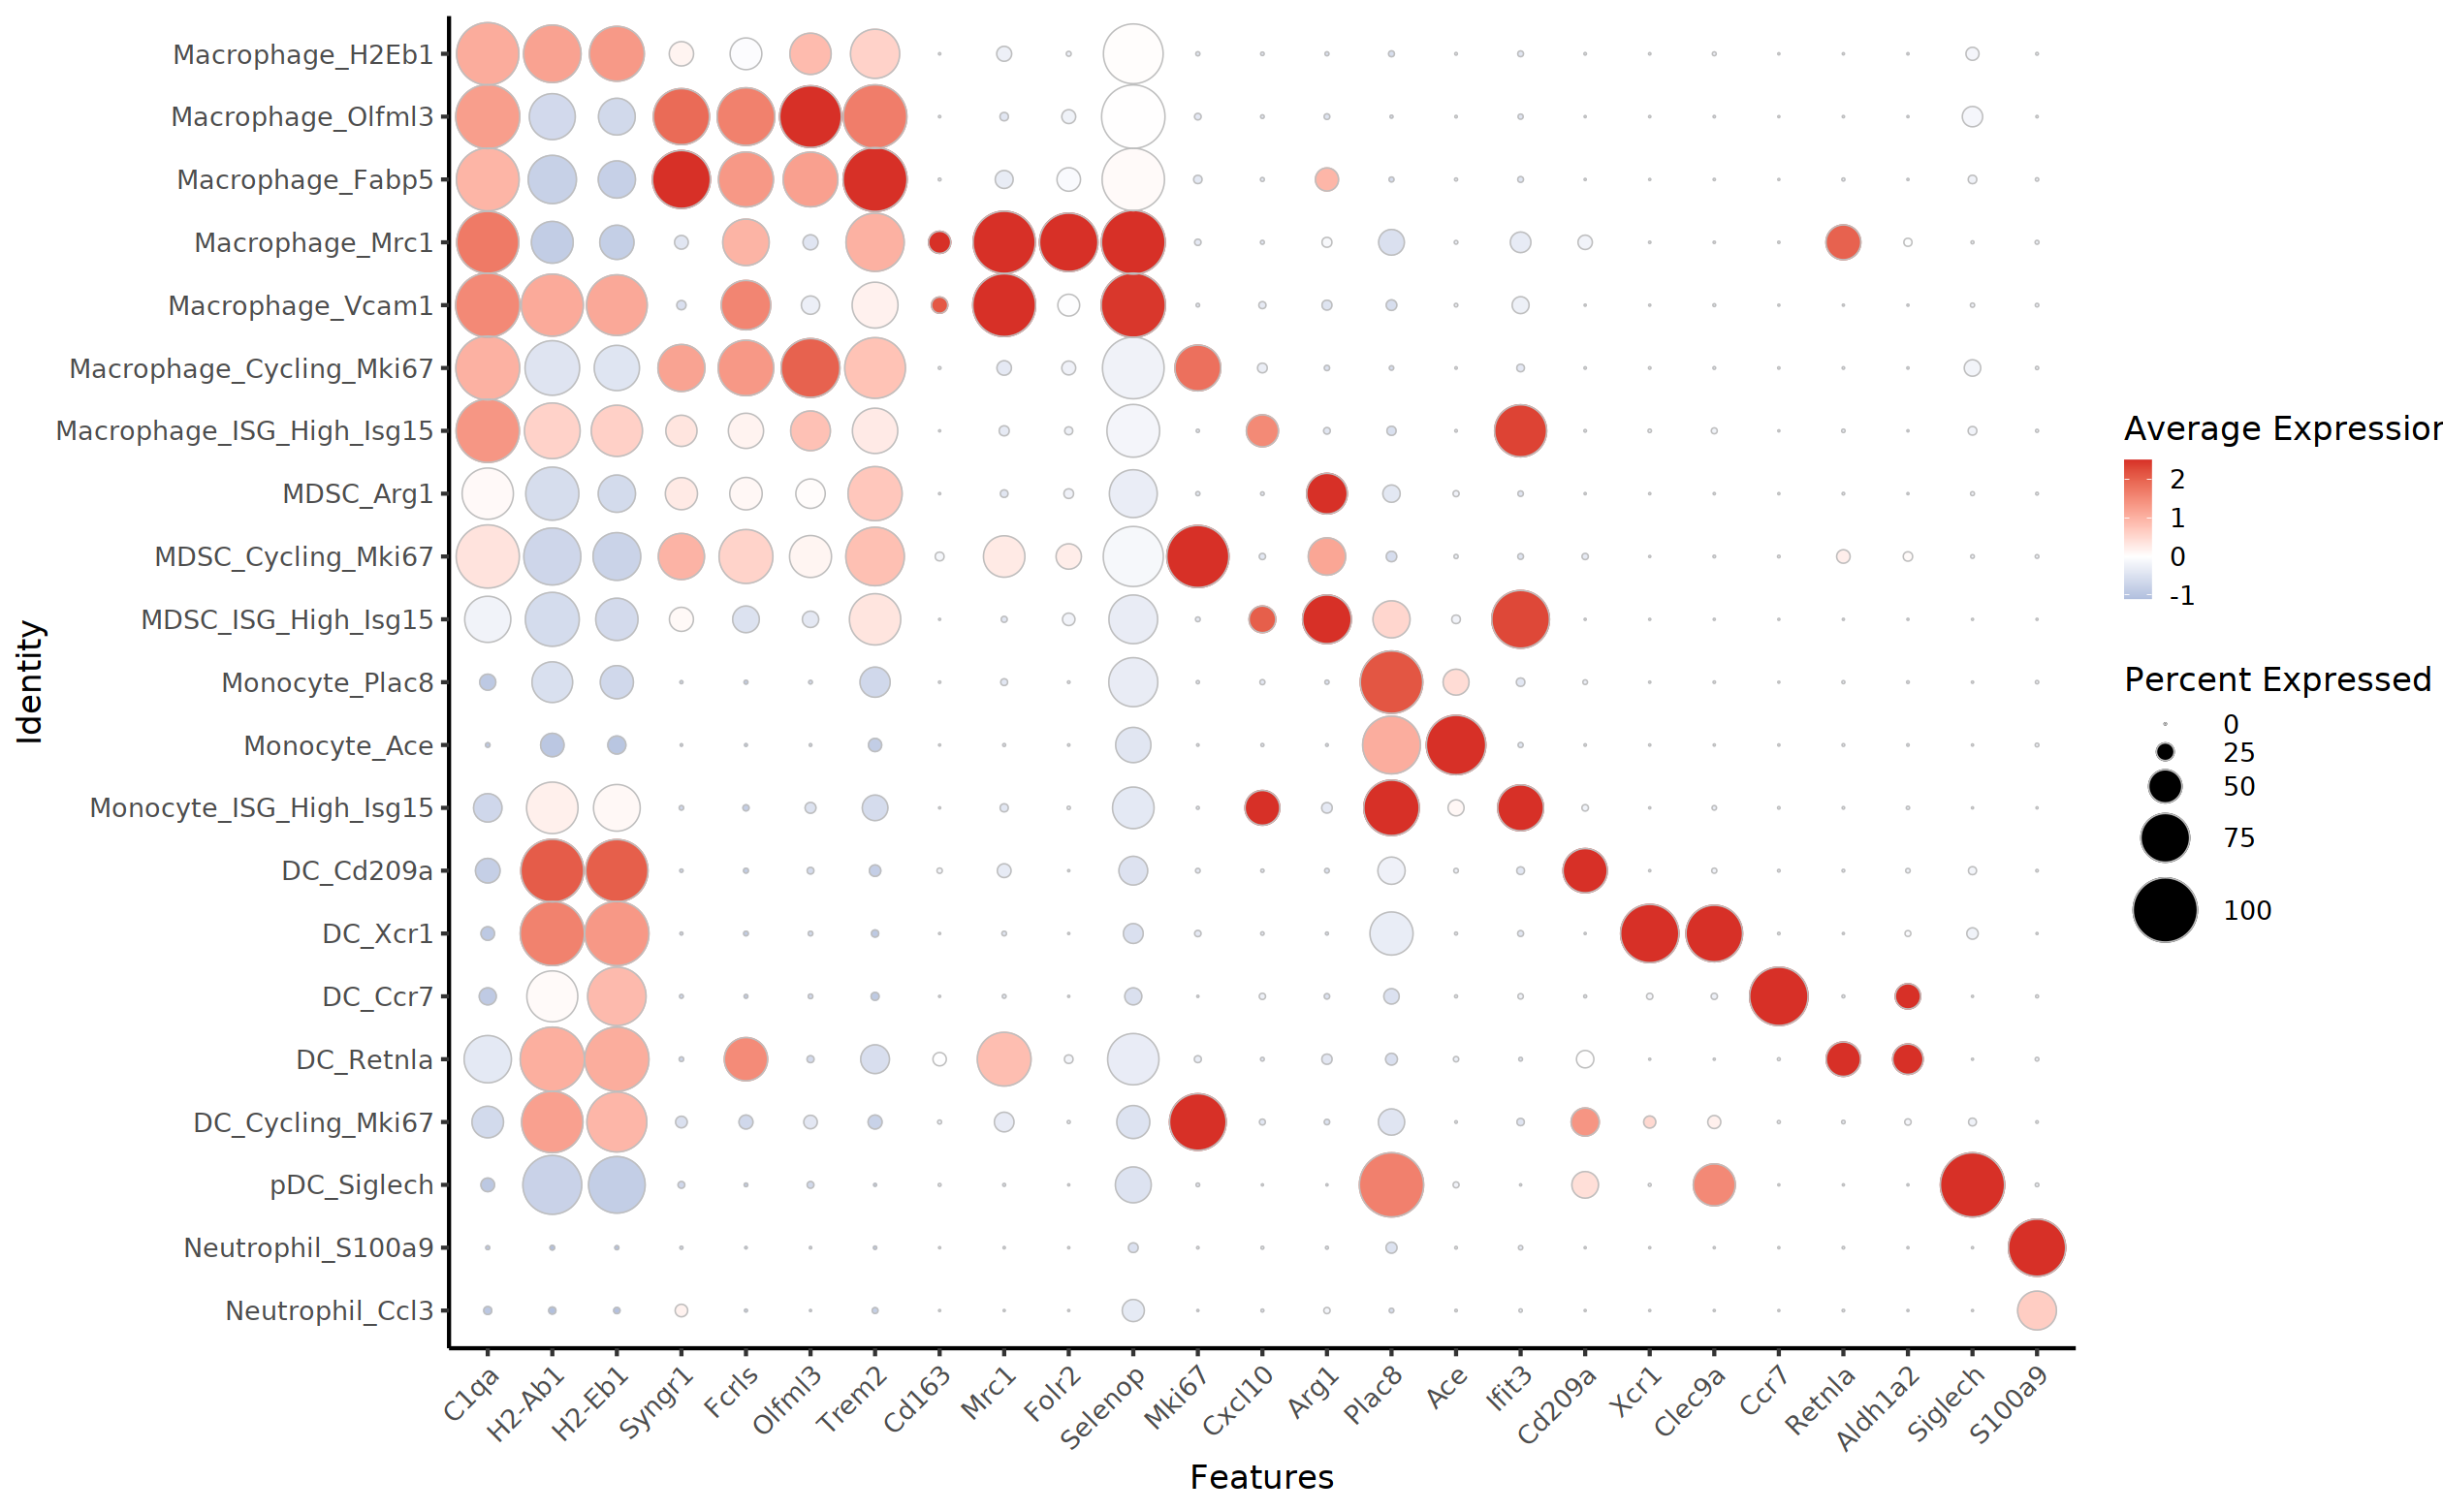

In [69]:
options(repr.plot.width=21, repr.plot.height=13)

Idents(seur_myl_plot) = factor(Idents(seur_myl_plot), levels = rev(levels(Idents(seur_myl_plot))))

DotPlot(seur_myl_plot, features = c("C1qa","H2-Ab1","H2-Eb1","Syngr1","Fcrls","Olfml3","Trem2","Cd163","Mrc1","Folr2","Selenop","Mki67","Cxcl10","Arg1","Plac8","Ace","Ifit3","Cd209a","Xcr1","Clec9a","Ccr7","Retnla","Aldh1a2","Siglech","S100a9"),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_myl_plot) = factor(Idents(seur_myl_plot), levels = rev(levels(Idents(seur_myl_plot))))

ggsave("Manuscript_Figures/SuppFig10_Myl_Dotplot_Markers_Repo.pdf", width = 21, height = 13)

### 7. Galaxy plots and bar plots showing differential enrichment of myeloid cell states between normal kidney and tumor

In [2]:
seur = readRDS("Manuscript_Objects/NormalKidney_CrelessTumor_SeuratObject.RDS")
seur_i = readRDS(file = "Manuscript_Objects/Immune_SeuratObject.RDS")
Idents(seur_i) = factor(Idents(seur_i), levels = c("CD8_T_cell","NKT","NK","gd_T_cell","T_Helper","T_reg","Plasma_cell","Macrophage","MDSC","Monocyte","cDC","pDC","Neutrophil","LowQual"))
seur_i = subset(seur_i, idents = "LowQual", invert = T)

In [3]:
Idents(seur_i) = "Annot_Imm_1_Cycling_ISG_Resolved_Granular"

Centering and scaling data matrix

PC_ 1 
Positive:  Gsr, S100a11, Pglyrp1, Hp, S100a6, Cytip, Plac8, Il1b, Napsa, S100a8 
	   S100a9, Ifitm6, Cxcr2, Neat1, Gpr141, Itgal, Rara, Pim1, Slpi, Dusp1 
	   Csf3r, Itga4, Nr4a1, Ltb, Sell, Mcemp1, Mmp9, Lyst, Gda, Ace 
Negative:  C1qc, C1qb, C1qa, Pmepa1, Trem2, Cd81, Hexb, Lgmn, Grn, Ms4a7 
	   Apoe, Tuba1b, Stmn1, Atpif1, Fcrls, Stab1, Olfml3, Cd63, Itgb5, Timp2 
	   Ctss, Lgals1, Prdx1, Ctsz, Mki67, Top2a, Hmgn1, Tubb5, Cxcl16, C3ar1 
PC_ 2 
Positive:  Top2a, Pclaf, Nusap1, Mki67, Hist1h1b, Kif11, Birc5, Prc1, Knl1, Spc24 
	   Ccna2, Esco2, Cdca3, Kif15, Cenpf, Cdca8, Tpx2, Pbk, Hmgb2, Cdk1 
	   Hist1h3c, Cenpe, Stmn1, Ckap2l, Hist1h2ae, Hmmr, Aurkb, Spc25, Ube2c, Bub1b 
Negative:  Apoe, Cd63, Ctsd, Ms4a7, Trem2, C1qc, C1qa, C1qb, C3ar1, Timp2 
	   Fth1, Lgmn, Ctsb, Ftl1, Mafb, Igf1, Abca1, Stab1, Hexb, Trf 
	   Anxa3, Cd81, Selenop, Ctsz, Itgb5, Ctss, Tmem37, Bhlhe41, Grn, Pmepa1 
PC_ 3 
Positive:  Clec4d, Ninj1, Adam8, Txn1, S100a8, Grin

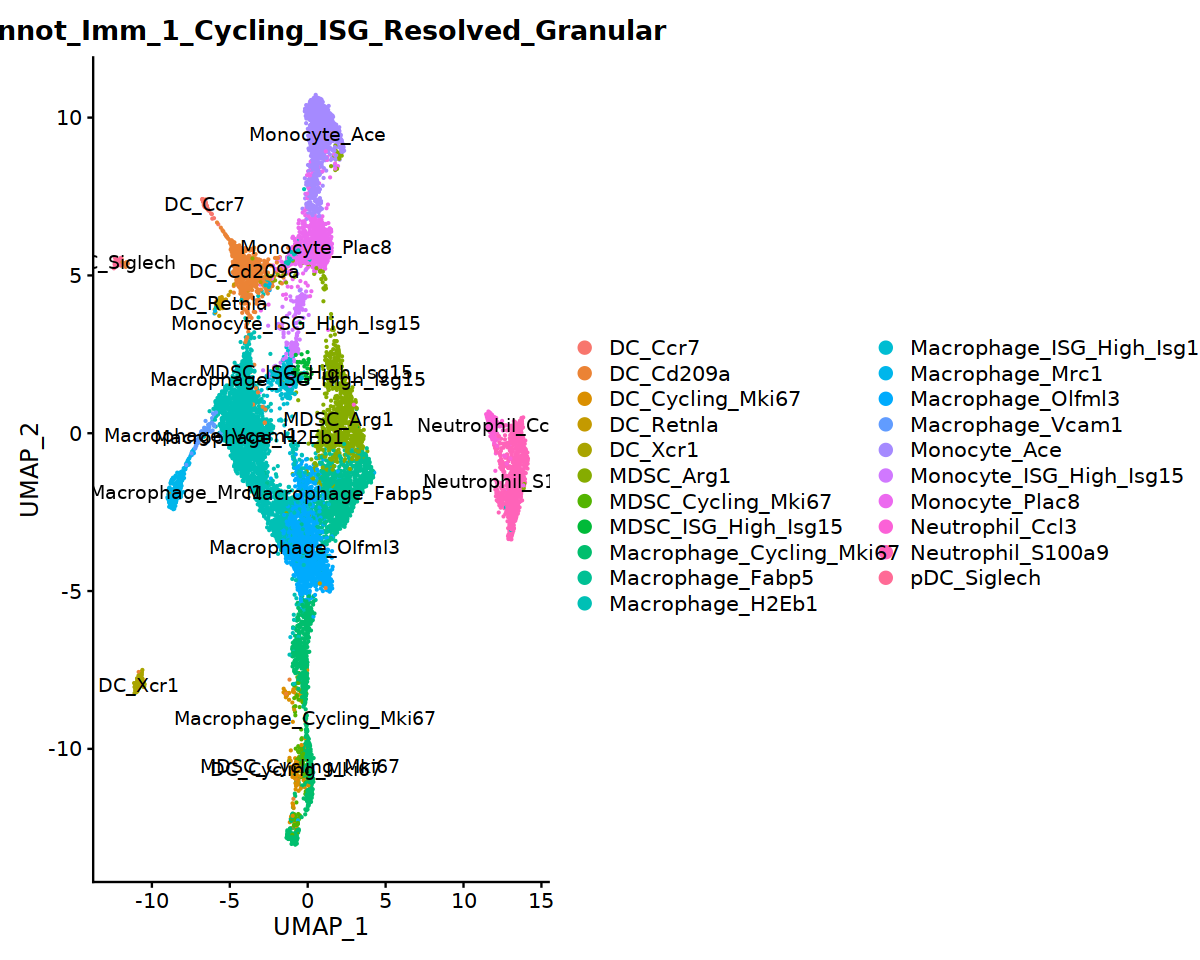

In [4]:
options(repr.plot.width=10, repr.plot.height=8)

seur_myl_plot = subset(seur_i, idents = c("DC_Ccr7","DC_Cd209a","DC_Cycling_Mki67","DC_Retnla","DC_Xcr1","MDSC_Arg1","MDSC_Cycling_Mki67","MDSC_ISG_High_Isg15","Macrophage_Cycling_Mki67","Macrophage_Fabp5","Macrophage_H2Eb1","Macrophage_ISG_High_Isg15","Macrophage_Mrc1","Macrophage_Olfml3","Macrophage_Vcam1","Monocyte_Ace","Monocyte_ISG_High_Isg15","Monocyte_Plac8","Neutrophil_Ccl3","Neutrophil_S100a9","pDC_Siglech"))
seur_myl_plot <- NormalizeData(seur_myl_plot)
seur_myl_plot <- FindVariableFeatures(seur_myl_plot, selection.method = "vst",nfeatures = 3000)
seur_myl_plot <- ScaleData(seur_myl_plot, features = row.names(seur_myl_plot))
seur_myl_plot <- RunPCA(seur_myl_plot, npcs = 30,verbose = T)
seur_myl_plot <- RunHarmony(seur_myl_plot, group.by.vars = "Sample")
seur_myl_plot <- RunUMAP(seur_myl_plot, reduction = "harmony", dims = 1:30)
#seur_myl_plot <- FindNeighbors(seur_myl_plot, reduction = "harmony", dims = 1:30)
#seur_myl_plot <- FindClusters(seur_myl_plot, resolution = 0.5)
DimPlot(seur_myl_plot, label = T, group.by = "Annot_Imm_1_Cycling_ISG_Resolved_Granular")

In [5]:
table(seur_myl_plot$Sample)


  10_VX516_N  11_VX5256_T  12_VX5256_N    3_BB453_T 5_BB452_KR_N 6_BB452_KL_T 
         211         1994          451         3114          187         4603 
   8_BB455_N    9_VX516_T 
         207         1429 

In [6]:
omit_lowcellnumber = c("DC_Ccr7","DC_Retnla","MDSC_ISG_High_Isg15","Macrophage_Vcam1","pDC_Siglech")

In [7]:
totals = as.vector(table(seur_myl_plot$Sample))
names(totals) = names(table(seur_myl_plot$Sample))
totals

meta_broad = seur_myl_plot@meta.data
head(meta_broad)

samples = names(totals)
samples

target = meta_broad

res = list()

for (i in 1:length(samples)){
    sub = subset(target, Sample == samples[i])
    sub_table = table(sub$Annot_Imm_1_Cycling_ISG_Resolved_Granular)
    sub_table = as.vector(sub_table)
    names(sub_table) = names(table(sub$Annot_Imm_1_Cycling_ISG_Resolved_Granular))
    sub_table = sub_table/(totals[i])
    res[[i]] = sub_table*100
}

names(res) = samples
res_df = as.data.frame(res,check.names = F)
res_df = res_df[c("DC_Ccr7","DC_Cd209a","DC_Cycling_Mki67","DC_Retnla","DC_Xcr1","MDSC_Arg1","MDSC_Cycling_Mki67","MDSC_ISG_High_Isg15","Macrophage_Cycling_Mki67","Macrophage_Fabp5","Macrophage_H2Eb1","Macrophage_ISG_High_Isg15","Macrophage_Mrc1","Macrophage_Olfml3","Macrophage_Vcam1","Monocyte_Ace","Monocyte_ISG_High_Isg15","Monocyte_Plac8","Neutrophil_Ccl3","Neutrophil_S100a9","pDC_Siglech"),]
res_df

10_VX516_N  11_VX5256_T  12_VX5256_N    3_BB453_T 5_BB452_KR_N 6_BB452_KL_T 
         211         1994          451         3114          187         4603 
   8_BB455_N    9_VX516_T 
         207         1429

orig.ident nCount_RNA nFeature_RNA
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 Sample.10  23276      4508        
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 Sample.10  20688      3968        
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 Sample.10  18728      4060        
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 Sample.10  18554      3869        
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 Sample.10  16782      4286        
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 Sample.10  16707      3096        
                                     Sample    
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 10_VX516_N
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 10_VX516_N
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 10_VX516_N
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 10_VX516_N
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 10_VX516_N
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 10_VX516_N
                                     cell_id                             
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 Sample.10_VX516_N.TTCCTCTAGATGCTAA-1
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 Sample.10_VX516_N.AGAGCCCGTGAATAAC-1
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 Sample.10_VX516_N.TGACTCCGTGGTTTAC-1
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 Sample.10_VX516_N.ATTTCTGTCTTCCACG-1
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 Sample.10_VX516_N.GCATGATGTGCGTTTA-1
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 Sample.10_VX516_N.ACTGCAAAGAACCCGA-1
                                     percent.mt TumorNormal Sex    Helicobacter
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1  2.1782093 Normal      Female neg         
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1  1.7304718 Normal      Female neg         
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1  1.1747117 Normal      Female neg         
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1  0.6790988 Normal      Female neg         
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 13.0914075 Normal      Female neg         
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1  1.0354941 Normal      Female neg         
                                     RNA_snn_res.0.5 seurat_clusters Annot1
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 8               8               22    
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 8               8               22    
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 8               8               22    
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 20              21              23    
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 8               8               22    
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 20              21              23    
                                     RNA_snn_res.0.6 Annot_Imm_1          
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 8               Myeloid_Cycling_Mki67
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 8               Myeloid_Cycling_Mki67
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 8               Myeloid_Cycling_Mki67
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 21              DC_Xcr1              
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 8               Myeloid_Cycling_Mki67
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 21              DC_Xcr1              
                                     Annot_Imm_1_Cycling_ISG_Resolved
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 DC_Cycling                      
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 DC_Cycling                      
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 DC_Cycling                      
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 DC_Xcr1                         
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 DC_Cycling                      
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 DC_Xcr1                         
                                     Annot_Imm_1_Cycling_ISG_Resolved_Granular
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 DC_Cycling_Mki67                         
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 DC_Cycling_Mki67                         
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 DC_Cycling_Mki67                         
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 DC_Xcr1                                  
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 DC_Cycling_Mki67                         
Sample.10_VX516_N.ACTGCAAAGAACCCGA-1 DC_Xcr1                                  
                   

[1] "10_VX516_N"   "11_VX5256_T"  "12_VX5256_N"  "3_BB453_T"    "5_BB452_KR_N"
[6] "6_BB452_KL_T" "8_BB455_N"    "9_VX516_T"

10_VX516_N 11_VX5256_T 12_VX5256_N 3_BB453_T 
DC_Ccr7                    4.2654028  0.8024072   0.6651885   0.5780347
DC_Cd209a                 11.8483412  7.1715145   9.9778271   4.4637123
DC_Cycling_Mki67           2.3696682  1.6048144   2.4390244   0.7385999
DC_Retnla                  0.9478673  0.7021063   1.3303769   0.4816956
DC_Xcr1                   12.3222749  1.0531595   7.9822616   0.3532434
MDSC_Arg1                  0.0000000  3.7612839   0.0000000  15.3821452
MDSC_Cycling_Mki67         0.0000000  0.5516550   0.0000000   1.7662171
MDSC_ISG_High_Isg15        0.0000000  0.1504514   0.0000000   0.8991651
Macrophage_Cycling_Mki67   0.0000000  7.5225677   0.8869180   6.7758510
Macrophage_Fabp5           0.0000000  9.0772317   0.2217295   9.4091201
Macrophage_H2Eb1          12.7962085 20.8625878  39.2461197  17.1483622
Macrophage_ISG_High_Isg15  0.9478673  2.5576730   3.3259424   3.8535645
Macrophage_Mrc1            0.0000000  2.5576730   0.6651885   1.2845215
Macrophage_Olfml3          0.0000000 12.9388164   0.6651885  10.4688504
Macrophage_Vcam1           0.0000000  0.7021063   1.1086475   0.3211304
Monocyte_Ace              36.9668246 10.1805416  16.4079823   3.4682081
Monocyte_ISG_High_Isg15    1.8957346  1.2537613   1.3303769   1.6056519
Monocyte_Plac8             9.4786730  7.1213641   5.9866962   4.9132948
Neutrophil_Ccl3            0.4739336  0.6018054   0.2217295   2.6653821
Neutrophil_S100a9          2.8436019  7.8736209   5.5432373  13.2305716
pDC_Siglech                2.8436019  0.9528586   1.9955654   0.1926782
                          5_BB452_KR_N 6_BB452_KL_T 8_BB455_N  9_VX516_T 
DC_Ccr7                    1.0695187    0.2824245    1.9323671  0.6997901
DC_Cd209a                  5.8823529    4.2798175   10.6280193  7.7676697
DC_Cycling_Mki67           3.2085561    0.8907234    1.4492754  0.6997901
DC_Retnla                  0.5347594    0.6300239    0.9661836  0.5598321
DC_Xcr1                    4.2780749    0.5865740    2.4154589  0.9097271
MDSC_Arg1                  0.0000000    6.0612644    1.4492754 15.5353394
MDSC_Cycling_Mki67         0.0000000    0.9341734    0.0000000  0.7697691
MDSC_ISG_High_Isg15        0.0000000    0.1520747    0.0000000  0.6997901
Macrophage_Cycling_Mki67   0.5347594    8.7117098    0.9661836  3.3589923
Macrophage_Fabp5           0.0000000   10.2324571    0.4830918  8.6773968
Macrophage_H2Eb1          22.9946524   22.7894851   33.8164251 23.5829251
Macrophage_ISG_High_Isg15  0.0000000    1.3686726    2.8985507  1.3296011
Macrophage_Mrc1            0.0000000    3.7801434    0.0000000  0.7697691
Macrophage_Olfml3          0.0000000   17.0540952    0.0000000  8.7473758
Macrophage_Vcam1           0.0000000    1.1514230    0.0000000  0.4198740
Monocyte_Ace              27.2727273    7.2995872   18.3574879 10.4268719
Monocyte_ISG_High_Isg15    2.6737968    0.6951988    1.4492754  2.1693492
Monocyte_Plac8            19.2513369    6.4305887    9.1787440  8.0475857
Neutrophil_Ccl3            0.0000000    0.6300239    0.4830918  1.5395381
Neutrophil_S100a9         11.2299465    5.4964154   11.5942029  2.5892232
pDC_Siglech                1.0695187    0.5431240    1.9323671  0.6997901

In [8]:
res_df = data.frame(t(res_df), check.names = F)
res_df$TumorNormal = c("Normal","Tumor","Normal","Tumor","Normal","Tumor","Normal","Tumor")
res_df$Sample = row.names(res_df)
res_df

res_df_melt = melt(res_df)

Helicobacter = c("5_BB452_KR_N","6_BB452_KL_T","8_BB455_N","3_BB453_T")

res_df_melt = mutate(res_df_melt, Helicobacter = ifelse(Sample %in% Helicobacter, "pos","neg"))
head(res_df_melt)

DC_Ccr7   DC_Cd209a DC_Cycling_Mki67 DC_Retnla DC_Xcr1   
10_VX516_N   4.2654028 11.848341 2.3696682        0.9478673 12.3222749
11_VX5256_T  0.8024072  7.171515 1.6048144        0.7021063  1.0531595
12_VX5256_N  0.6651885  9.977827 2.4390244        1.3303769  7.9822616
3_BB453_T    0.5780347  4.463712 0.7385999        0.4816956  0.3532434
5_BB452_KR_N 1.0695187  5.882353 3.2085561        0.5347594  4.2780749
6_BB452_KL_T 0.2824245  4.279818 0.8907234        0.6300239  0.5865740
8_BB455_N    1.9323671 10.628019 1.4492754        0.9661836  2.4154589
9_VX516_T    0.6997901  7.767670 0.6997901        0.5598321  0.9097271
             MDSC_Arg1 MDSC_Cycling_Mki67 MDSC_ISG_High_Isg15
10_VX516_N    0.000000 0.0000000          0.0000000          
11_VX5256_T   3.761284 0.5516550          0.1504514          
12_VX5256_N   0.000000 0.0000000          0.0000000          
3_BB453_T    15.382145 1.7662171          0.8991651          
5_BB452_KR_N  0.000000 0.0000000          0.0000000          
6_BB452_KL_T  6.061264 0.9341734          0.1520747          
8_BB455_N     1.449275 0.0000000          0.0000000          
9_VX516_T    15.535339 0.7697691          0.6997901          
             Macrophage_Cycling_Mki67 Macrophage_Fabp5 ... Macrophage_Olfml3
10_VX516_N   0.0000000                 0.0000000       ...  0.0000000       
11_VX5256_T  7.5225677                 9.0772317       ... 12.9388164       
12_VX5256_N  0.8869180                 0.2217295       ...  0.6651885       
3_BB453_T    6.7758510                 9.4091201       ... 10.4688504       
5_BB452_KR_N 0.5347594                 0.0000000       ...  0.0000000       
6_BB452_KL_T 8.7117098                10.2324571       ... 17.0540952       
8_BB455_N    0.9661836                 0.4830918       ...  0.0000000       
9_VX516_T    3.3589923                 8.6773968       ...  8.7473758       
             Macrophage_Vcam1 Monocyte_Ace Monocyte_ISG_High_Isg15
10_VX516_N   0.0000000        36.966825    1.8957346              
11_VX5256_T  0.7021063        10.180542    1.2537613              
12_VX5256_N  1.1086475        16.407982    1.3303769              
3_BB453_T    0.3211304         3.468208    1.6056519              
5_BB452_KR_N 0.0000000        27.272727    2.6737968              
6_BB452_KL_T 1.1514230         7.299587    0.6951988              
8_BB455_N    0.0000000        18.357488    1.4492754              
9_VX516_T    0.4198740        10.426872    2.1693492              
             Monocyte_Plac8 Neutrophil_Ccl3 Neutrophil_S100a9 pDC_Siglech
10_VX516_N    9.478673      0.4739336        2.843602         2.8436019  
11_VX5256_T   7.121364      0.6018054        7.873621         0.9528586  
12_VX5256_N   5.986696      0.2217295        5.543237         1.9955654  
3_BB453_T     4.913295      2.6653821       13.230572         0.1926782  
5_BB452_KR_N 19.251337      0.0000000       11.229947         1.0695187  
6_BB452_KL_T  6.430589      0.6300239        5.496415         0.5431240  
8_BB455_N     9.178744      0.4830918       11.594203         1.9323671  
9_VX516_T     8.047586      1.5395381        2.589223         0.6997901  
             TumorNormal Sample      
10_VX516_N   Normal      10_VX516_N  
11_VX5256_T  Tumor       11_VX5256_T 
12_VX5256_N  Normal      12_VX5256_N 
3_BB453_T    Tumor       3_BB453_T   
5_BB452_KR_N Normal      5_BB452_KR_N
6_BB452_KL_T Tumor       6_BB452_KL_T
8_BB455_N    Normal      8_BB455_N   
9_VX516_T    Tumor       9_VX516_T

Using TumorNormal, Sample as id variables



TumorNormal Sample       variable value     Helicobacter
1 Normal      10_VX516_N   DC_Ccr7  4.2654028 neg         
2 Tumor       11_VX5256_T  DC_Ccr7  0.8024072 neg         
3 Normal      12_VX5256_N  DC_Ccr7  0.6651885 neg         
4 Tumor       3_BB453_T    DC_Ccr7  0.5780347 pos         
5 Normal      5_BB452_KR_N DC_Ccr7  1.0695187 pos         
6 Tumor       6_BB452_KL_T DC_Ccr7  0.2824245 pos

In [9]:
res_df_melt = subset(res_df_melt, !(variable %in% omit_lowcellnumber))

In [10]:
unique(res_df_melt$variable)

[1] DC_Cd209a                 DC_Cycling_Mki67         
 [3] DC_Xcr1                   MDSC_Arg1                
 [5] MDSC_Cycling_Mki67        Macrophage_Cycling_Mki67 
 [7] Macrophage_Fabp5          Macrophage_H2Eb1         
 [9] Macrophage_ISG_High_Isg15 Macrophage_Mrc1          
[11] Macrophage_Olfml3         Monocyte_Ace             
[13] Monocyte_ISG_High_Isg15   Monocyte_Plac8           
[15] Neutrophil_Ccl3           Neutrophil_S100a9        
21 Levels: DC_Ccr7 DC_Cd209a DC_Cycling_Mki67 DC_Retnla DC_Xcr1 ... pDC_Siglech

In [11]:
res_df_melt$variable = factor(res_df_melt$variable, levels = c("MDSC_Arg1","MDSC_Cycling_Mki67","Macrophage_H2Eb1","Macrophage_Olfml3","Macrophage_Fabp5","Macrophage_Mrc1","Macrophage_Cycling_Mki67","Macrophage_ISG_High_Isg15","Monocyte_Plac8","Monocyte_Ace","Monocyte_ISG_High_Isg15","DC_Cd209a","DC_Xcr1","DC_Cycling_Mki67","Neutrophil_S100a9","Neutrophil_Ccl3"))



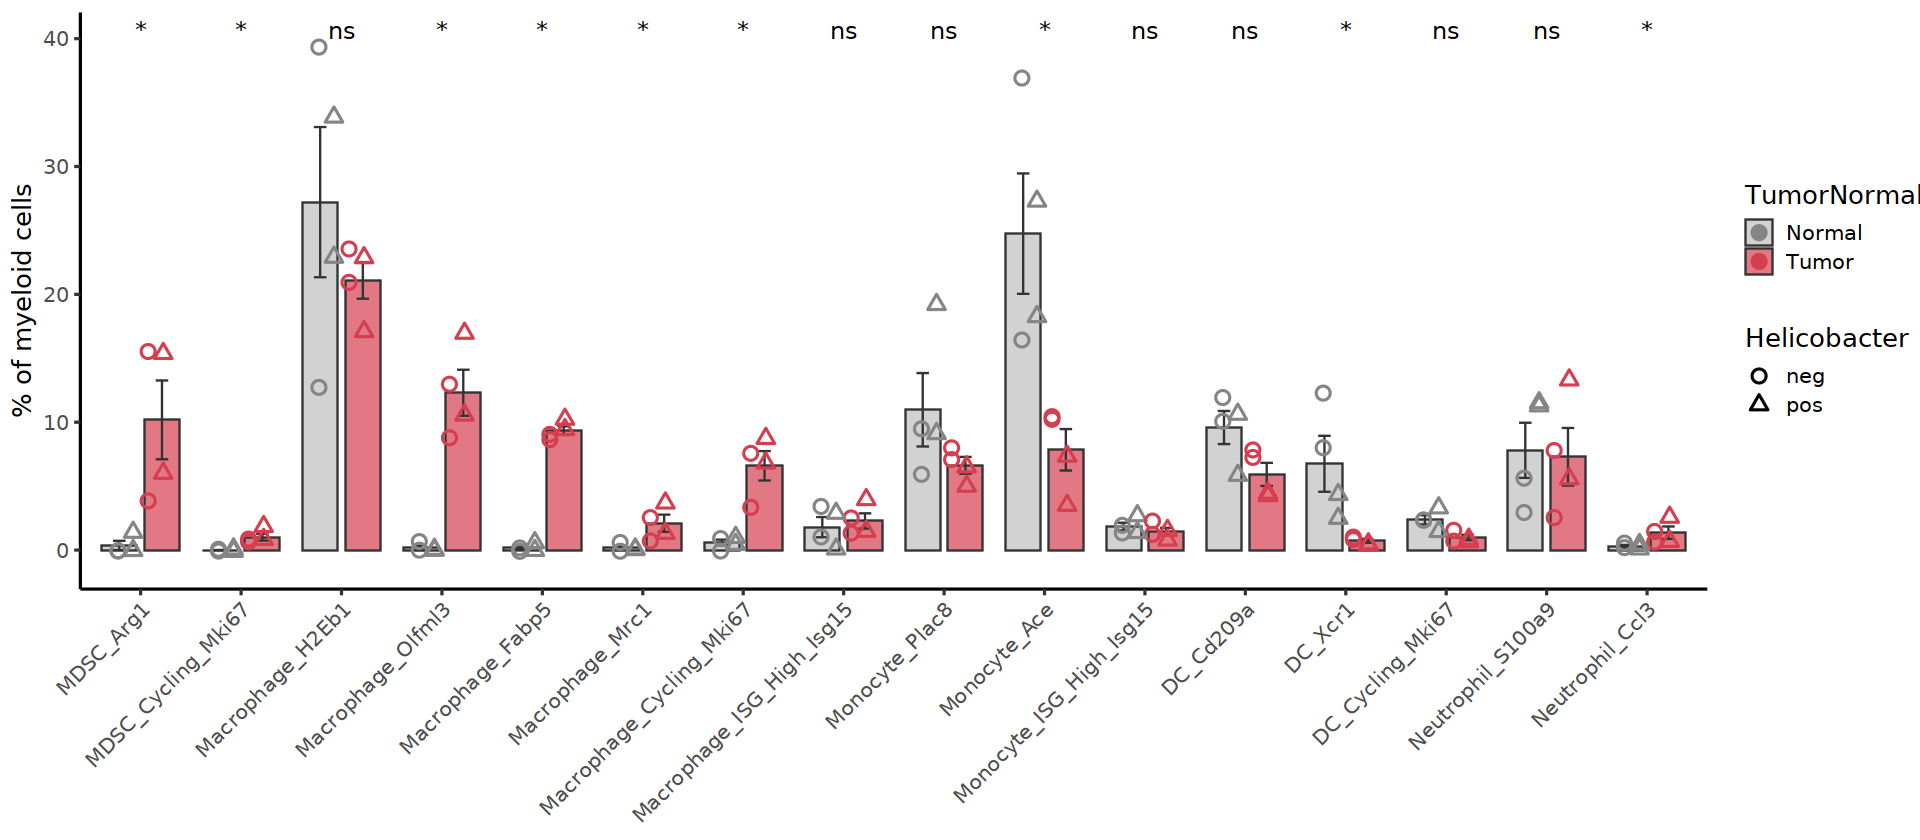

In [12]:
options(repr.plot.width=16, repr.plot.height=7)

ggbarplot(res_df_melt, x = "variable", y = "value",fill = "TumorNormal",
               add = c("mean_se"),add.params = list(width = 0.25),width = 0.7,alpha = 0.7,color = "grey20",
               position = position_dodge(0.85)) +
scale_fill_manual(values = c("gray","#d53e4f")) +
geom_jitter(aes(variable, value, fill = TumorNormal,color = TumorNormal,shape = Helicobacter),  size = 3,stroke = 1, position = position_jitterdodge(jitter.height = .1, jitter.width = 0,dodge.width = 0.6)) +
scale_color_manual(values = c("gray52","#d53e4f")) + theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
scale_shape_manual(values = c(1,2)) +
ylab("% of myeloid cells") + xlab(label = NULL) +
ylim(c(-1,40)) +
stat_compare_means(aes(group = TumorNormal), label = "p.signif",size = 5)

ggsave("Manuscript_Figures/SuppFig10_Myeloid_Fig_Frequency_Barplots_WithSignif_Helicobacter_Repo.pdf", width = 16, height = 8)

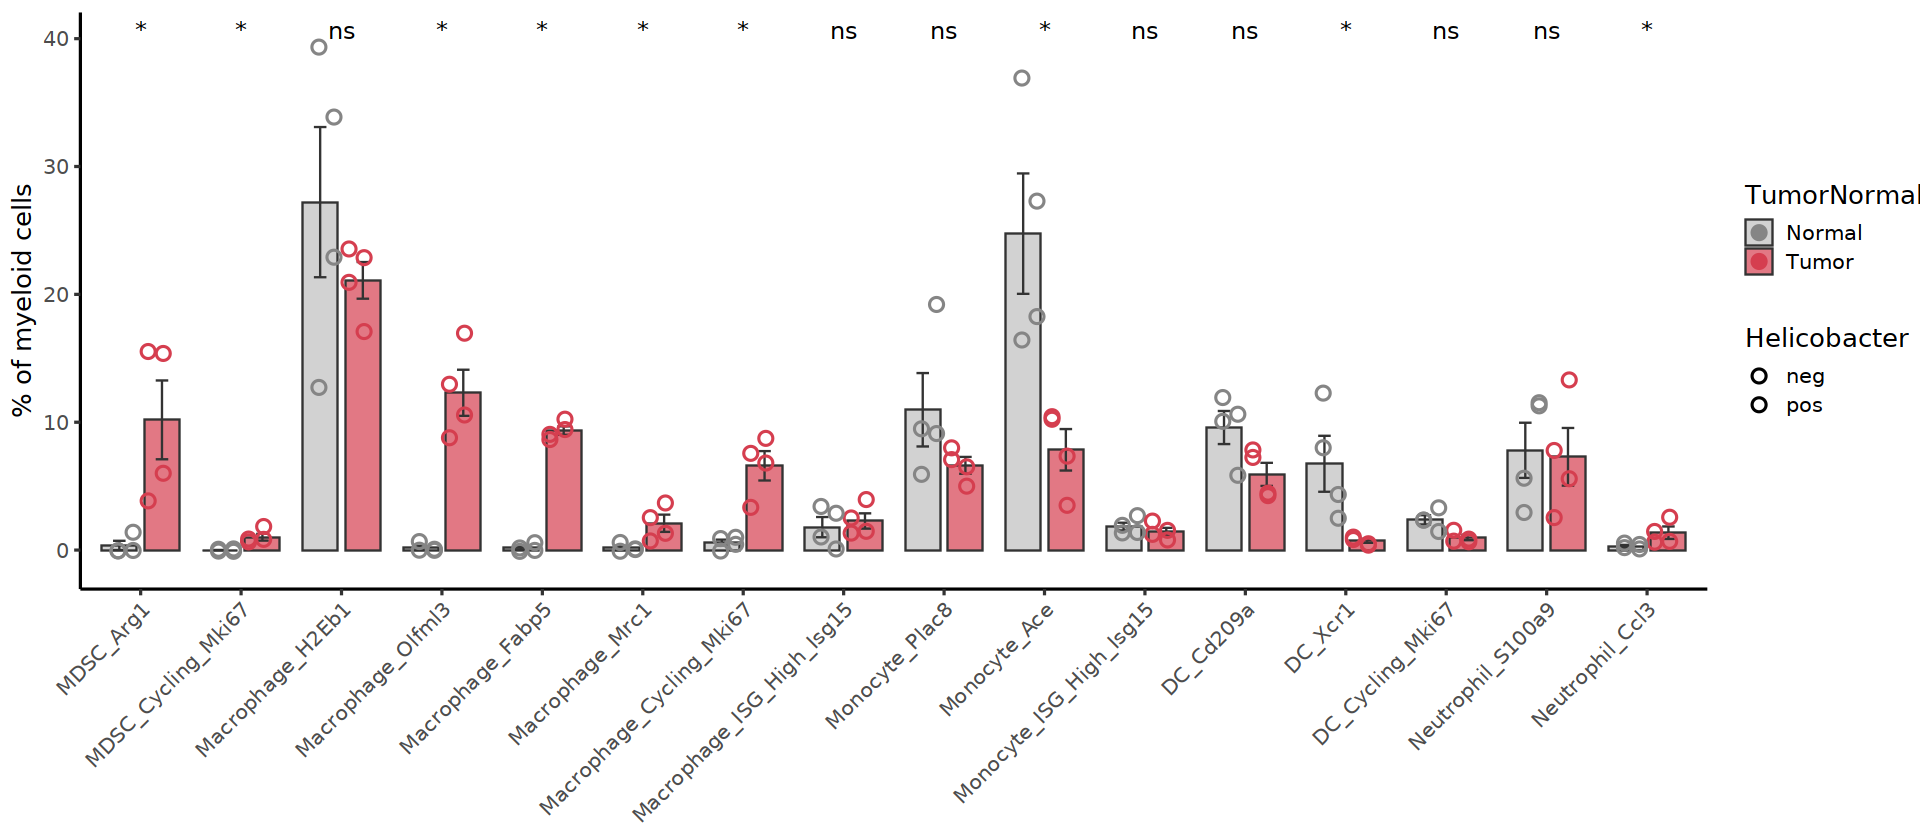

In [13]:
options(repr.plot.width=16, repr.plot.height=7)

ggbarplot(res_df_melt, x = "variable", y = "value",fill = "TumorNormal",
               add = c("mean_se"),add.params = list(width = 0.25),width = 0.7,alpha = 0.7,color = "grey20",
               position = position_dodge(0.85)) +
scale_fill_manual(values = c("gray","#d53e4f")) +
geom_jitter(aes(variable, value, fill = TumorNormal,color = TumorNormal,shape = Helicobacter),  size = 3,stroke = 1, position = position_jitterdodge(jitter.height = .1, jitter.width = 0,dodge.width = 0.6)) +
scale_color_manual(values = c("gray52","#d53e4f")) + theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + 
scale_shape_manual(values = c(1,1)) +
ylab("% of myeloid cells") + xlab(label = NULL) +
ylim(c(-1,40)) +
stat_compare_means(aes(group = TumorNormal), label = "p.signif",size = 5)

ggsave("Manuscript_Figures/SuppFig10_Myeloid_Fig_Frequency_Barplots_WithSignif_NoHelicobacter_Repo.pdf", width = 16, height = 8)

UMAP_1      UMAP_2     CellType        
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1  -0.4980547 -10.258979 DC_Cycling_Mki67
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1  -0.1266552 -11.105980 DC_Cycling_Mki67
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1  -0.2704078 -10.905002 DC_Cycling_Mki67
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 -10.5187237  -7.891778 DC_Xcr1         
Sample.10_VX516_N.GCATGATGTGCGTTTA-1  -0.7191870 -12.461055 DC_Cycling_Mki67
                                     TumorNormal
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 Normal     
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 Normal     
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 Normal     
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 Normal     
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 Normal     
                                     barcode                             
Sample.10_VX516_N.TTCCTCTAGATGCTAA-1 Sample.10_VX516_N.TTCCTCTAGATGCTAA-1
Sample.10_VX516_N.AGAGCCCGTGAATAAC-1 Sample.10_VX516_N.AGAGCCCGTGAATAAC-1
Sample.10_VX516_N.TGACTCCGTGGTTTAC-1 Sample.10_VX516_N.TGACTCCGTGGTTTAC-1
Sample.10_VX516_N.ATTTCTGTCTTCCACG-1 Sample.10_VX516_N.ATTTCTGTCTTCCACG-1
Sample.10_VX516_N.GCATGATGTGCGTTTA-1 Sample.10_VX516_N.GCATGATGTGCGTTTA-1

Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."


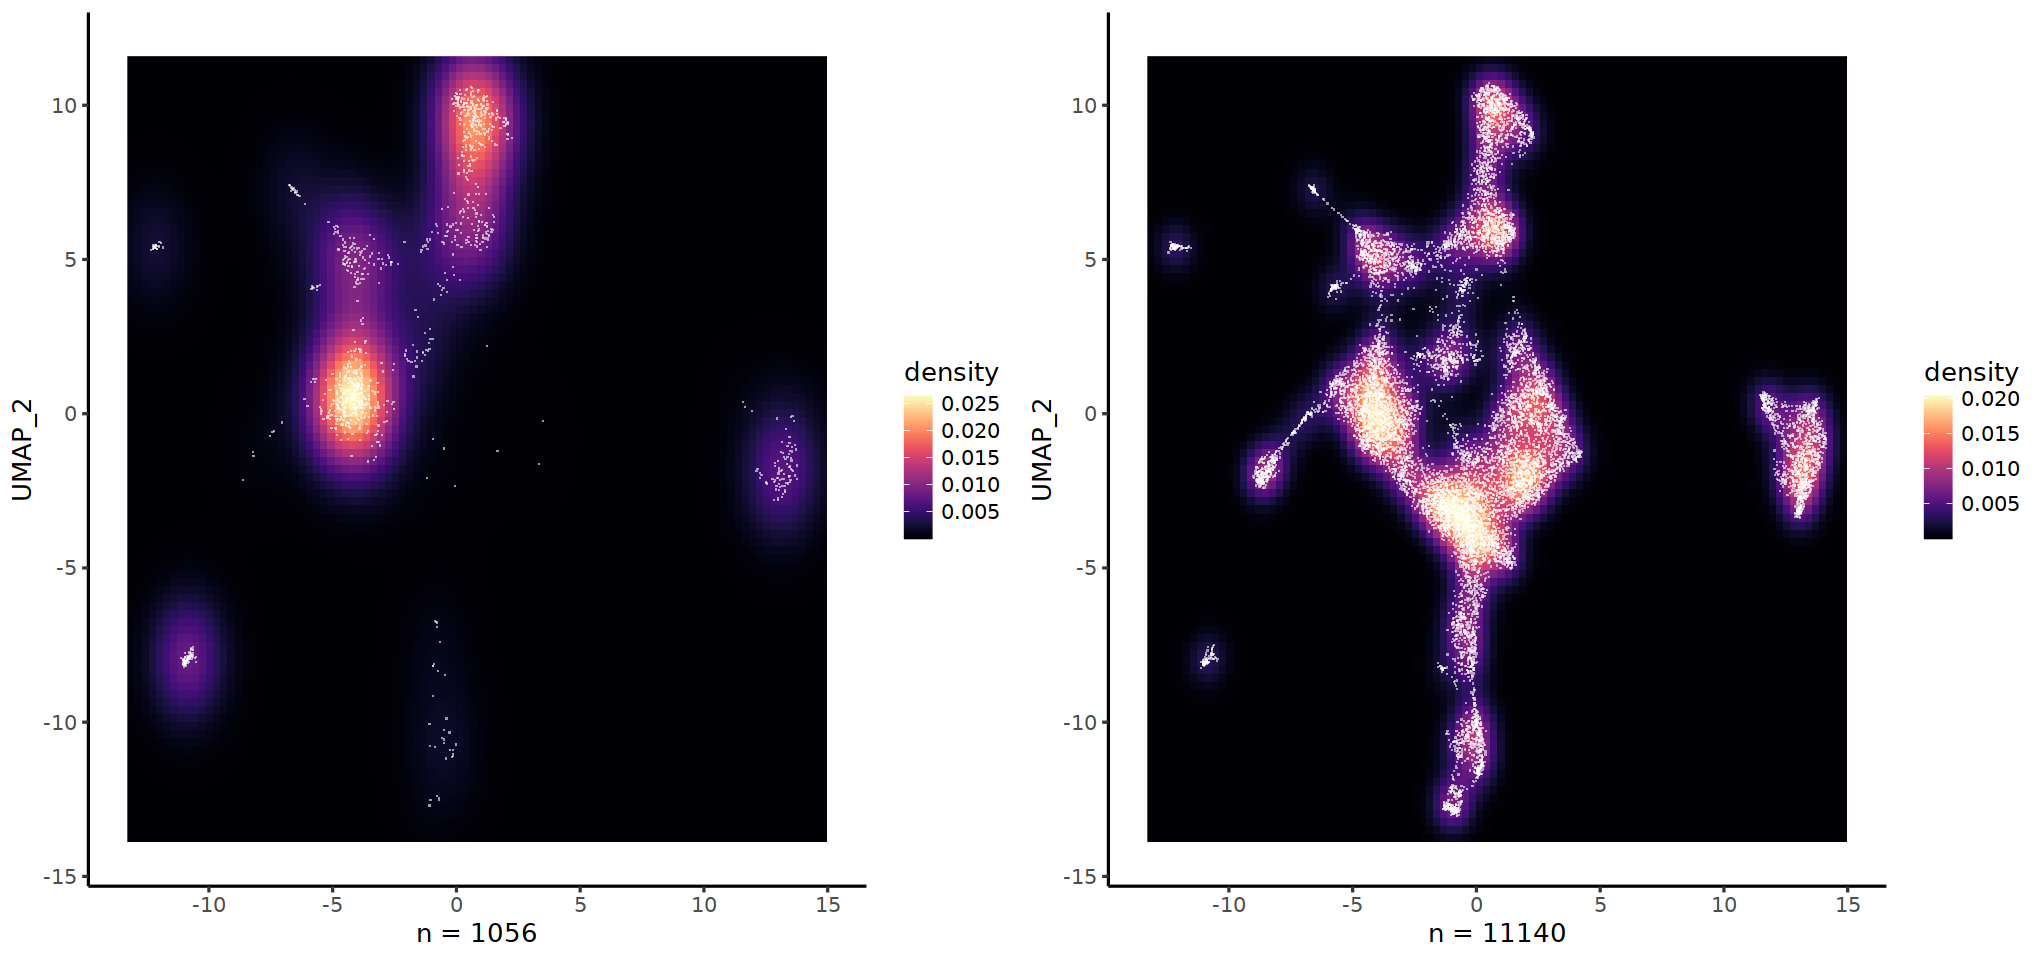

In [14]:
df = data.frame(seur_myl_plot@reductions$umap@cell.embeddings)
df$CellType = seur_myl_plot$Annot_Imm_1_Cycling_ISG_Resolved_Granular
df$TumorNormal = seur_myl_plot$TumorNormal
df$barcode = row.names(df)
corner(df)

UMAP_1 = df$UMAP_1
UMAP_2 = df$UMAP_2

one = ggplot(subset(df,TumorNormal == "Normal"), aes(UMAP_1, UMAP_2)) +
stat_density_2d(aes(fill = ..density..), geom = 'raster', contour = FALSE) +
scale_fill_viridis(option = "magma") +
#coord_cartesian(expand = FALSE, xlim = c(min(UMAP_1), max(UMAP_1)),ylim = c(min(UMAP_2),max(UMAP_2))) +
xlim(c(min(UMAP_1)-1, max(UMAP_1)+1)) +
ylim(c(min(UMAP_2)-1, max(UMAP_2)+1)) +
geom_point(shape = ".",col = "white", alpha = 0.6) +
 xlab(paste("n = ",nrow(subset(df,TumorNormal == "Normal")),sep = "")) +
theme_classic(base_size = 15)


UMAP_1 = df$UMAP_1
UMAP_2 = df$UMAP_2

two = ggplot(subset(df,TumorNormal == "Tumor"), aes(UMAP_1, UMAP_2)) +
stat_density_2d(aes(fill = ..density..), geom = 'raster', contour = FALSE) +
scale_fill_viridis(option = "magma") +
#coord_cartesian(expand = FALSE, xlim = c(min(UMAP_1), max(UMAP_1)),ylim = c(min(UMAP_2),max(UMAP_2))) +
xlim(c(min(UMAP_1)-1, max(UMAP_1)+1)) +
ylim(c(min(UMAP_2)-1, max(UMAP_2)+1)) +
geom_point(shape = ".",col = "white", alpha = 0.6) + 
xlab(paste("n = ",nrow(subset(df,TumorNormal == "Tumor")),sep = "")) +
theme_classic(base_size = 15)

options(repr.plot.width=17, repr.plot.height=8)
ggarrange(one, two)

ggsave("Manuscript_Figures/SuppFig10_Myl_Fig_Galaxies_Repo.pdf", width = 17, height = 8)